# ADA Project
<br><br>

----
### Subject: 
finding what influence the number of protests among: area of the country, population density, net migration, infant mortality, deathrate, income group, climate, etc.  
<br><br>

----
### Objective: 
finding what to change in a country to decrease the number of protests (assuming that a less number of protests means that the inhabitants are happier)
<br><br>

----
### Summary:
First, we will get all the data we need. Second we will find a way to display data on a world map to visualize the number of protests around the world. Then, we will try to find the impact of many variables on this number of protests.
<br><br>

----
### Data explanations:
Please see the read me, section Dataset / 4- Data description to see data explanations

Here a brief explanation:

We are using the data available at the following link: https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events This is a context of **big data**: around **400 000 000** of rows.
<br><br>
- ##### <u>eventcodes.csv</u>

As we are interested in protest as kind of event, we need to find the event code associated to the protest events: **eventcodes.csv** gives us this data.
<br><br>
- ##### <u>country_by_income.csv and countries_stats.csv</u>

Then, we need to get data on all the countries to find the impact of their characteristics on the number of protests: **country_by_income.csv** and **countries_stats.csv** give us what we need. Thanks to these files, we have access to: the average income, area of the country, population density, net migration, infant mortality, deathrate, climate, etc of each country.
Got from: http://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html and https://www.kaggle.com/fernandol/countries-of-the-world/version/1

<br><br>
Let's see the **countries_stats.csv** file:

data got from: https://www.kaggle.com/fernandol/countries-of-the-world/version/1

Data available: `Country`, `Region`, `Population`, `Area (sq. mi.)`, `Pop. Density (per sq. mi.)`, `Coastline (coast/area ratio)`, `Net migration`, `Infant mortality (per 1000 births)`, `GDP ($ per capita)`, `Literacy (%)`, `Phones (per 1000)`, `Arable (%)`, `Crops (%)`, `Other (%)`, `Climate`, `Birthrate`, `Deathrate`, `Agriculture`, `Industry`, `Service`.

Most of the variables don't need to be explain as `population`, `Area (sq. mi.)`, `Infant mortality`, etc. As we wordered the meaning of `climate`, here the explanation we found:

Meaning of `climate`: 1= Dry tropical, 2= Wet tropical, 3= Temperate humid subtropical and temperate continental, 4= Dry hot summers and wet winters
<br><br>
- ##### <u>country_codes_iso2_to_iso3.csv and country_code_to_name.csv</u>

Each data define the country in a different way: code in `ISO2` or `ISO3` or with the `country name`. We need to convert each ones with the same convention. For example, to define the United-States of America, the csv files use "USA", "US" or "United-States of America". 
**country_codes_iso2_to_iso3.csv** and **country_code_to_name.csv** allow us to achieve these conversions.
there are from: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
<br><br>

- ##### <u>GDP growth world bank.csv and GINI per country worldbank.csv</u> (<a> https://data.worldbank.org </a>)
These two dataset are the estimations of the Gross Domestic Product (GDP) and the Index of Inequality (GINI) for each country , from 1960 to 2017. These datasets will be usefull economical and social indicator to understand the protestation in different countries.
(Higher index is better)

- ##### <u>DataCorruptionPerceptionIndex2000_2017.xlsx</u> (<a>https://www.transparency.org</a>)
This data set shows the estimated Corruption index (political and buisness corruption) for each country from 2000 to 2017. 
(Lower index is better)

- ##### <u>Human Development Index (HDI).csv</u> (<a> http://hdr.undp.org/en/data </a>)
Dataset of the HDI for each country from 1990 to 2017.
HDI a good indicator of the life expectancy and education of people in the country.
The definition of HDI from wikipedia:
"The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators"
(Higher index is better)



- ##### <u>World press freedom.csv
</u> (<a> https://rsf.org/fr/donnees-classement </a>)(<a> https://en.wikipedia.org/wiki/Press_Freedom_Index </a>)
This data-set shows the score of each country concerning the press freedom from 2002 to 2018
(Lower index is better)



----
### Next steps until Dec. 16
Please see the read me, section "A list of internal milestones until Dec. 16" or the end of the notebook as asked here: https://dlab.epfl.ch/teaching/fall2018/cs401/projects/

In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import os
import json
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.core.display import display, HTML
from IPython.core.display import Image, display

from sklearn.linear_model import LinearRegression, LogisticRegression
from branca.colormap import linear
import statsmodels.api as sm
from scipy import stats
from functions.folium_functions import *
from functions.dataframe_functions import *
from functions.getting_tables import *
from functions.animated_maps_functions import *
from functions.stats_functions import *

import seaborn as sns
from math import pi


DATA_PATH = "data/"
VISUALIZATION_PATH = "visualizations/"

FOLIUM_MAPS_PATH = VISUALIZATION_PATH + "folium_maps/"
STATS_REGION_PATH = VISUALIZATION_PATH + 'stats_regions/'
ANIMATED_MAP_PATH = VISUALIZATION_PATH +  'animated_maps/'

WORLD_MAP_TYPE_PATH = ANIMATED_MAP_PATH + 'world_map_type/'
WORLD_MAP_FREQ_PATH = ANIMATED_MAP_PATH + 'world_map_freq/'
COUNTRY_MAP_PATH = ANIMATED_MAP_PATH + 'individual_country_map/'
US_MAP_PATH = ANIMATED_MAP_PATH + 'us_map_elections/'
US_MAP_FREQ_PATH = ANIMATED_MAP_PATH + 'us_map_freq/'
GDP_GROWTH_STAT_PATH = VISUALIZATION_PATH + 'GPD_Growth_protests_count/'

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\bronner\Dropbox\\ADATTC-8869006f93d1.json'
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\bot_\\Downloads\\AdaProject-3323118f7315.json'
# get json by following (Setting up authentication)
# https://cloud.google.com/bigquery/docs/reference/libraries

In [2]:
bigquery_client = bigquery.Client()

# Getting the main tables:

- event codes table
- indication of richness per inhabitant per country
- Protests for leadership change
- Protests for rights
- country codes table
- country codes conversion iso2 to iso3
- statistics on countries

### Event codes:

In [3]:
event_codes = pd.read_csv(DATA_PATH + "eventcodes.csv", encoding = "ISO-8859-1")

### Indication of richness per inhabitant per country per year:

In [4]:
country_by_income_per_year = pd.read_csv(DATA_PATH + "country_by_income.csv", encoding = "ISO-8859-1")

In [5]:
country_by_income_per_year=country_by_income_per_year.dropna()
#here we only get an indicator of the income, we need to transform it to process it
#we choose to transform Low income (L) to 1, (LM) to 3, (UM) to 4, (H) to 6
country_by_income_per_year=country_by_income_per_year.replace('Low income (L)', '-3')
country_by_income_per_year=country_by_income_per_year.replace('Lower middle income (LM)', '-1')
country_by_income_per_year=country_by_income_per_year.replace('Upper middle income (UM)', '1')
country_by_income_per_year=country_by_income_per_year.replace('High income (H)', '3')
country_by_income_per_year['Income Group']=country_by_income_per_year['Income Group'].astype(int)

### Getting all protests events:
With:
- ##### <u> ID </u>
- ##### <u> CountryCode </u>
- ##### <u> EventCode </u>
- ##### <u> Year </u>


In [6]:
reload = False
if os.path.isfile(DATA_PATH + 'protests_df_raw_1.csv') and os.path.isfile(DATA_PATH + 'protests_df_raw_2.csv') and not reload :
    protests_df_raw_1 = pd.read_csv(DATA_PATH + 'protests_df_raw_1.csv')
    protests_df_raw_2 = pd.read_csv(DATA_PATH + 'protests_df_raw_2.csv')
    
else:
    query_protests = bigquery_client.query(
        """SELECT GLOBALEVENTID as ID, ActionGeo_CountryCode as CountryCode,  EventCode,MonthYear,NumMentions,AvgTone, Year FROM `gdelt-bq.gdeltv2.events` 
        WHERE EventCode LIKE '14%' """)
    protests_df_raw = query_protests.result().to_dataframe()
    # Write down the csv
    protests_df_raw_1 = protests_df_raw[0:int(np.floor(len(protests_df_raw)/2))]
    protests_df_raw_2 = protests_df_raw.iloc[int(np.floor(len(protests_df_raw)/2)):,]
    
    protests_df_raw_1.to_csv(DATA_PATH + 'protests_df_raw_1.csv', index=False)
    protests_df_raw_2.to_csv(DATA_PATH + 'protests_df_raw_2.csv', index=False)

protests_df_raw = pd.concat([protests_df_raw_1, protests_df_raw_2], ignore_index=True)    
protests_df = protests_df_raw.dropna()

In [7]:
print("Number of rows we got: " + str(protests_df_raw['CountryCode'].count()))

Number of rows we got: 3792125


### Country codes conversion between :
- fips104,  iso2 and iso3
- iso3 and name:

In [8]:
country_codes_to_name,country_codes_fips104_to_iso3= load_countrycode(DATA_PATH)
#join the protests dataframe to get the iso3 convention for each country
protests_df=pd.merge(protests_df, country_codes_fips104_to_iso3, how='right', left_on=['CountryCode'], right_on=['FIPS 10-4'])
#changing the column name to keep the same naming convention in each dataframe
protests_df = protests_df.dropna()

### Getting statistics on countries:

In [9]:
#Getting data about statistics on all the countries
countries_stats = pd.read_csv(DATA_PATH + "countries_stats.csv", encoding = "ISO-8859-1")

In [10]:
#displaying some indicators
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
countries_stats[['Country Name','Area (sq. mi.)','Pop. Density (per sq. mi.)','GDP ($ per capita)','Infant mortality (per 1000 births)','Deathrate']].style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '180px', 'font-size': '8pt'})\
    .set_caption("Hover to magnify")\
    .set_precision(2)\
    .set_table_styles(magnify())


C:\Users\bronner\Miniconda3\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


# Getting the other tables:

- press_freedom_df : press freedom for each country from 2002  to 2018
- corruption_df : corruption id  for each country from 2005 to 2017
- gdp_df : gdp  for each country from 2005 to 2017
- gini_df: gini for each country from 2005 to 2017
- HDI  :Human Development Index  for each country from 2005 to 2017 

All the extraction and cleaning of the tables are done in function/getting_tables


For press_freedom_df, we took the data from wikipedia, https://en.wikipedia.org/wiki/Press_Freedom_Index we copied the table to a text file: 'parse.txt' We created a small script to parse and convert these data to dataframe.





In [11]:
press_freedom_df, HDI , gini_df, gdp_df, corruption_df,protests_df_location = open_and_clean_data(DATA_PATH)


During all these years , the indicators that were used to calculate all these indexes evolved. The metrics is different between 2005 and 2017. For example in 2013, Reporters Without  Borders changed their  index for press-freedom.As it is relative to other country, it is not changing the interpretation (lowest index = most free) 

That mean that all these data have to be standardize before comparing between years.

# Let's start with our first visualizations:

 # <u>IMPORTANT NOTICE: </u>
<br>

# PLEASE OPEN: "visualizing_main_maps.html" 

#### in the main folder to see our main visualizations in one HTML page format
##### (we are using iframe to embedded several html files, it doesn't allow to be opened through jupyter)

### Visualizing average income per country on a world map

In [12]:
countries_topodata = json.load(open('data/countries.topojson.json'))

In [13]:
#getting the data from 2017
country_by_income_2017 = country_by_income_per_year[country_by_income_per_year['Year'] == 2017]

In [14]:
#first let's see the result of the income per country
country_by_income_2017[['Country Code','Income Group']].style.bar(subset=['Income Group'], align='mid', color=['#d65f5f', '#5fba7d'])

As it's hard to visualualize through a dataframe, we will use a map:

In [15]:
#Displaying a map to visualize average income per country in the world
min_value = country_by_income_2017['Income Group'].min()
max_value = country_by_income_2017['Income Group'].max()
colormap = linear.YlGn_09.scale(min_value, max_value)
colormap.caption = 'Income per cap in 2017 (Low to high)'
location=[46.9,8.25]
x = 'Country Code'
y = 'Income Group'

results_map_income = folium_map(country_by_income_2017, x, y, location, countries_topodata, colormap, zoom=2)

results_map_income.save(FOLIUM_MAPS_PATH + 'results_map_income.html')
display(HTML("<h1><a href='"+FOLIUM_MAPS_PATH+"results_map_income.html' target='_blank'>results_map_income (Ctrl+Click)</a></h1>"))

results_map_income

Here, thanks to our visualization, we can estimate in which country the inhabitants have a better standard of living. Without any surprise, it's in the North America and in Europe

### Displaying percentage of protests on a world map

Text(0, 0.5, 'Countries number')

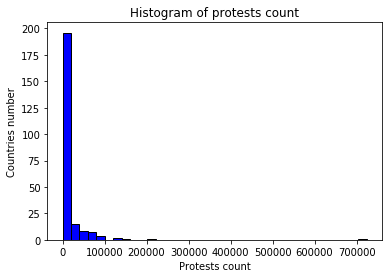

In [16]:
#counting the number of protests we have in each country
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

#Getting the distribution of protests count
plt.hist(number_of_protests_per_country['protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')


The distribution show that few countries have a very high number of protests. These countries, with a very high number, hids the nuance between other countries.

For instance, if a country A has 1 protests, a country B has 5000 protests and country C has 100 000 protests, we won't see any difference between country A and B in the visualization. A threshold or a log scale can resolve this issue.
We choose the log scale.

In [17]:
number_of_protests_per_country['log protests count'] = np.log10(number_of_protests_per_country['protests count'])

Visualizing result for log scale that allows to avoid loosing nuance between low values and between high values:

In [18]:
max_nb_protests = number_of_protests_per_country['protests count'].values.max()
colormap = linear.YlGn_09.scale(0, max_nb_protests)
colormap.caption = 'Number of protests since 2005'
location=[46.9,8.25]
x = 'Country Code'
y = 'protests count'

results_map_protests = folium_map(number_of_protests_per_country, x, y, location, countries_topodata, colormap, zoom=2)

results_map_protests.save(FOLIUM_MAPS_PATH + 'results_map_protests.html')
display(HTML("<h1><a href='"+FOLIUM_MAPS_PATH+"results_map_protests.html' target='_blank'>Map which displays the number of protests (Ctrl+Click)</a></h1>"))

results_map_protests

We cannot see any difference between the countries cause of the US which has many protests compare to the other. That's why we cannot see anything with and without a log scale. We thus choose to display this map without the US, to be able to see difference between the other countries:

### Same map without the US outlier

Remark: you can focus your mouse on each country to get his name.

In [19]:
Without_US = number_of_protests_per_country.loc[number_of_protests_per_country['Country Code'] != 'USA']
max_nb_protests = Without_US['protests count'].values.max()
min_nb_protests = Without_US['protests count'].values.min()
colormap = linear.YlGn_09.scale(min_nb_protests, max_nb_protests)
colormap.caption = 'Number of protests since 2005 without US'
location=[46.9,8.25]
x = 'Country Code'
y = 'protests count'

results_map_protests_without_US = folium_map(Without_US, x, y, location, countries_topodata, colormap, zoom=2)

results_map_protests_without_US.save(FOLIUM_MAPS_PATH + 'results_map_protests_without_US.html')
display(HTML("<h1><a href='"+FOLIUM_MAPS_PATH+"results_map_protests_without_US.html' target='_blank'>Map which displays the number of protests without_US (Ctrl+Click)</a></h1>"))

results_map_protests_without_US

Now, without the US, we can see difference between the other countries. We went deeper in our explanation on our blog: https://ada-project.school.blog/

## Animated world map: visualyzing the kind of protest
Displaying a dynamic world map which shows evolution day by day
I also allows to see which kind of protest it is thanks to color indicators

In [20]:
#Extracting ActionGeo_Lat and ActionGeo_Long
protests_without_duplicated_values = protests_df_location
#protests_without_duplicated_values['ActionGeo_Lat'] = protests_df_location['ActionGeo_Lat']
#protests_without_duplicated_values['ActionGeo_Long'] = protests_df_location['ActionGeo_Long']

#Removing duplicated values 
#The values are not really duplicated, they took place on different day
#however we don't want to display a circle within another, we only want to visualyze the kind of protest
#we will visualize the frequency on the next two maps
protests_without_duplicated_values=protests_without_duplicated_values.drop_duplicates(subset=['ActionGeo_Long', 'ActionGeo_Lat', 'EventCode'], keep=False)
protests_without_duplicated_values=protests_without_duplicated_values.sort_values('SQLDATE')
protests_without_duplicated_values = filtering_df_date_country(protests_without_duplicated_values,date_start = 20140325,date_end = 20150800)

In [21]:
#getting only the first 3 digits of event code because we don't mind the other, they provide useless information for our analysis
protests_without_duplicated_values['EventCode']= protests_without_duplicated_values['EventCode'].astype(str)
protests_without_duplicated_values['EventCode']= protests_without_duplicated_values['EventCode'].str[0:3]

In [22]:
#getting a df in an appropriate format
protests_df_for_js = pd.DataFrame()
protests_df_for_js["coord_for_js"] = '[' + protests_without_duplicated_values['ActionGeo_Lat'].astype(str) + ',' + protests_without_duplicated_values['ActionGeo_Long'].astype(str) + '],'
protests_df_for_js["dates"] = protests_without_duplicated_values['SQLDATE'].astype(str)
protests_df_for_js["dates"] = '[' + protests_df_for_js['dates'].str[0:4] + protests_df_for_js['dates'].str[4:6] + protests_df_for_js['dates'].str[6:8] + '],'
protests_df_for_js["event_code"] = protests_without_duplicated_values['EventCode'].astype(str)
protests_df_for_js["event_code"] = '[' + protests_df_for_js['event_code'] + '],'

In [23]:
#Updating the js script to display result on a dynamic world map
updating_js_script(protests_df_for_js, WORLD_MAP_TYPE_PATH, markers_speed=0.1)

In [24]:
display(HTML("<h1><a href='"+WORLD_MAP_TYPE_PATH+"index.html' target='_blank'>Animated map that displays protests day by day (Ctrl+Click)</a></h1>"))

The visualization above shows, day by day, each protest. We can see that, most of the time, the protest are a demonstrate or a rally. However, contrary to the rest of the world, in Europe, there a high percentage of protest related to politics. 

This kind of visualization allows to follow the protests' evolution and the type of each one (for rights, for a leadership change, is it a hunger strike, etc.)

Another information we could want is the frequency of each protest. To see it we choose a first implementation which shows the frequency through a color code:

## Animated world map: visualyzing the frequency
Displaying a dynamic world map which shows how often we get a protest on an area.
The color goes from white to green then black. Areas in white color means few protests took place here, black means the opposite.

In [25]:
protests_world_wanted = filtering_df_date_country(protests_df_location,date_start = 20150201,date_end = 20150220)
protests_world_wanted=protests_world_wanted.sort_values('SQLDATE')

In [26]:
#getting a dataframe with appropriate format
protests_world_wanted_for_js = getting_appropriate_format_df_for_js(protests_world_wanted)

In [27]:
#getting the number of time each value was repeted 
protests_world_wanted_for_js = adding_count_columns(protests_world_wanted_for_js)

In [28]:
protests_world_wanted_for_js['colors'] = ""
max_value = protests_world_wanted_for_js['count'].max()
min_value = protests_world_wanted_for_js['count'].min()
index = 0
for value in protests_world_wanted_for_js['coord_for_js']:
    number = protests_world_wanted_for_js['count'].iloc[index]
    protests_world_wanted_for_js.iloc[index, protests_world_wanted_for_js.columns.get_loc('colors')] = converting_count_to_color(min_value, max_value, number)
    index = index + 1

In [29]:
protests_world_wanted_for_js['colors'] = protests_world_wanted_for_js['colors'].astype(str)
protests_world_wanted_for_js["colors"] = '[' + protests_world_wanted_for_js['colors'] + '],'
for col in protests_world_wanted_for_js:
    protests_world_wanted_for_js[col] = protests_world_wanted_for_js[col].astype(str)

In [30]:
updating_js_script(protests_world_wanted_for_js, WORLD_MAP_FREQ_PATH, markers_number = 15, markers_speed=500)

In [31]:
display(HTML("<h1><a href='"+WORLD_MAP_FREQ_PATH+"index.html' target='_blank'>Animated map that displays protests day by day (Ctrl+Click)</a></h1>"))

Thanks to the visualization above, we can easily detect where the protests most appear. Let's take a relevant example: US presidential election period:

In [32]:
display(HTML("<h1><a href='"+US_MAP_FREQ_PATH+"index.html' target='_blank'>Animated map that displays protests day by day (Ctrl+Click)</a></h1>"))

This visualization allow to know where the protests were the most frequent. We can guess that it correspond to the Clinton's electorate, we thus could locate the Clinton's electorate thanks to this visualization. We did this analysis on our blog: https://ada-project.school.blog/

## Animated map per country
Displaying a map focused on a country.

By showing the frequency with colors, we lost the information of the protests' kind. For the next kind of visualization, we kept the color code for the protests' type but we changed the way we are showing the frequency. We increased the circles' size each time a protest goes to a locate where other protests went.

In [33]:
country_wanted = "United States"

In [34]:
country_location = pd.read_csv(DATA_PATH + 'country_lat_long.csv')
for cln in country_location:
    country_location[cln] = country_location[cln].astype(str)
country_location['LatLong'] = '['+country_location['Latitude']+','+country_location['Longitude']+']'

In [35]:
s = pd.Series(country_location['Country Name'])
if country_wanted in s.unique():
    latlong = country_location[country_location['Country Name'].str.contains(country_wanted)]['LatLong']
    latlong = latlong.iloc[0]
else: 
    print("Country wanted doesn't exist")
protests_wanted = filtering_df_date_country(protests_df_location,date_start = 20160101,date_end = 20160201, country = country_wanted)

In [36]:
protests_wanted=protests_wanted.sort_values('SQLDATE')
protests_wanted['count'] = 0

In [37]:
#getting a dataframe with appropriate format
protests_wanted_for_js = getting_appropriate_format_df_for_js(protests_wanted)
#getting the number of time each value was repeted 
protests_wanted_for_js = adding_count_columns(protests_wanted_for_js)
protests_wanted_for_js['count'] = protests_wanted_for_js['count'].astype(str)
protests_wanted_for_js["count"] = '[' + protests_wanted_for_js['count'] + '],'

In [38]:
updating_js_script(protests_wanted_for_js, COUNTRY_MAP_PATH, markers_number=7, markers_speed=0.1, zoom="4", LatLong=latlong)

In [39]:
display(HTML("<h1><a href='"+COUNTRY_MAP_PATH+"index.html' target='_blank'>Animated map which displays protests day by day in "+ country_wanted + " (Ctrl+Click)</a></h1>"))

Thanks to the visualization above we can visualize the frequency AND the protests' type.
We adapt this map to a case study at the end of the notebook.

### Is there any correlation between number of protests and other statistics?

### Visualization by GDP growth 

In [40]:
data = gdp_df
countries_all_stats = country_stat_creation(protests_df,country_by_income_2017,countries_stats,country_codes_to_name)
data['2018'] = data['2017']
data = data.drop(['2014','2015'],1)
country_region = countries_all_stats[['Country Name','Region']]
data=pd.merge(data,country_region , how='right', on=['Country Name'])
data = data.dropna()
data=data.drop(data.columns[[2, 3, 4, 5, 6, 7 ,8, 9, 10]], axis=1)  # df.columns is zero-based pd.Index
data = convert_year_columns_to_one(data)
data.head()

C:\Users\bronner\Miniconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Country Name                         Region  GDP growth    year
0  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201601
0  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201602
0  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201603
0  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201604
0  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201605

In [41]:
data['key_'] = data['Country Name'] + data['year'].astype(str)
protests = pd.read_csv(DATA_PATH + 'protests_location.csv')
protests['SQLDATE'] = protests['SQLDATE'].astype(str)
protests['SQLDATE'] = protests['SQLDATE'].str[0:6]
protests['ActionGeo_FullName'] = protests['ActionGeo_FullName'].str.split(', ').str[-1]
protests = protests.drop('ActionGeo_Lat', 1)
protests = protests.drop('ActionGeo_Long', 1)
protests=protests.groupby(['ActionGeo_FullName', 'SQLDATE']).agg(['count'])
protests = protests.reset_index()
protests = protests[protests['ActionGeo_FullName'] != ',']

In [42]:
protests=protests[protests['SQLDATE'].astype(int) > 201500]
protests=protests.sort_values(['ActionGeo_FullName','SQLDATE'])
protests.columns = ['Country Name', 'year', 'count']
protests['key_'] = protests['Country Name'] + protests['year'].astype(str)

In [43]:
for i in protests['key_'].unique():
    if i in data['key_'].unique():
        continue
    else:
        protests = protests[protests['key_'] != i]

In [44]:
temp_pro = protests[['key_','count']]
data_=pd.merge(data,temp_pro , how='right', on=['key_'])
country_pop_density = countries_all_stats[['Country Name','Pop. Density (per sq. mi.)']]
data_=pd.merge(data_,country_pop_density , how='right', on=['Country Name'])
data_ = data_.rename(columns={'Pop. Density (per sq. mi.)': 'pop_density'})
data_['log_pop_density'] = np.log(data_['pop_density'])
data_.head()

Country Name                         Region  GDP growth    year  \
0  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201601   
1  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201602   
2  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201603   
3  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201604   
4  Afghanistan  ASIA (EX. NEAR EAST)             2.366712  201605   

                key_  count  pop_density  log_pop_density  
0  Afghanistan201601  229.0         48.0         3.871201  
1  Afghanistan201602  364.0         48.0         3.871201  
2  Afghanistan201603  353.0         48.0         3.871201  
3  Afghanistan201604  308.0         48.0         3.871201  
4  Afghanistan201605  740.0         48.0         3.871201

In [45]:
countries_region = pd.read_csv(DATA_PATH + 'countries_regions.csv')
data_ =pd.merge(data_,countries_region , how='right', left_on=['Country Name'], right_on=['name'])

In [46]:
sns.set_style("white")
new_data = data_
new_data['region']=pd.Categorical(new_data['region'])
new_data['region'].unique()

[Asia, Europe, Americas, Oceania, Africa, NaN]
Categories (5, object): [Asia, Europe, Americas, Oceania, Africa]

C:\Users\bronner\Miniconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


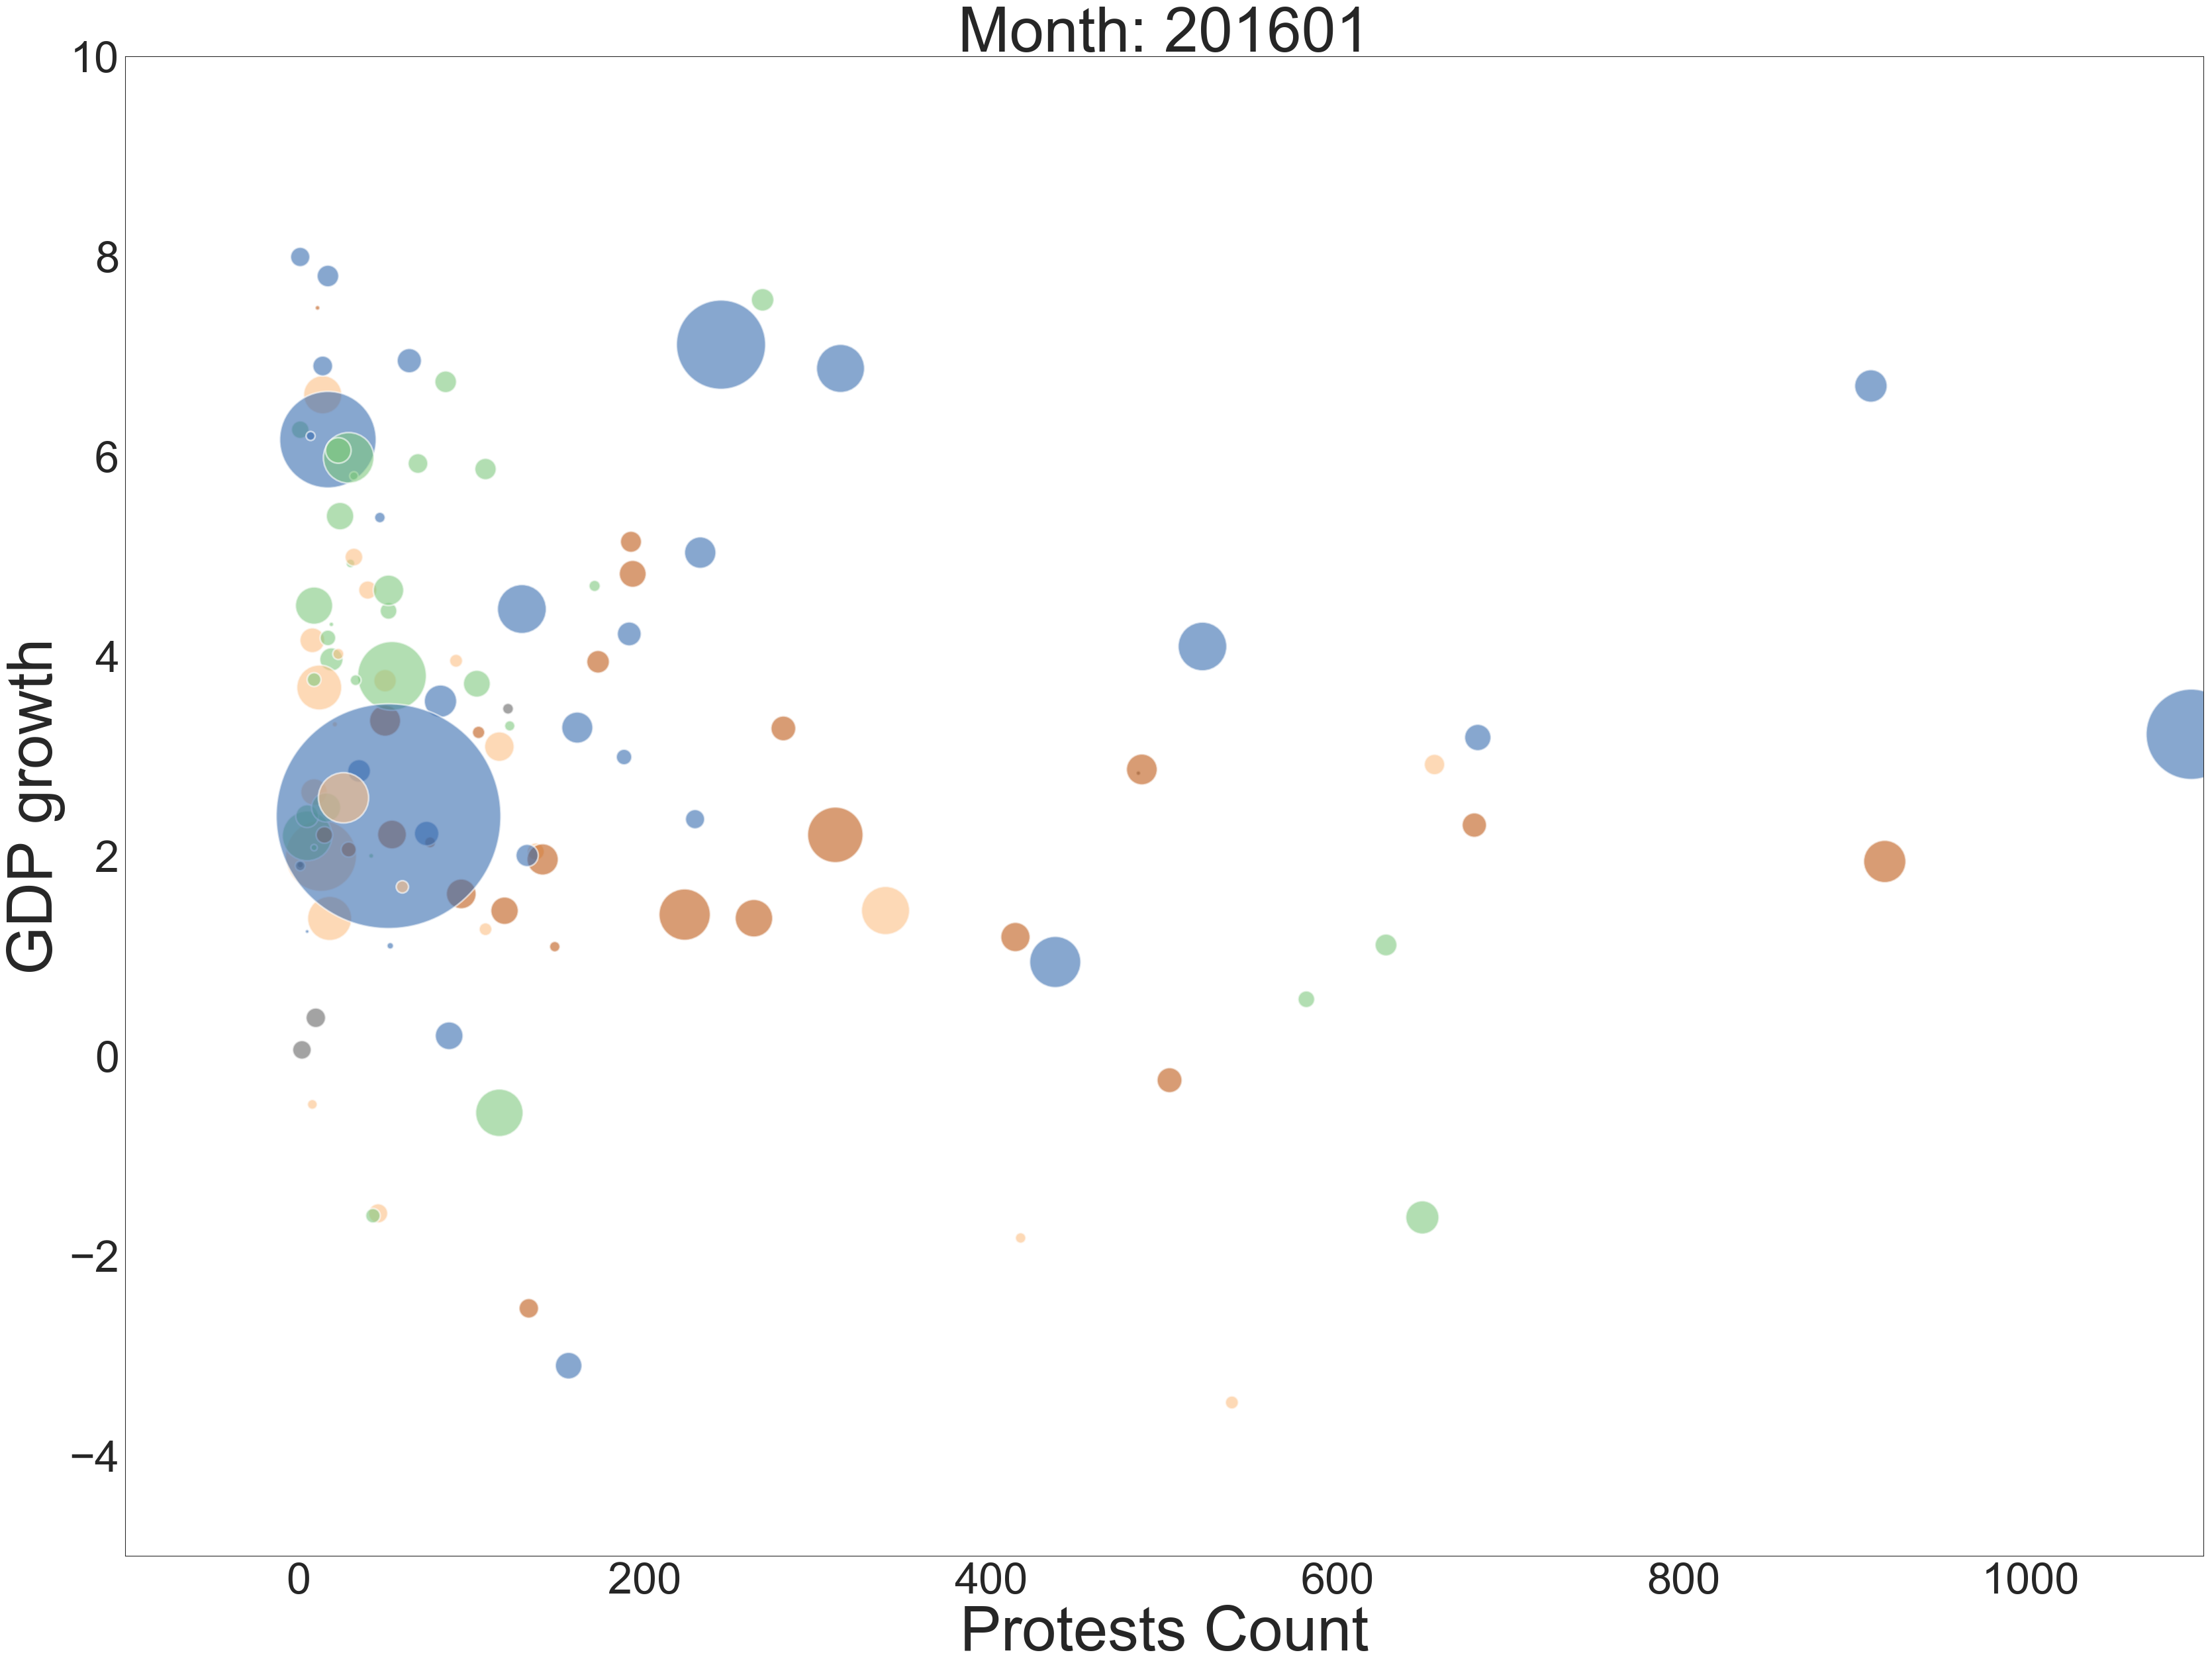

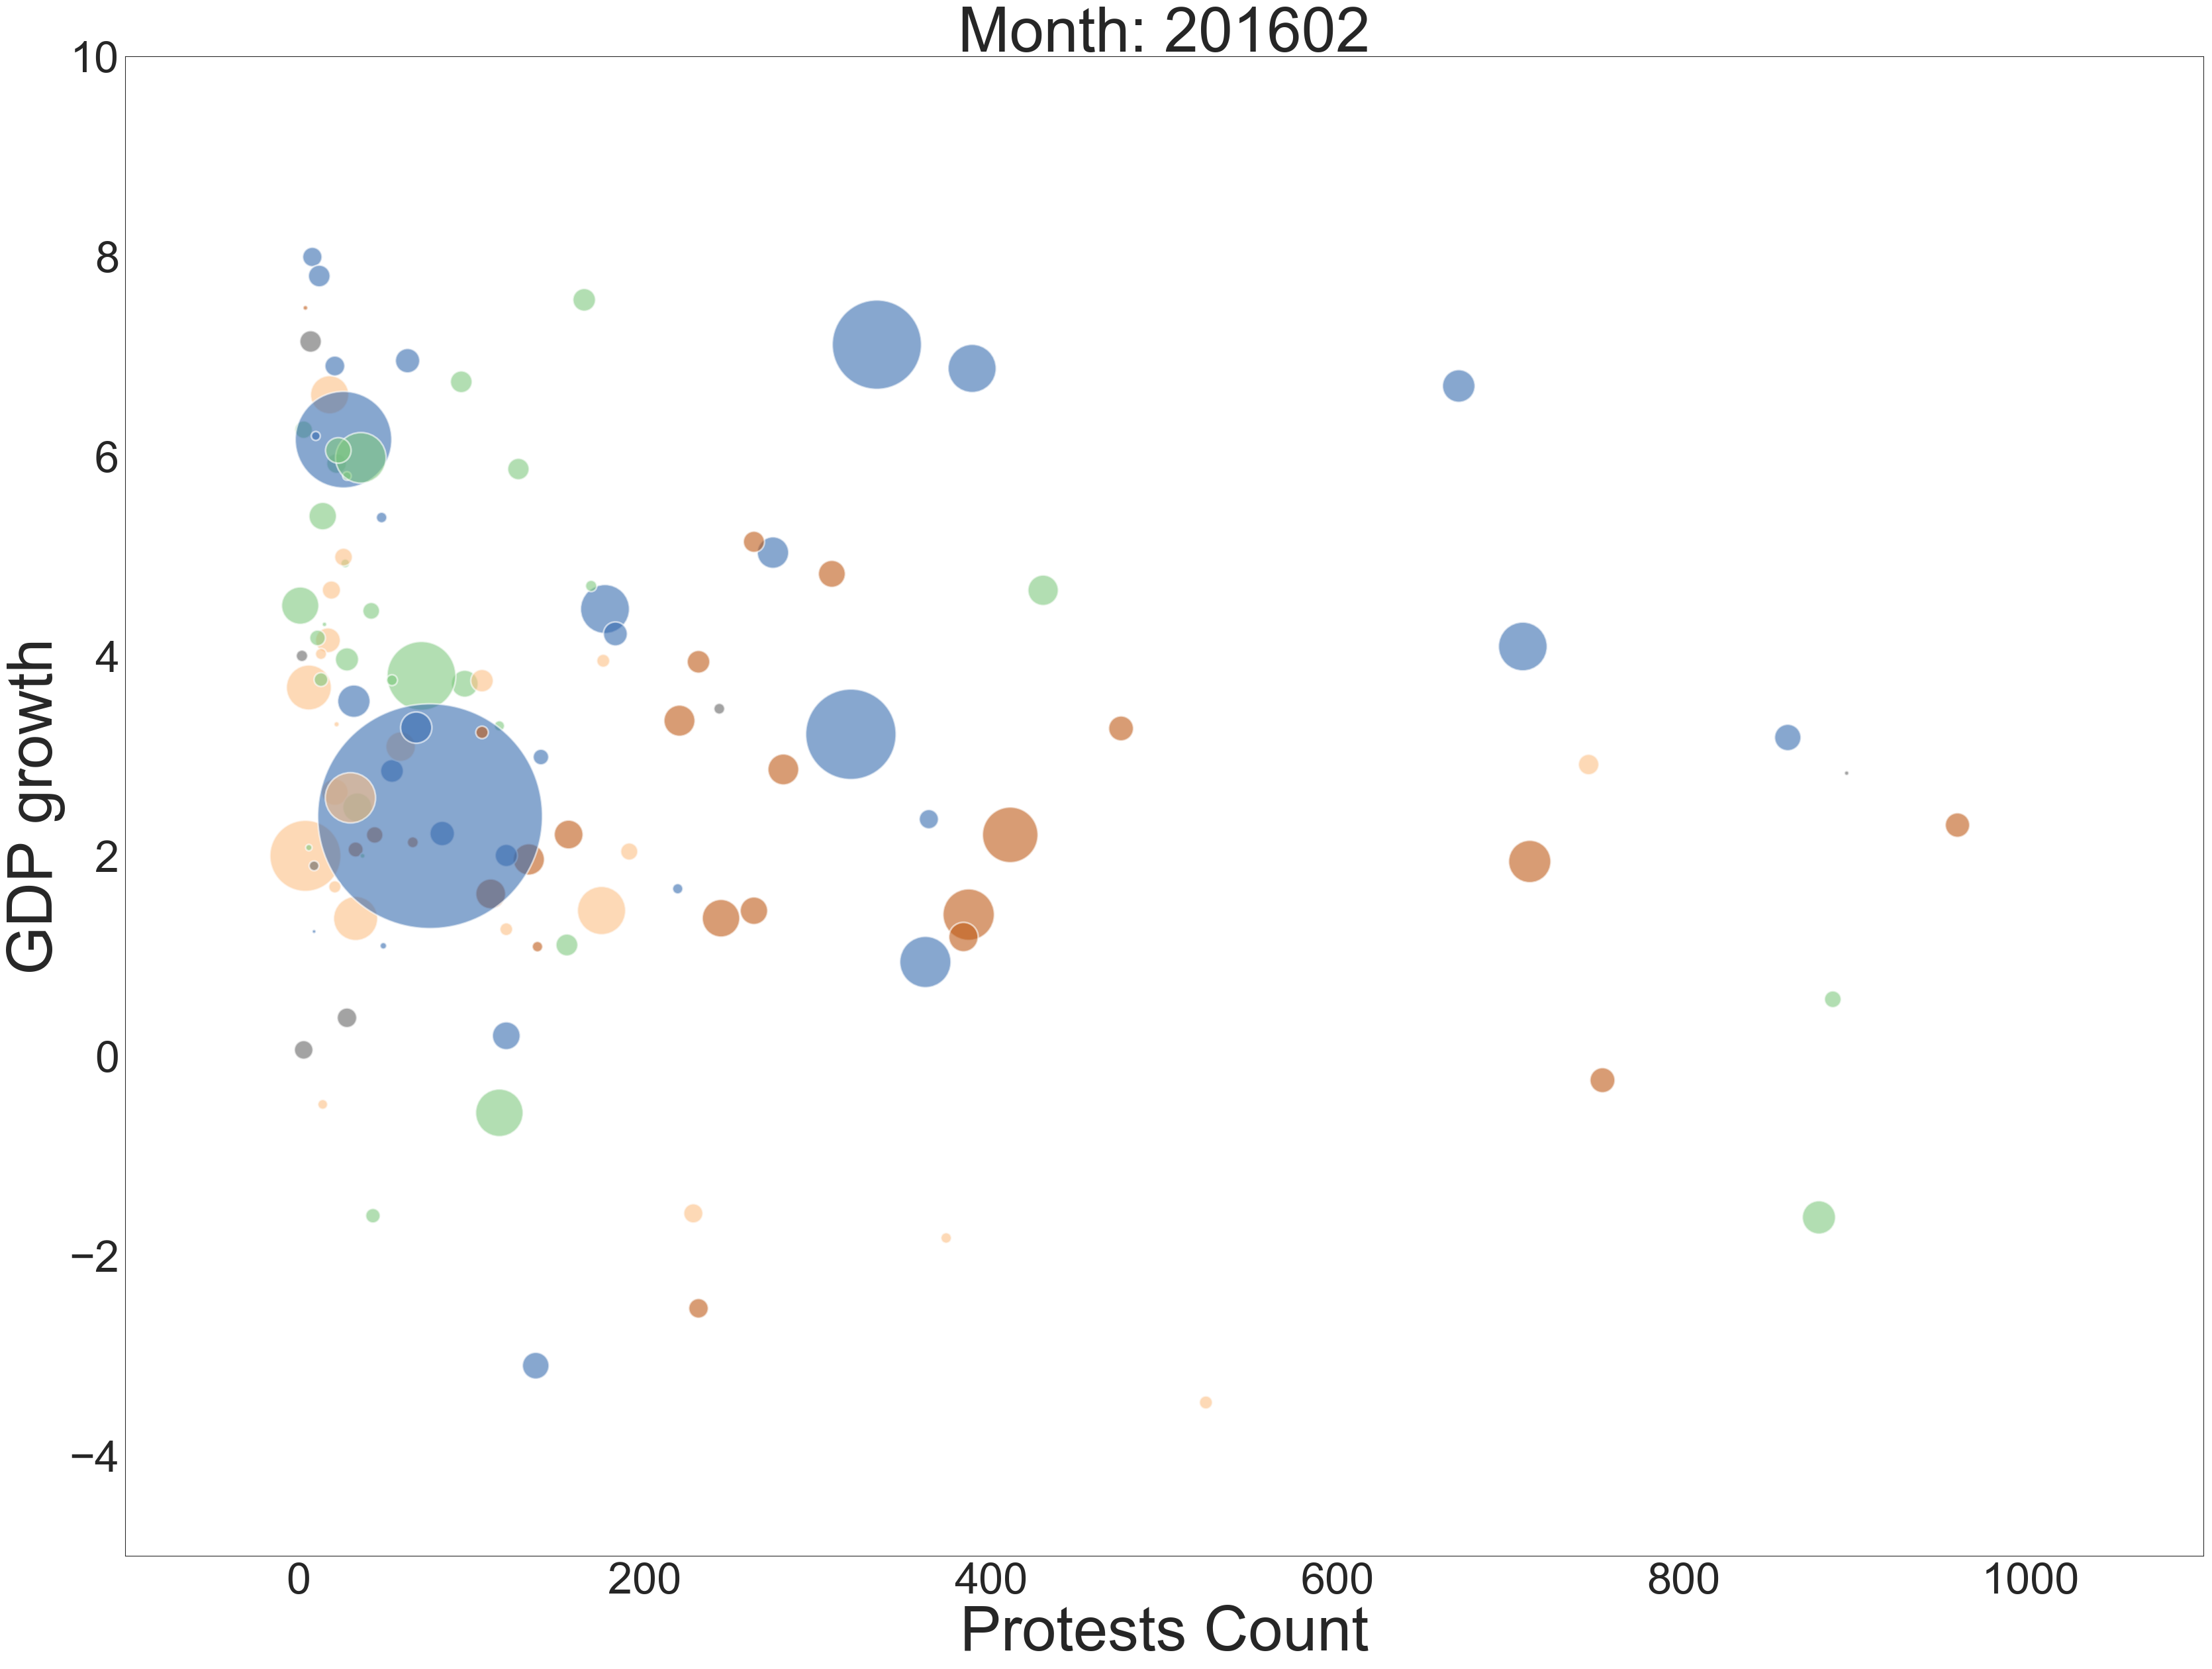

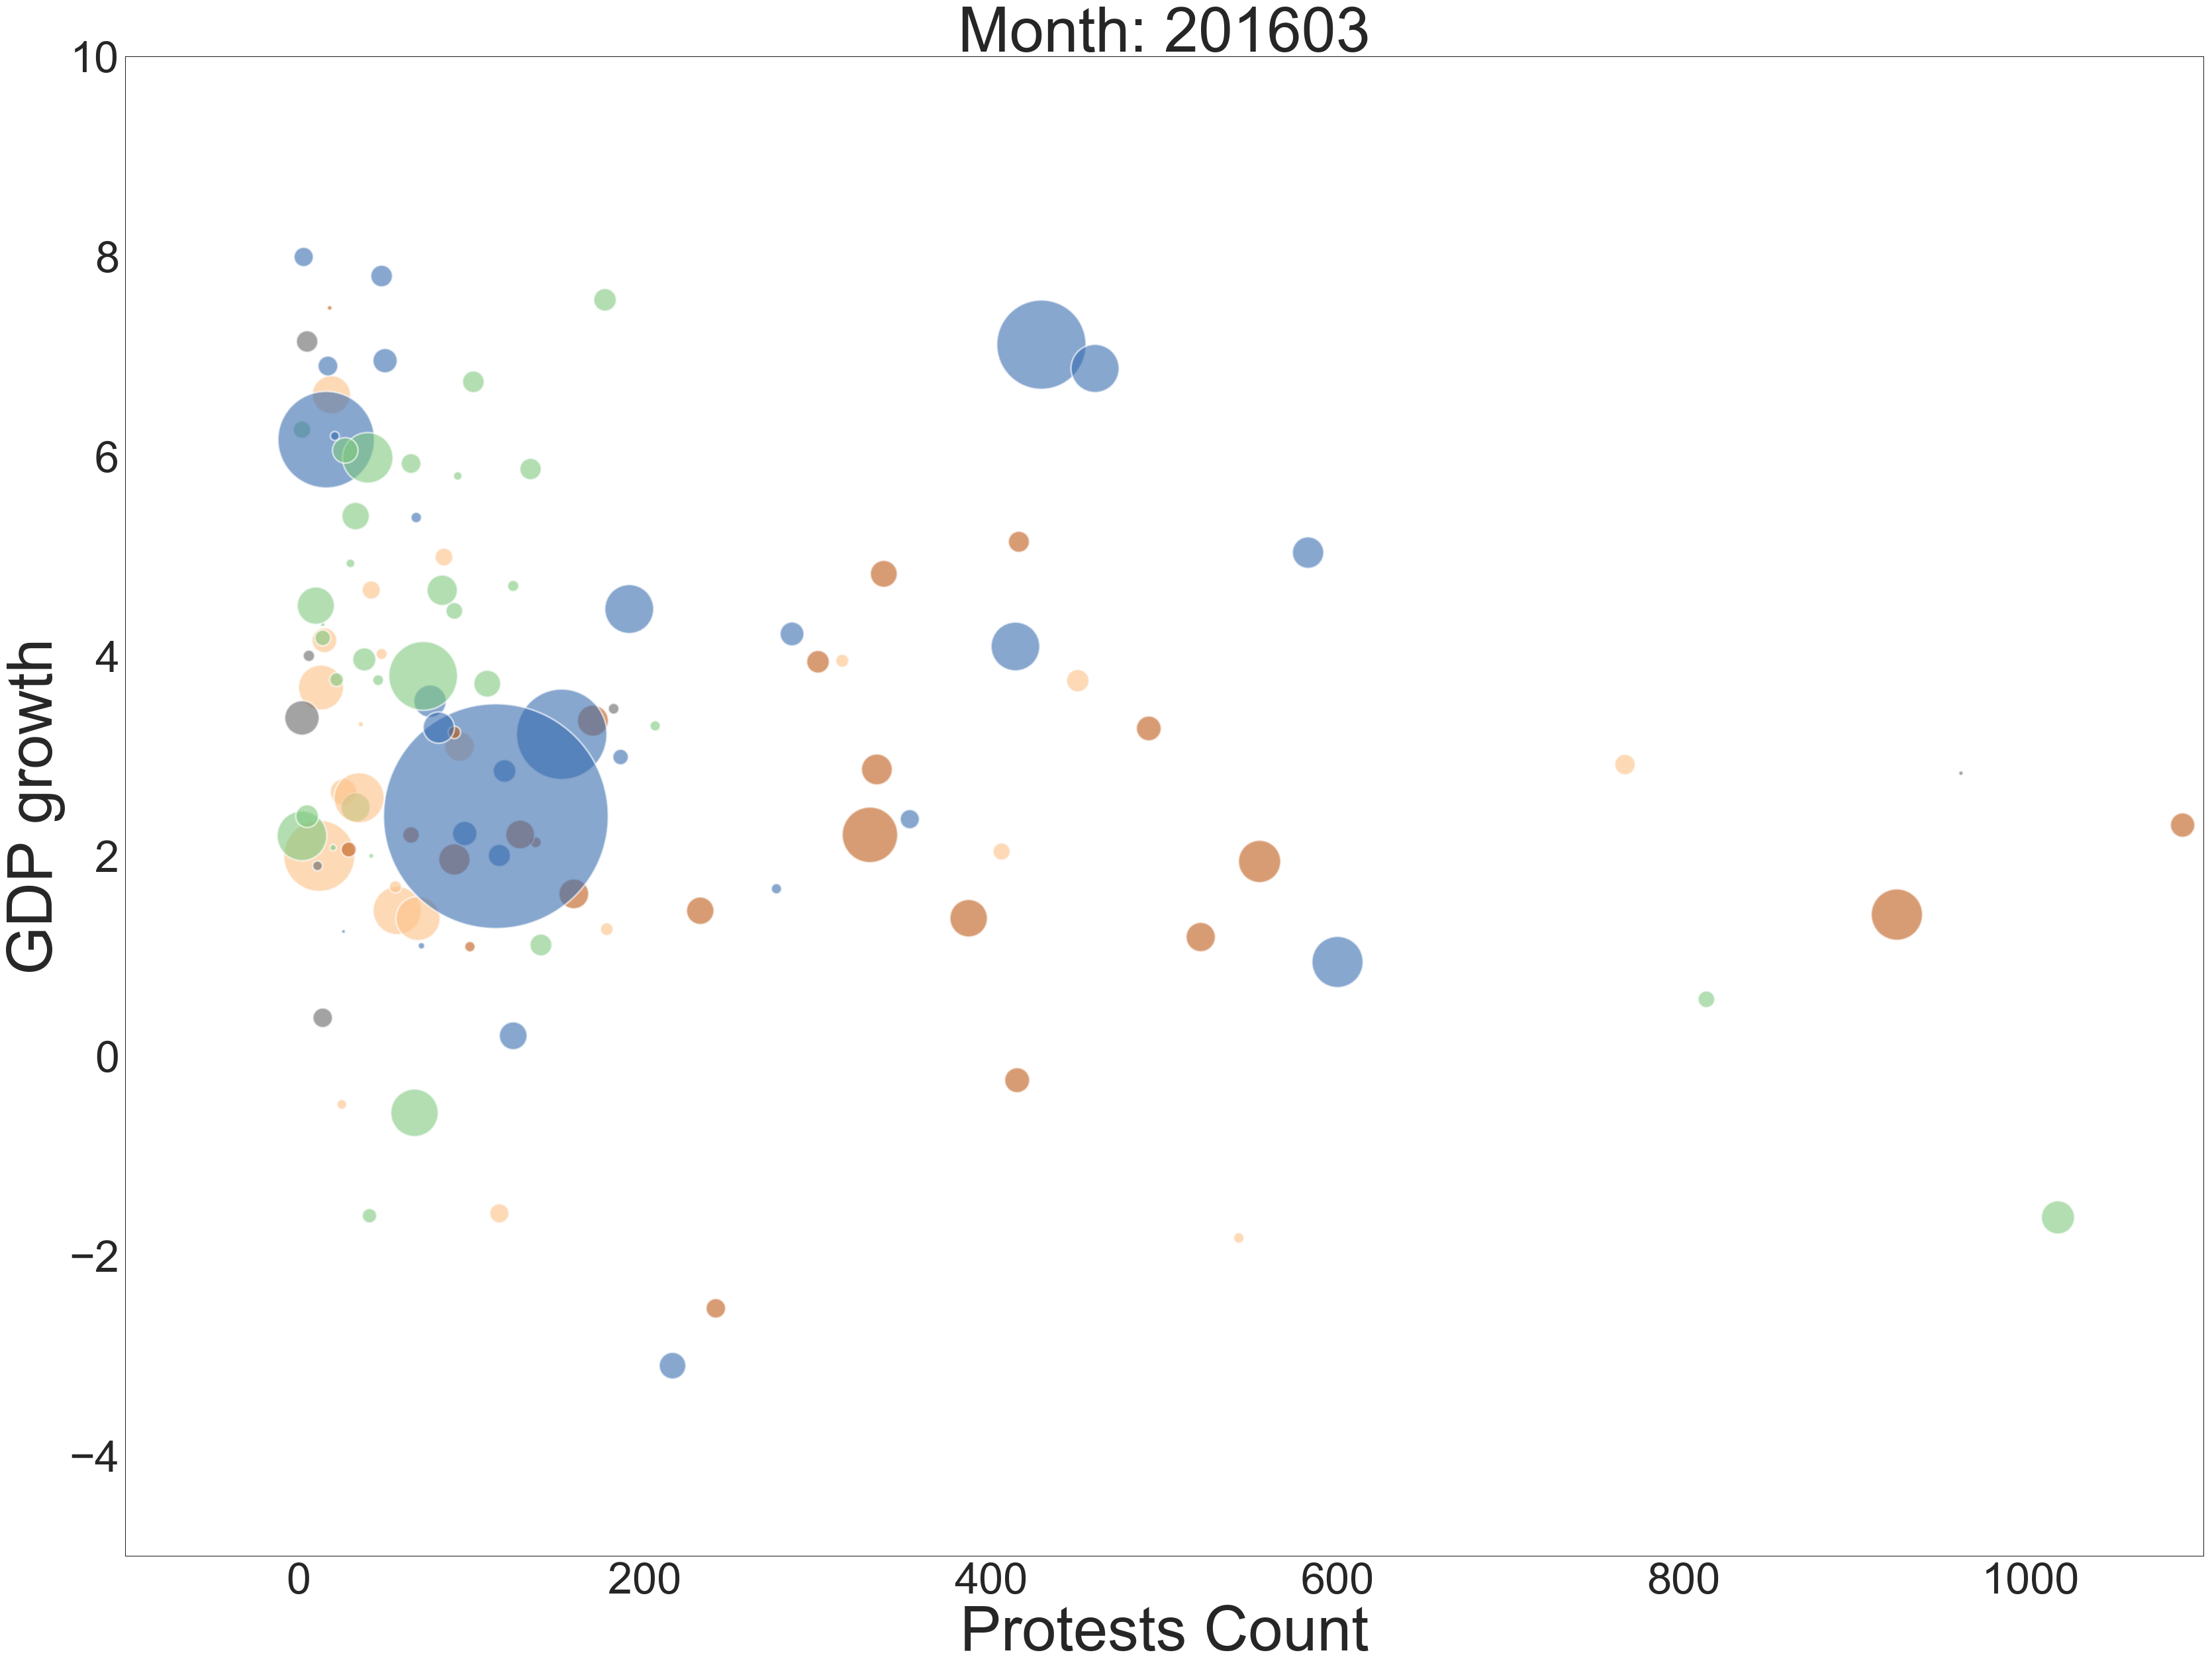

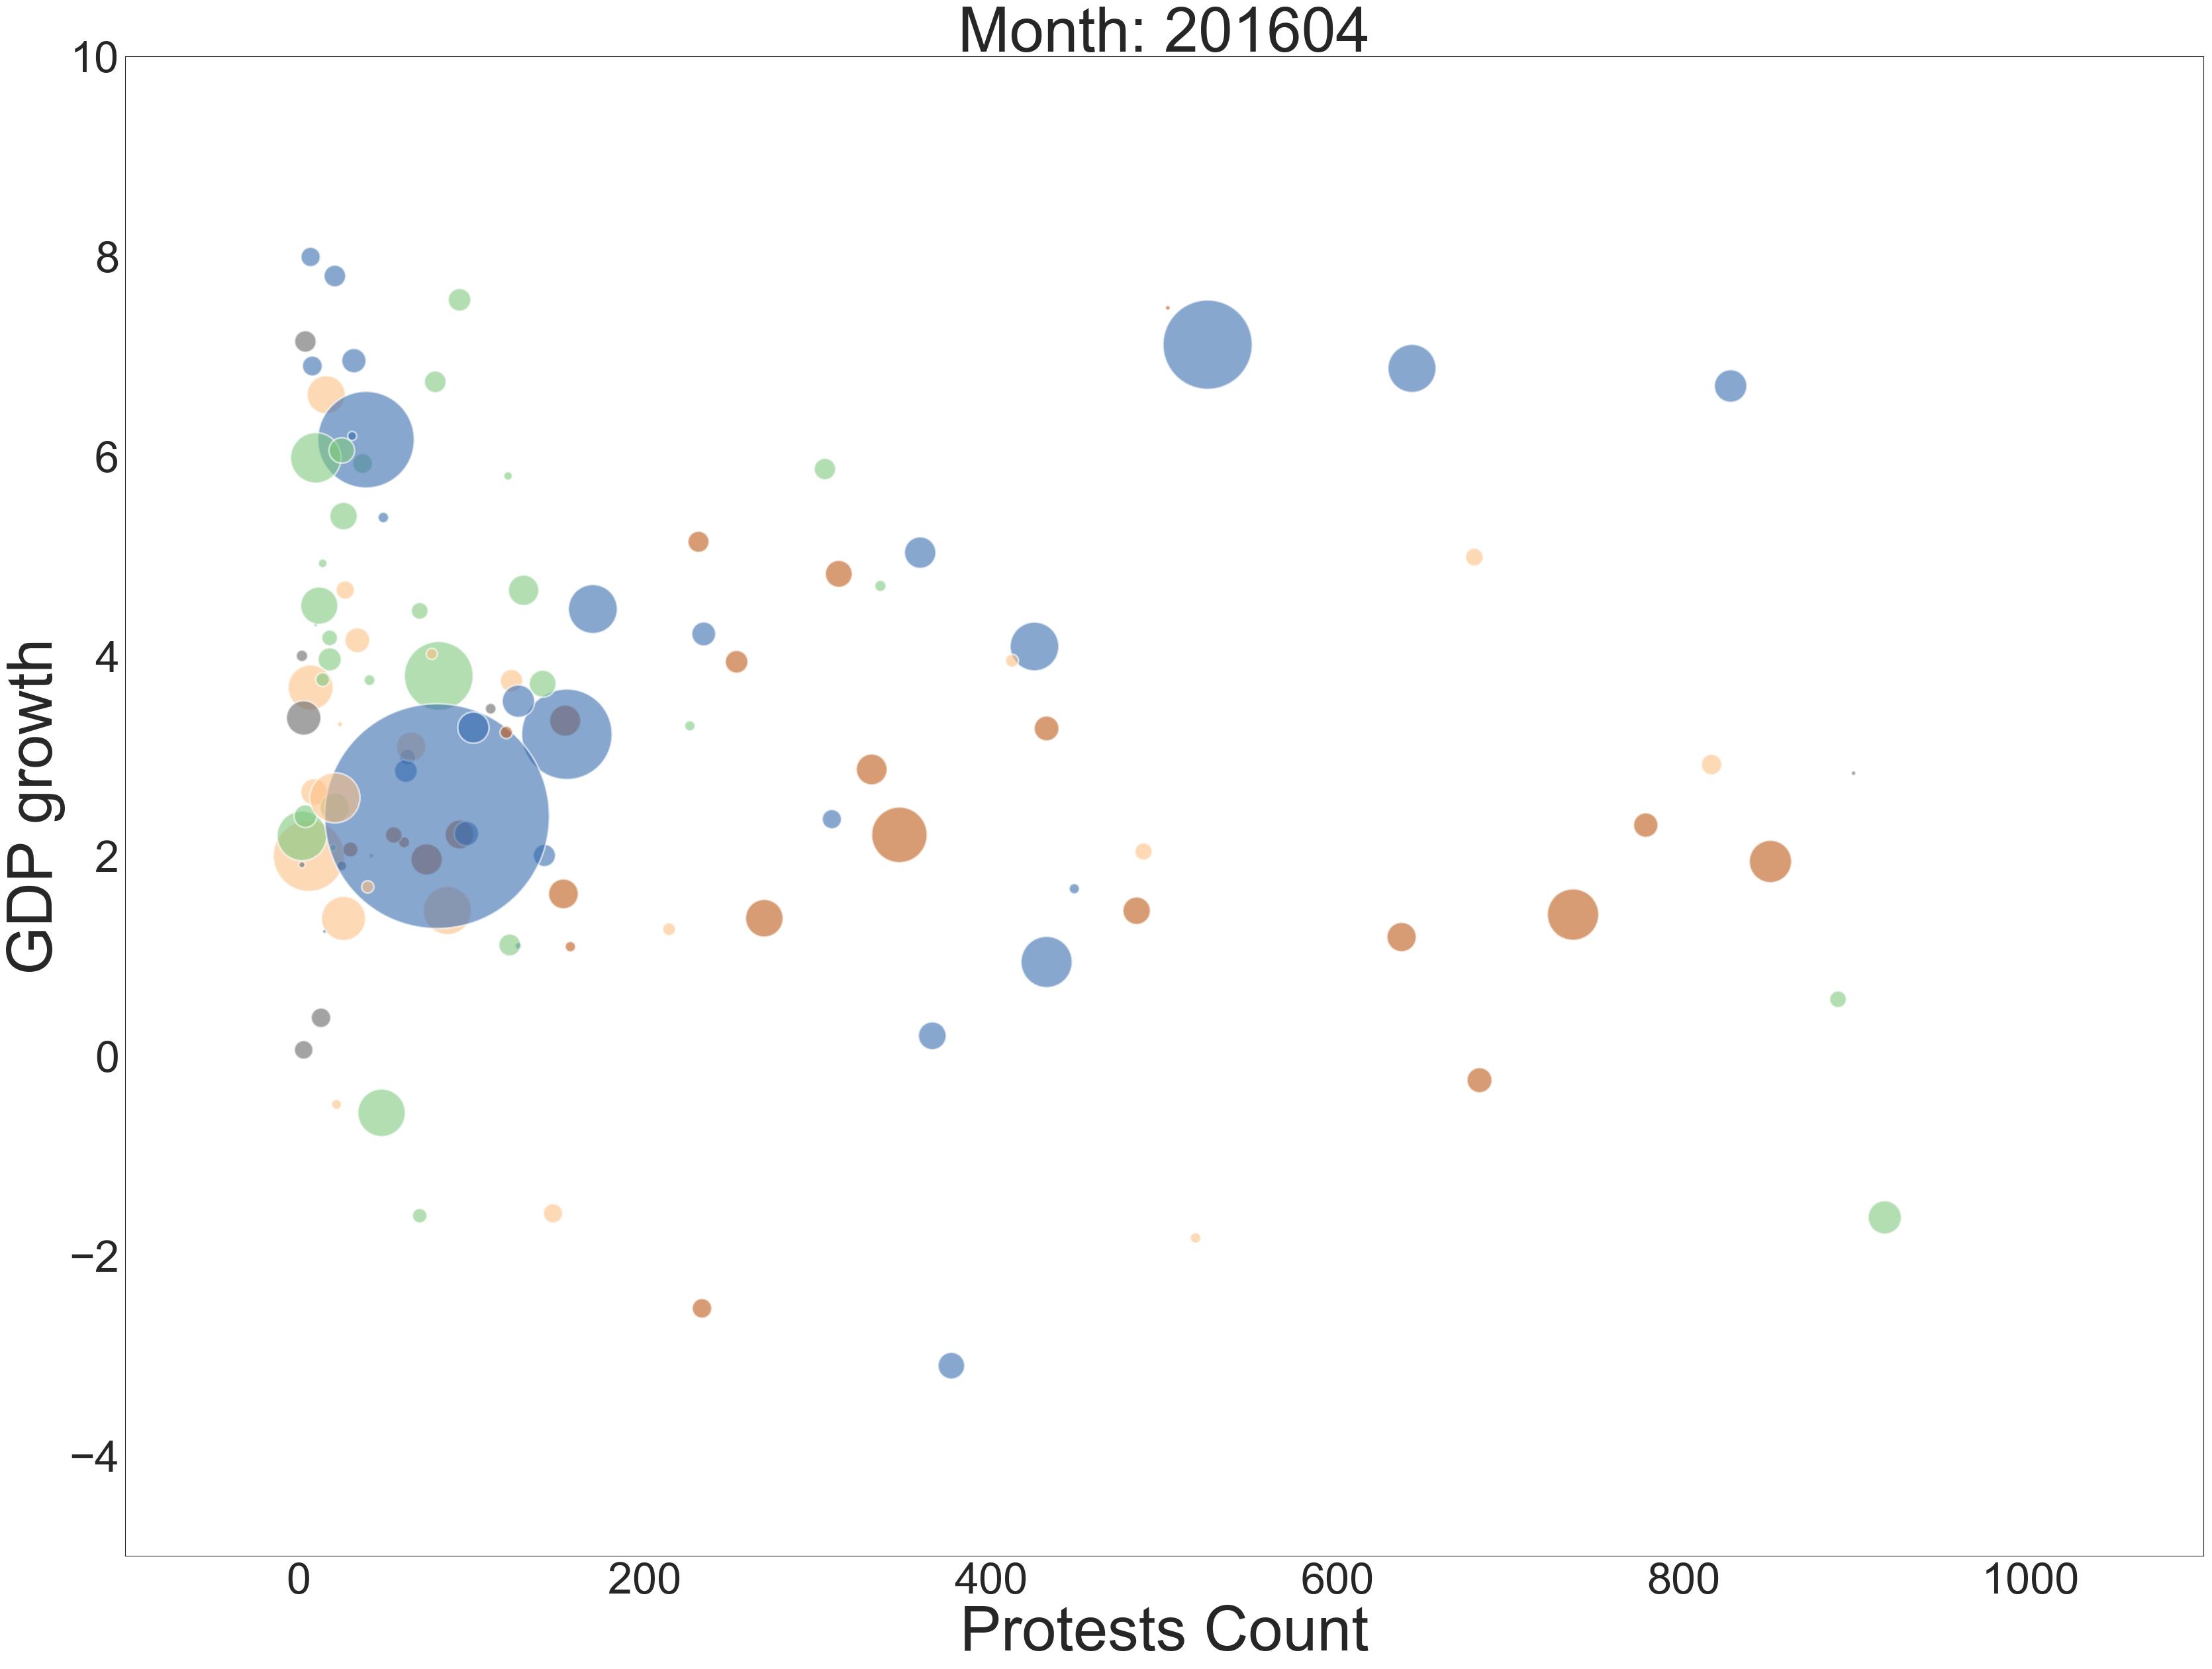

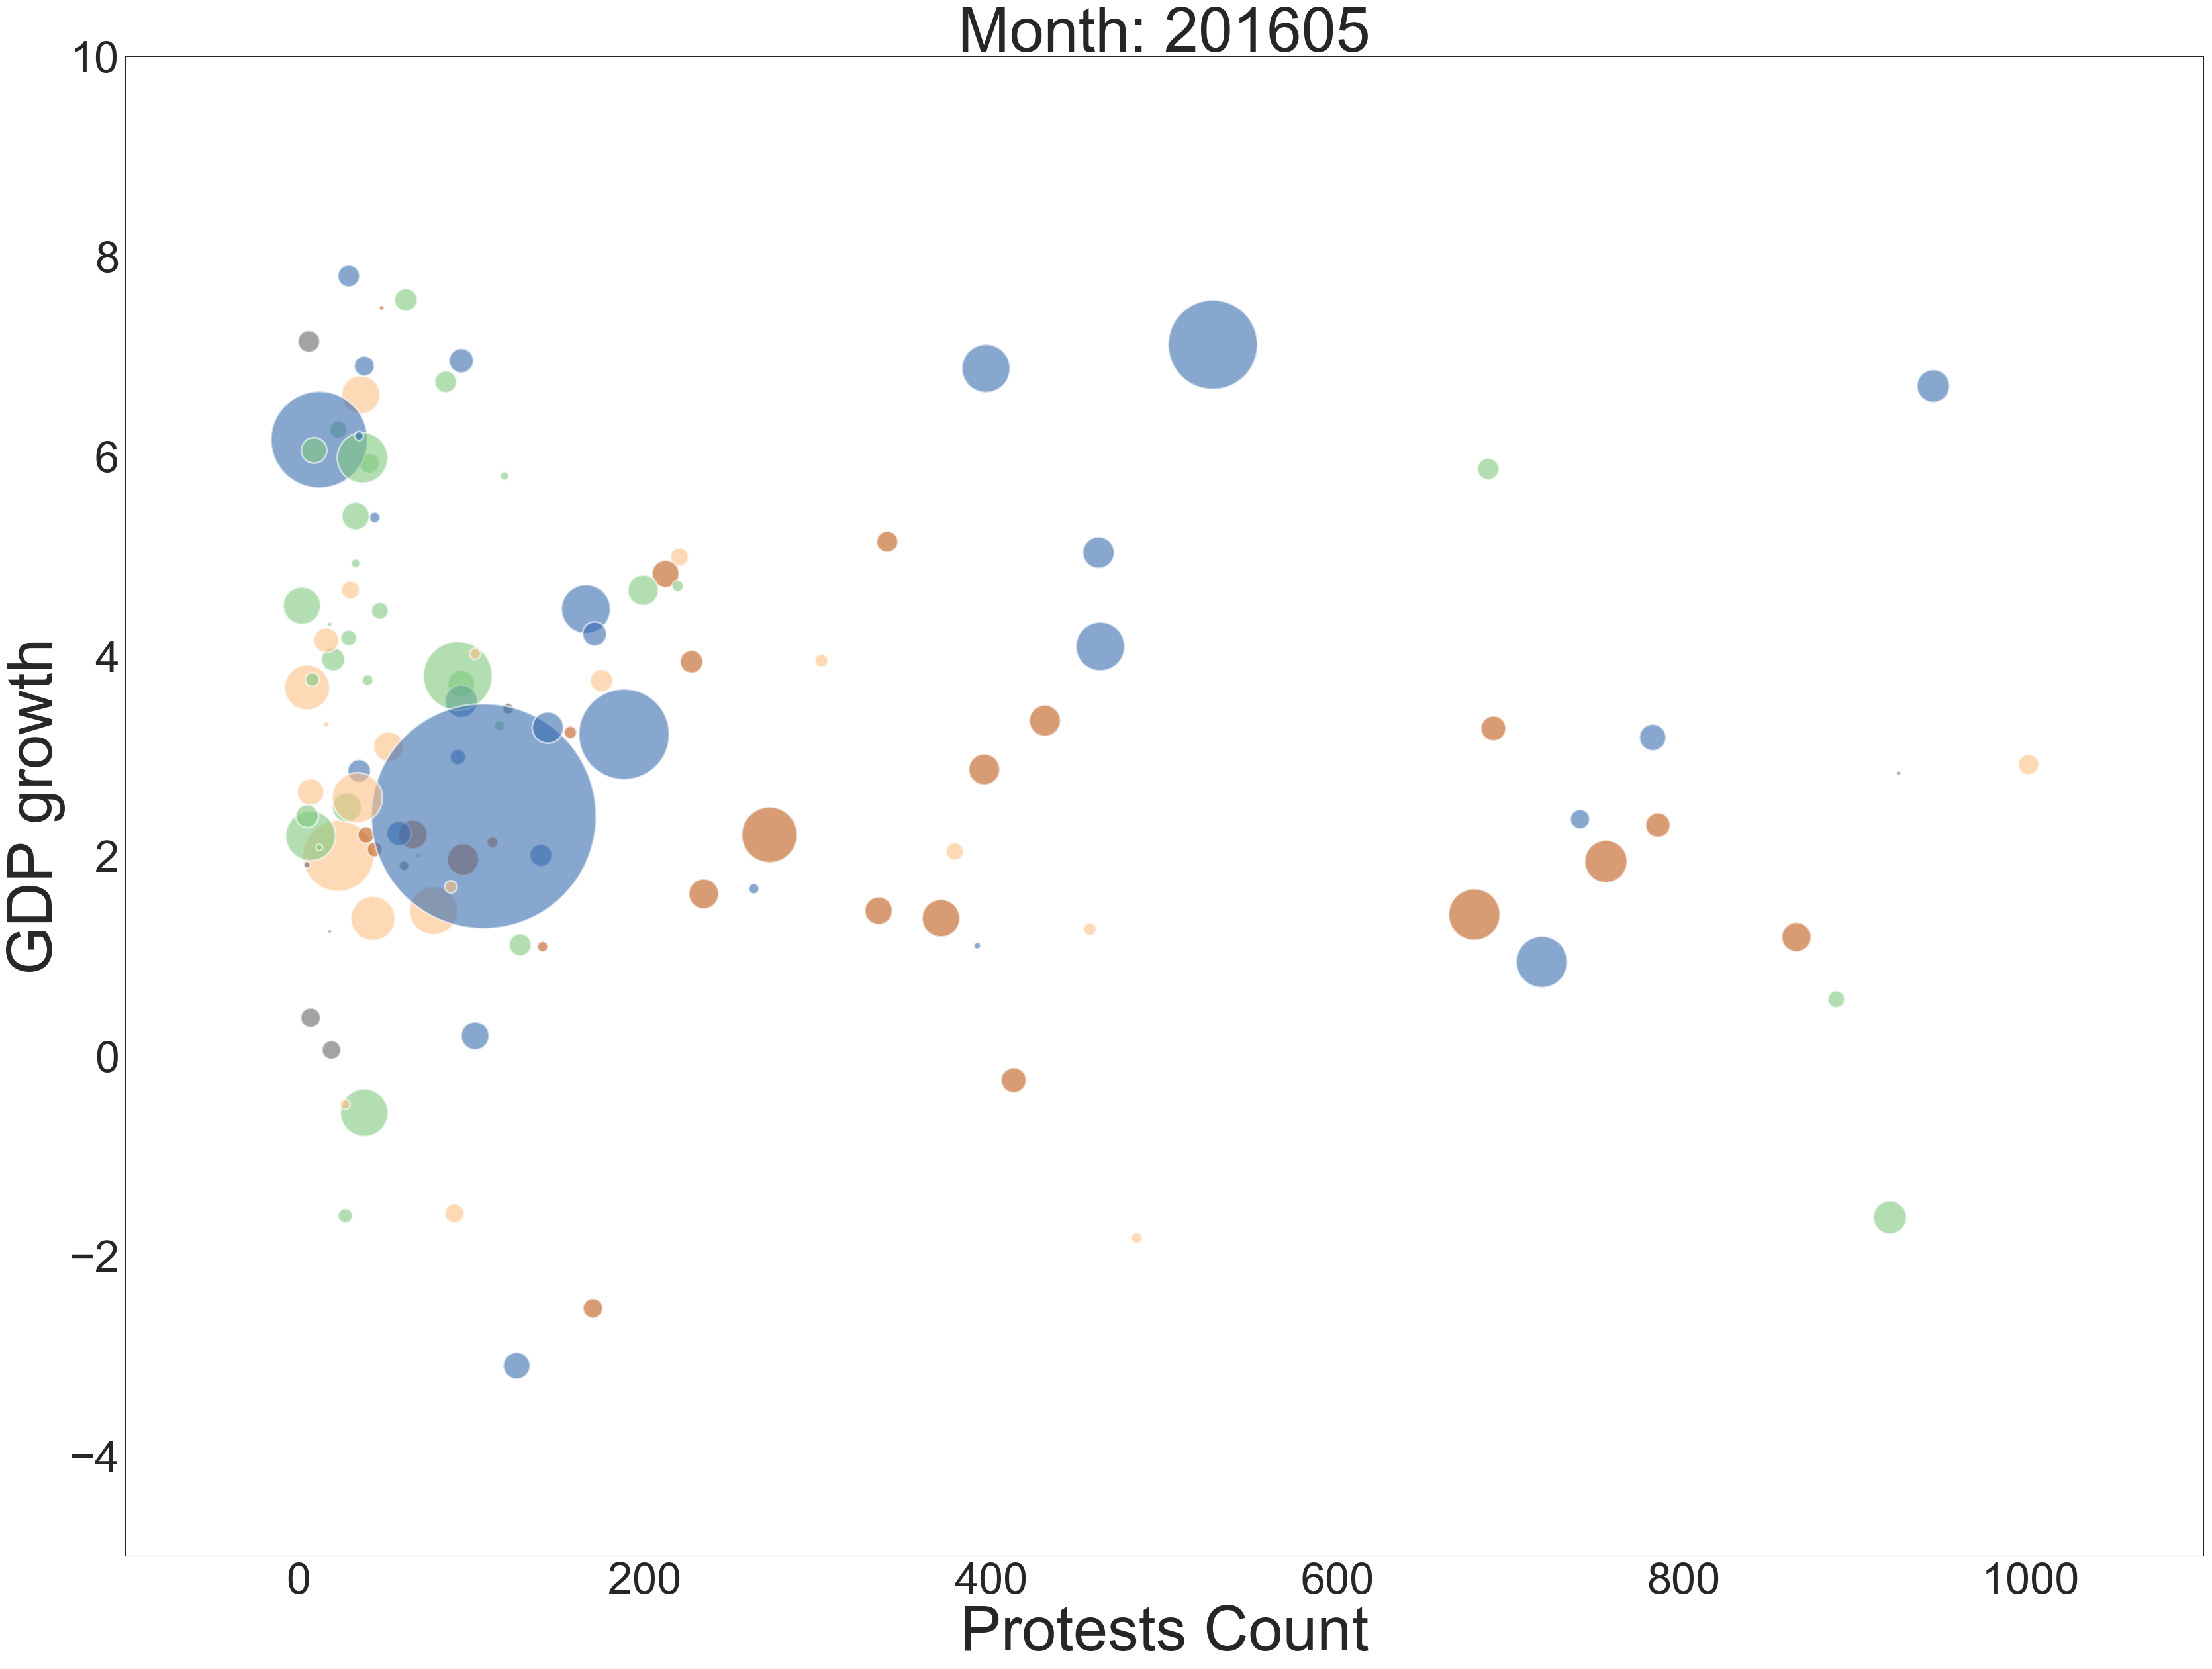

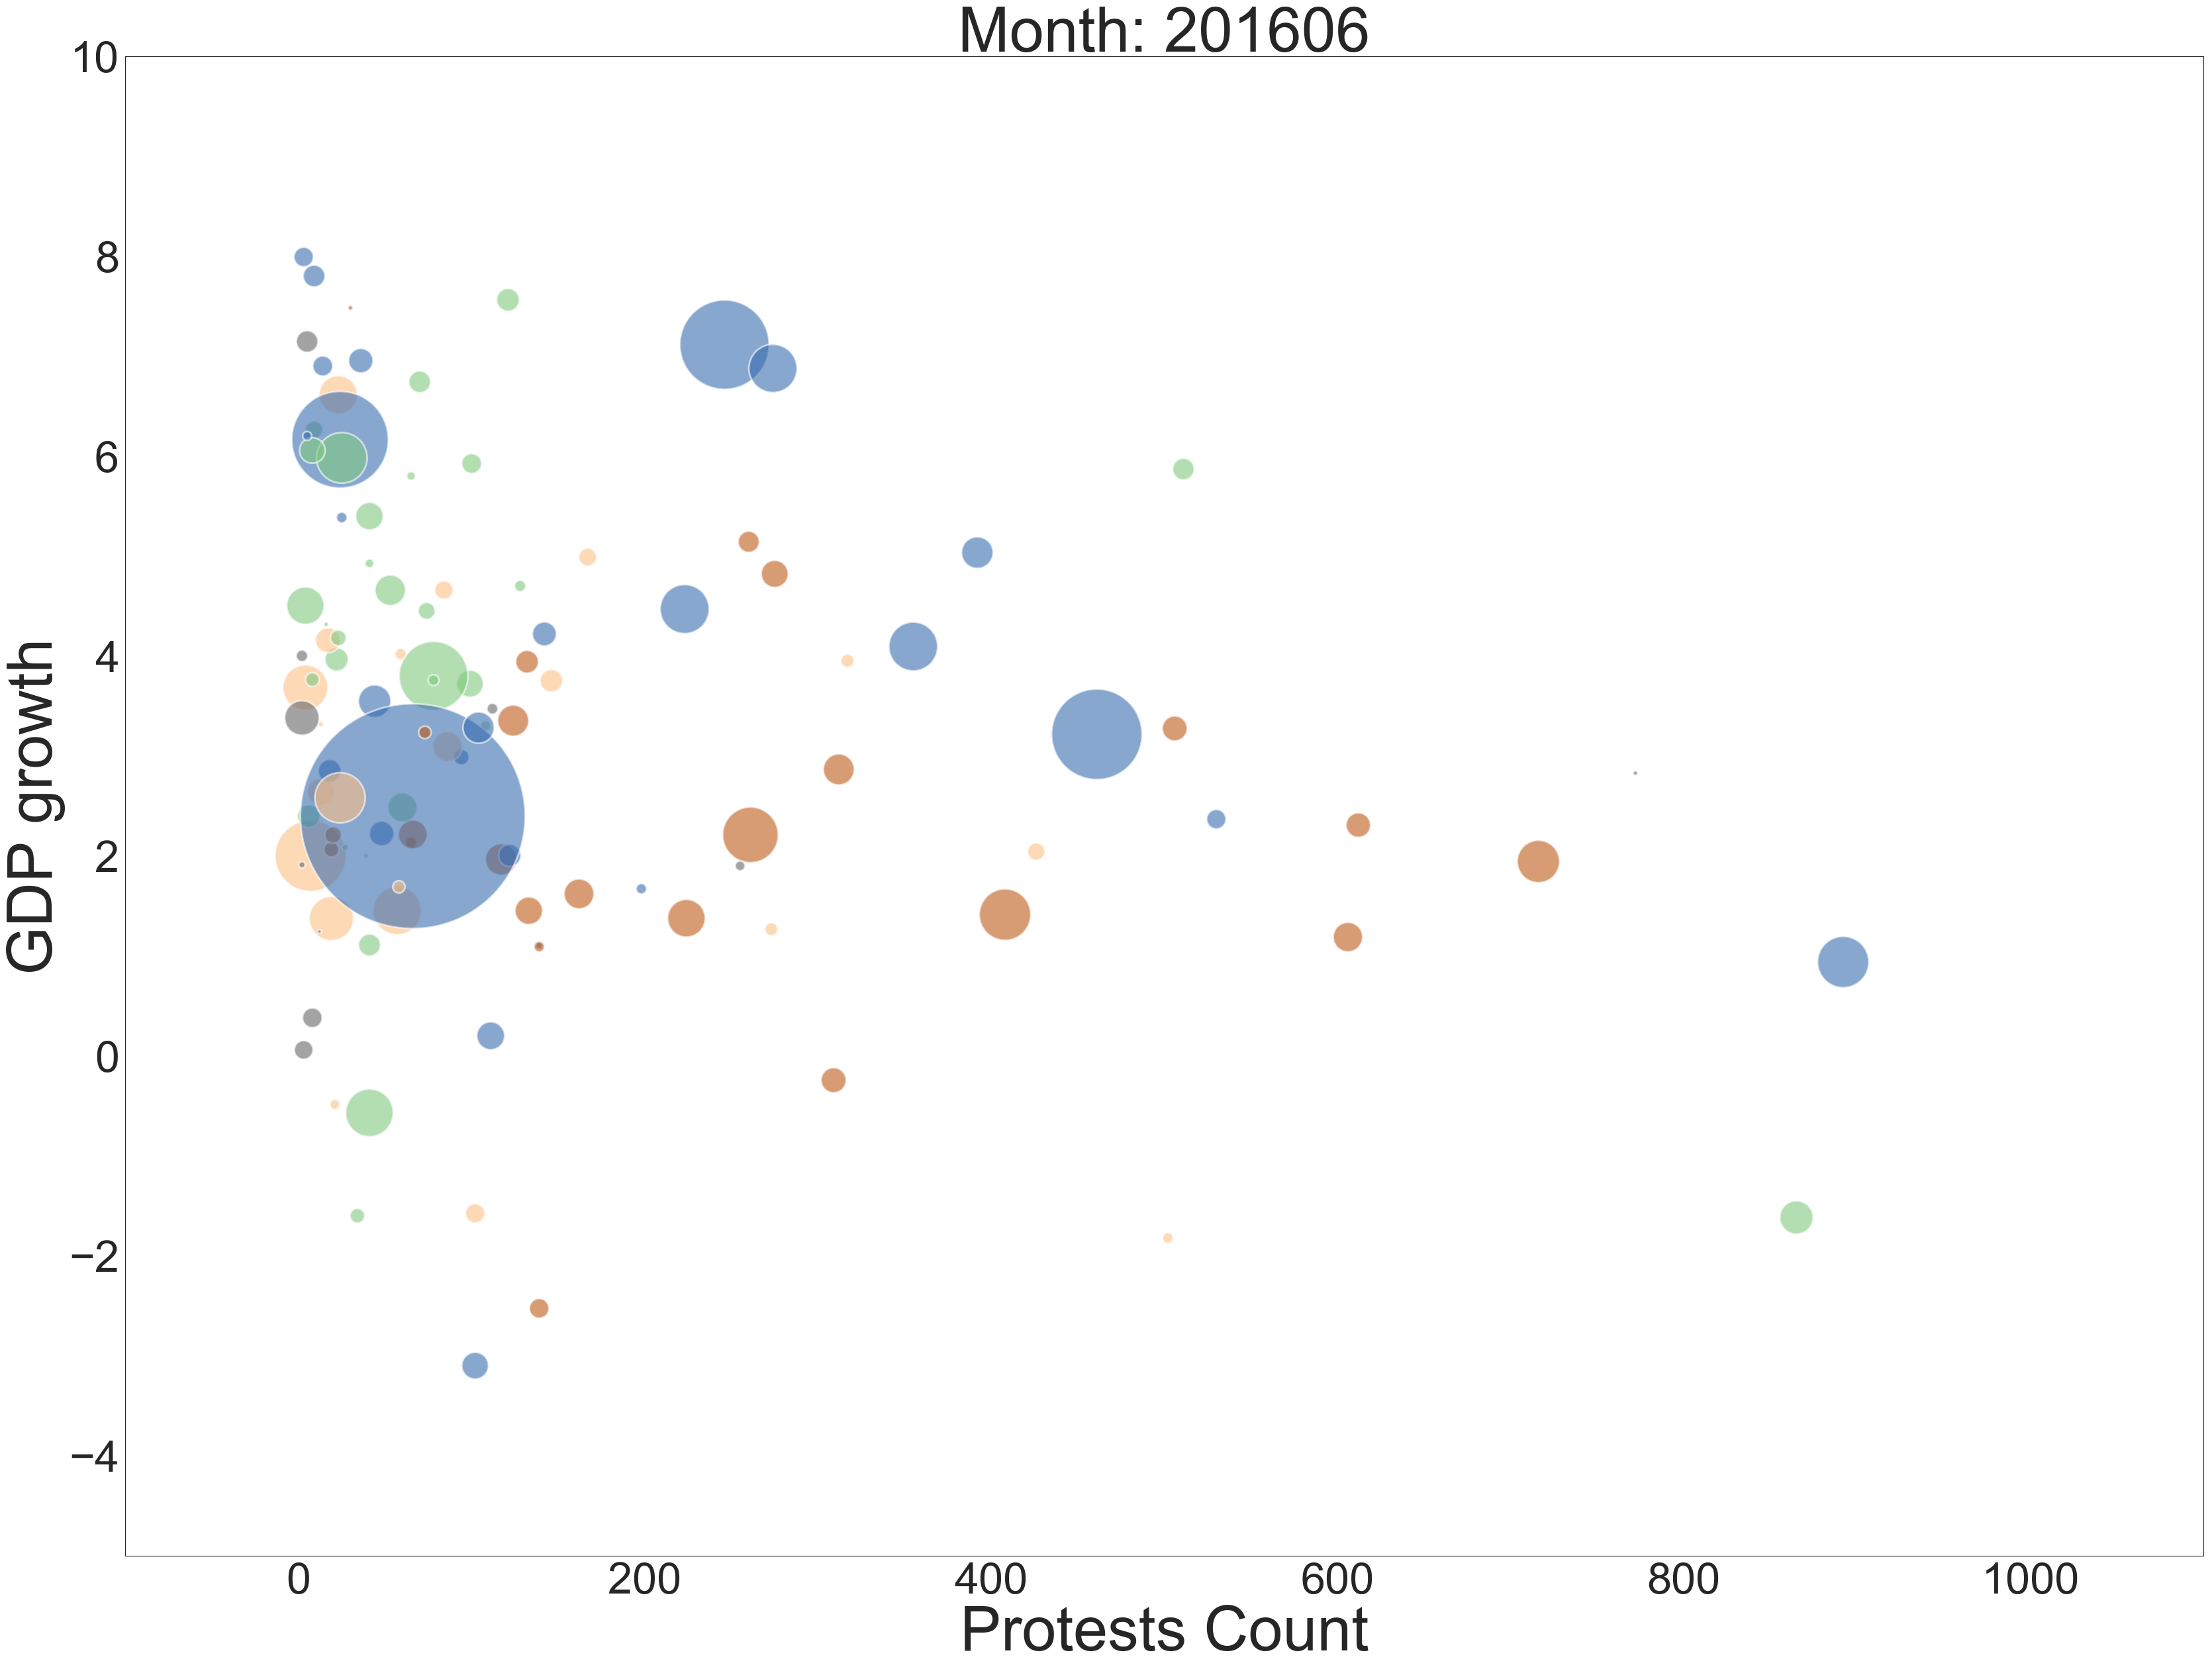

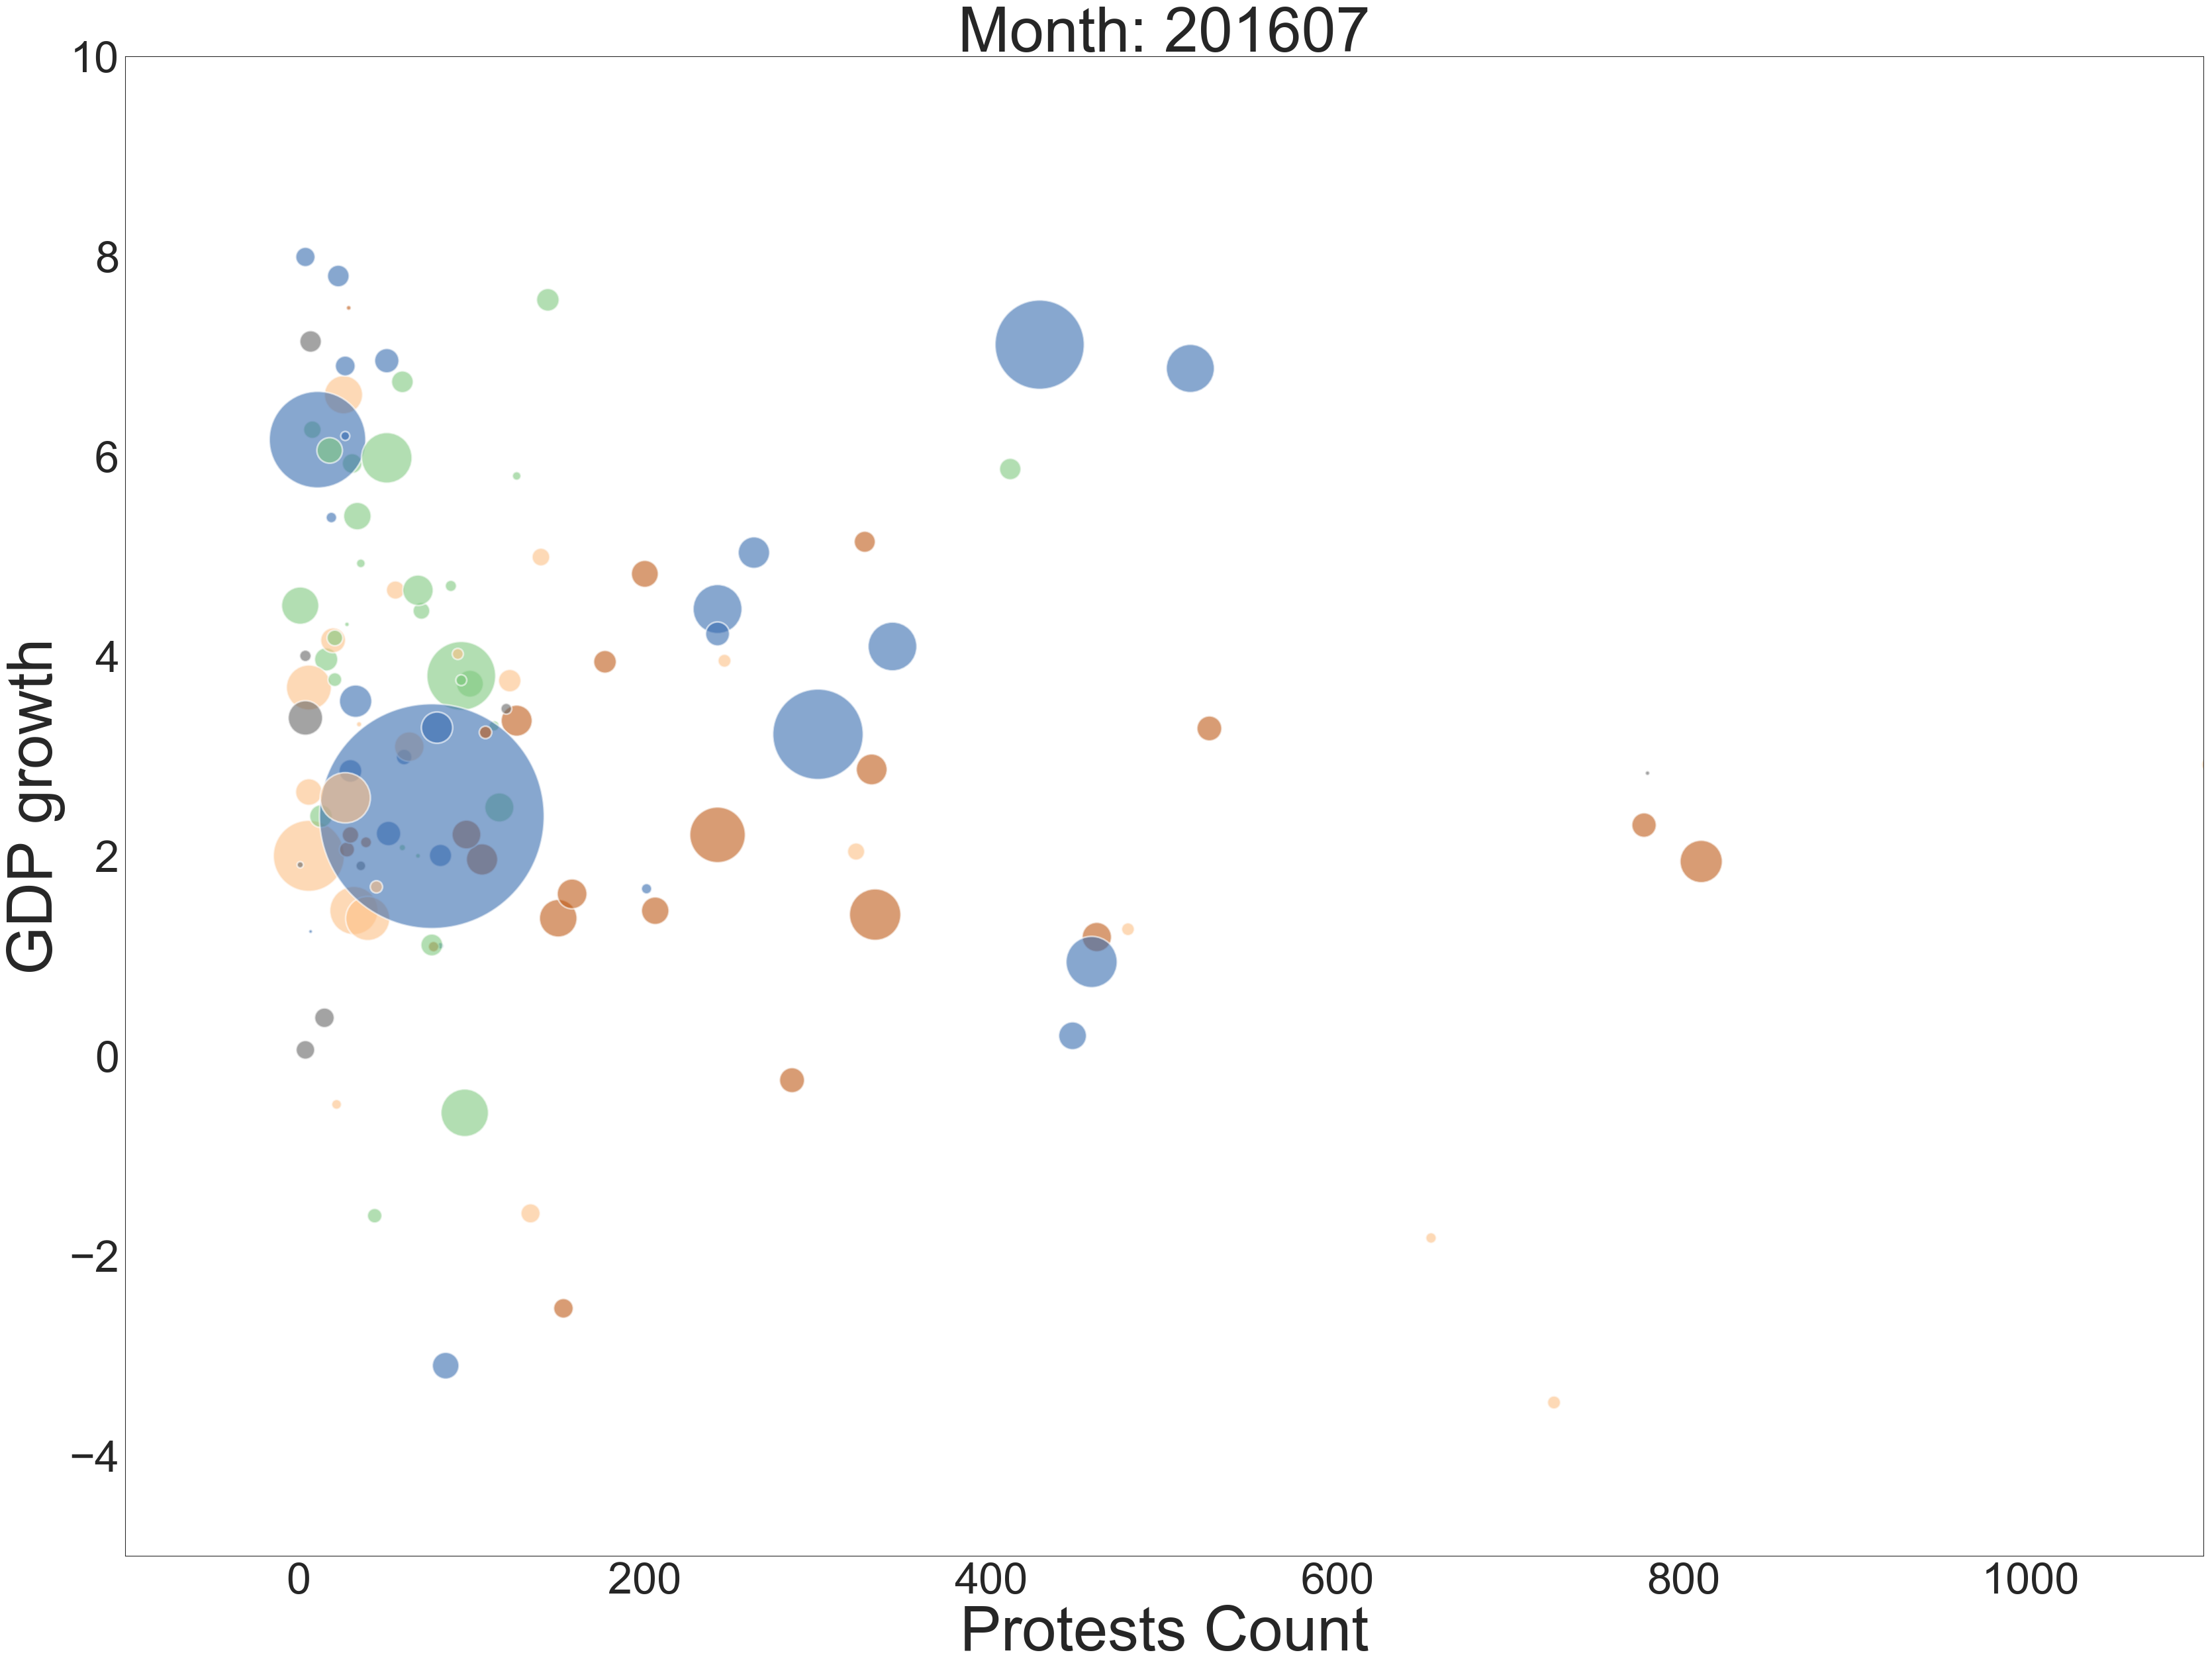

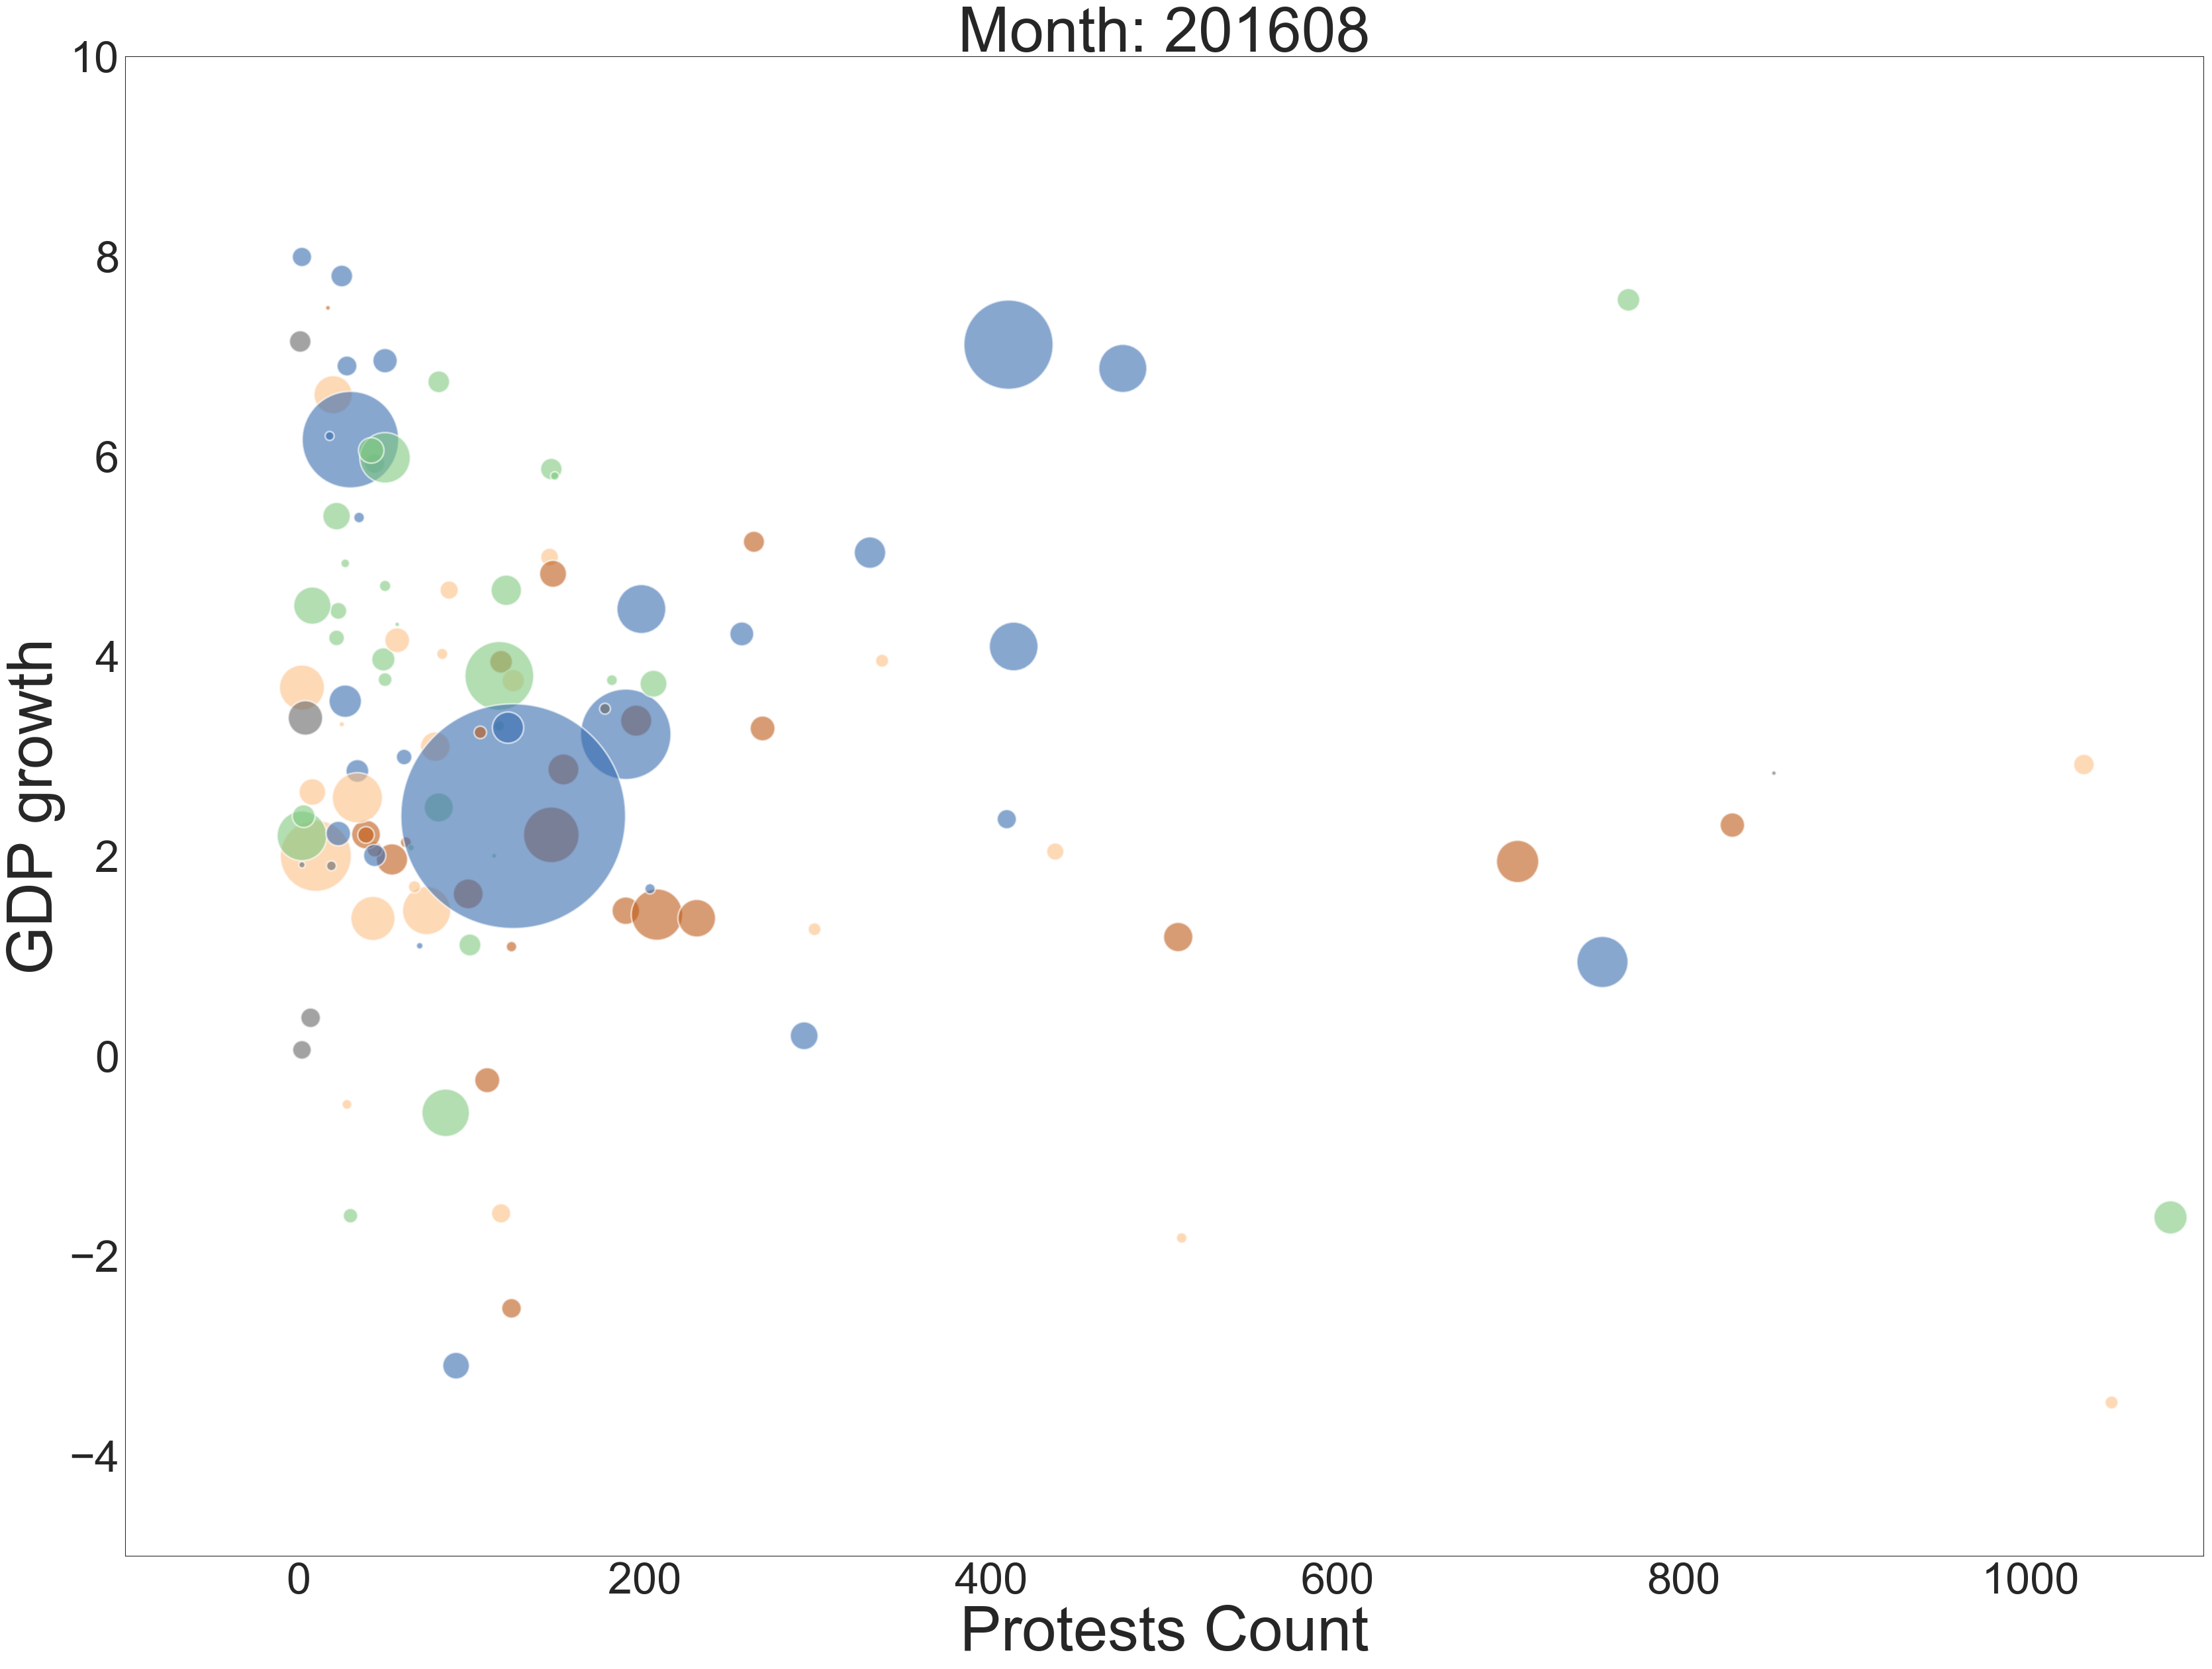

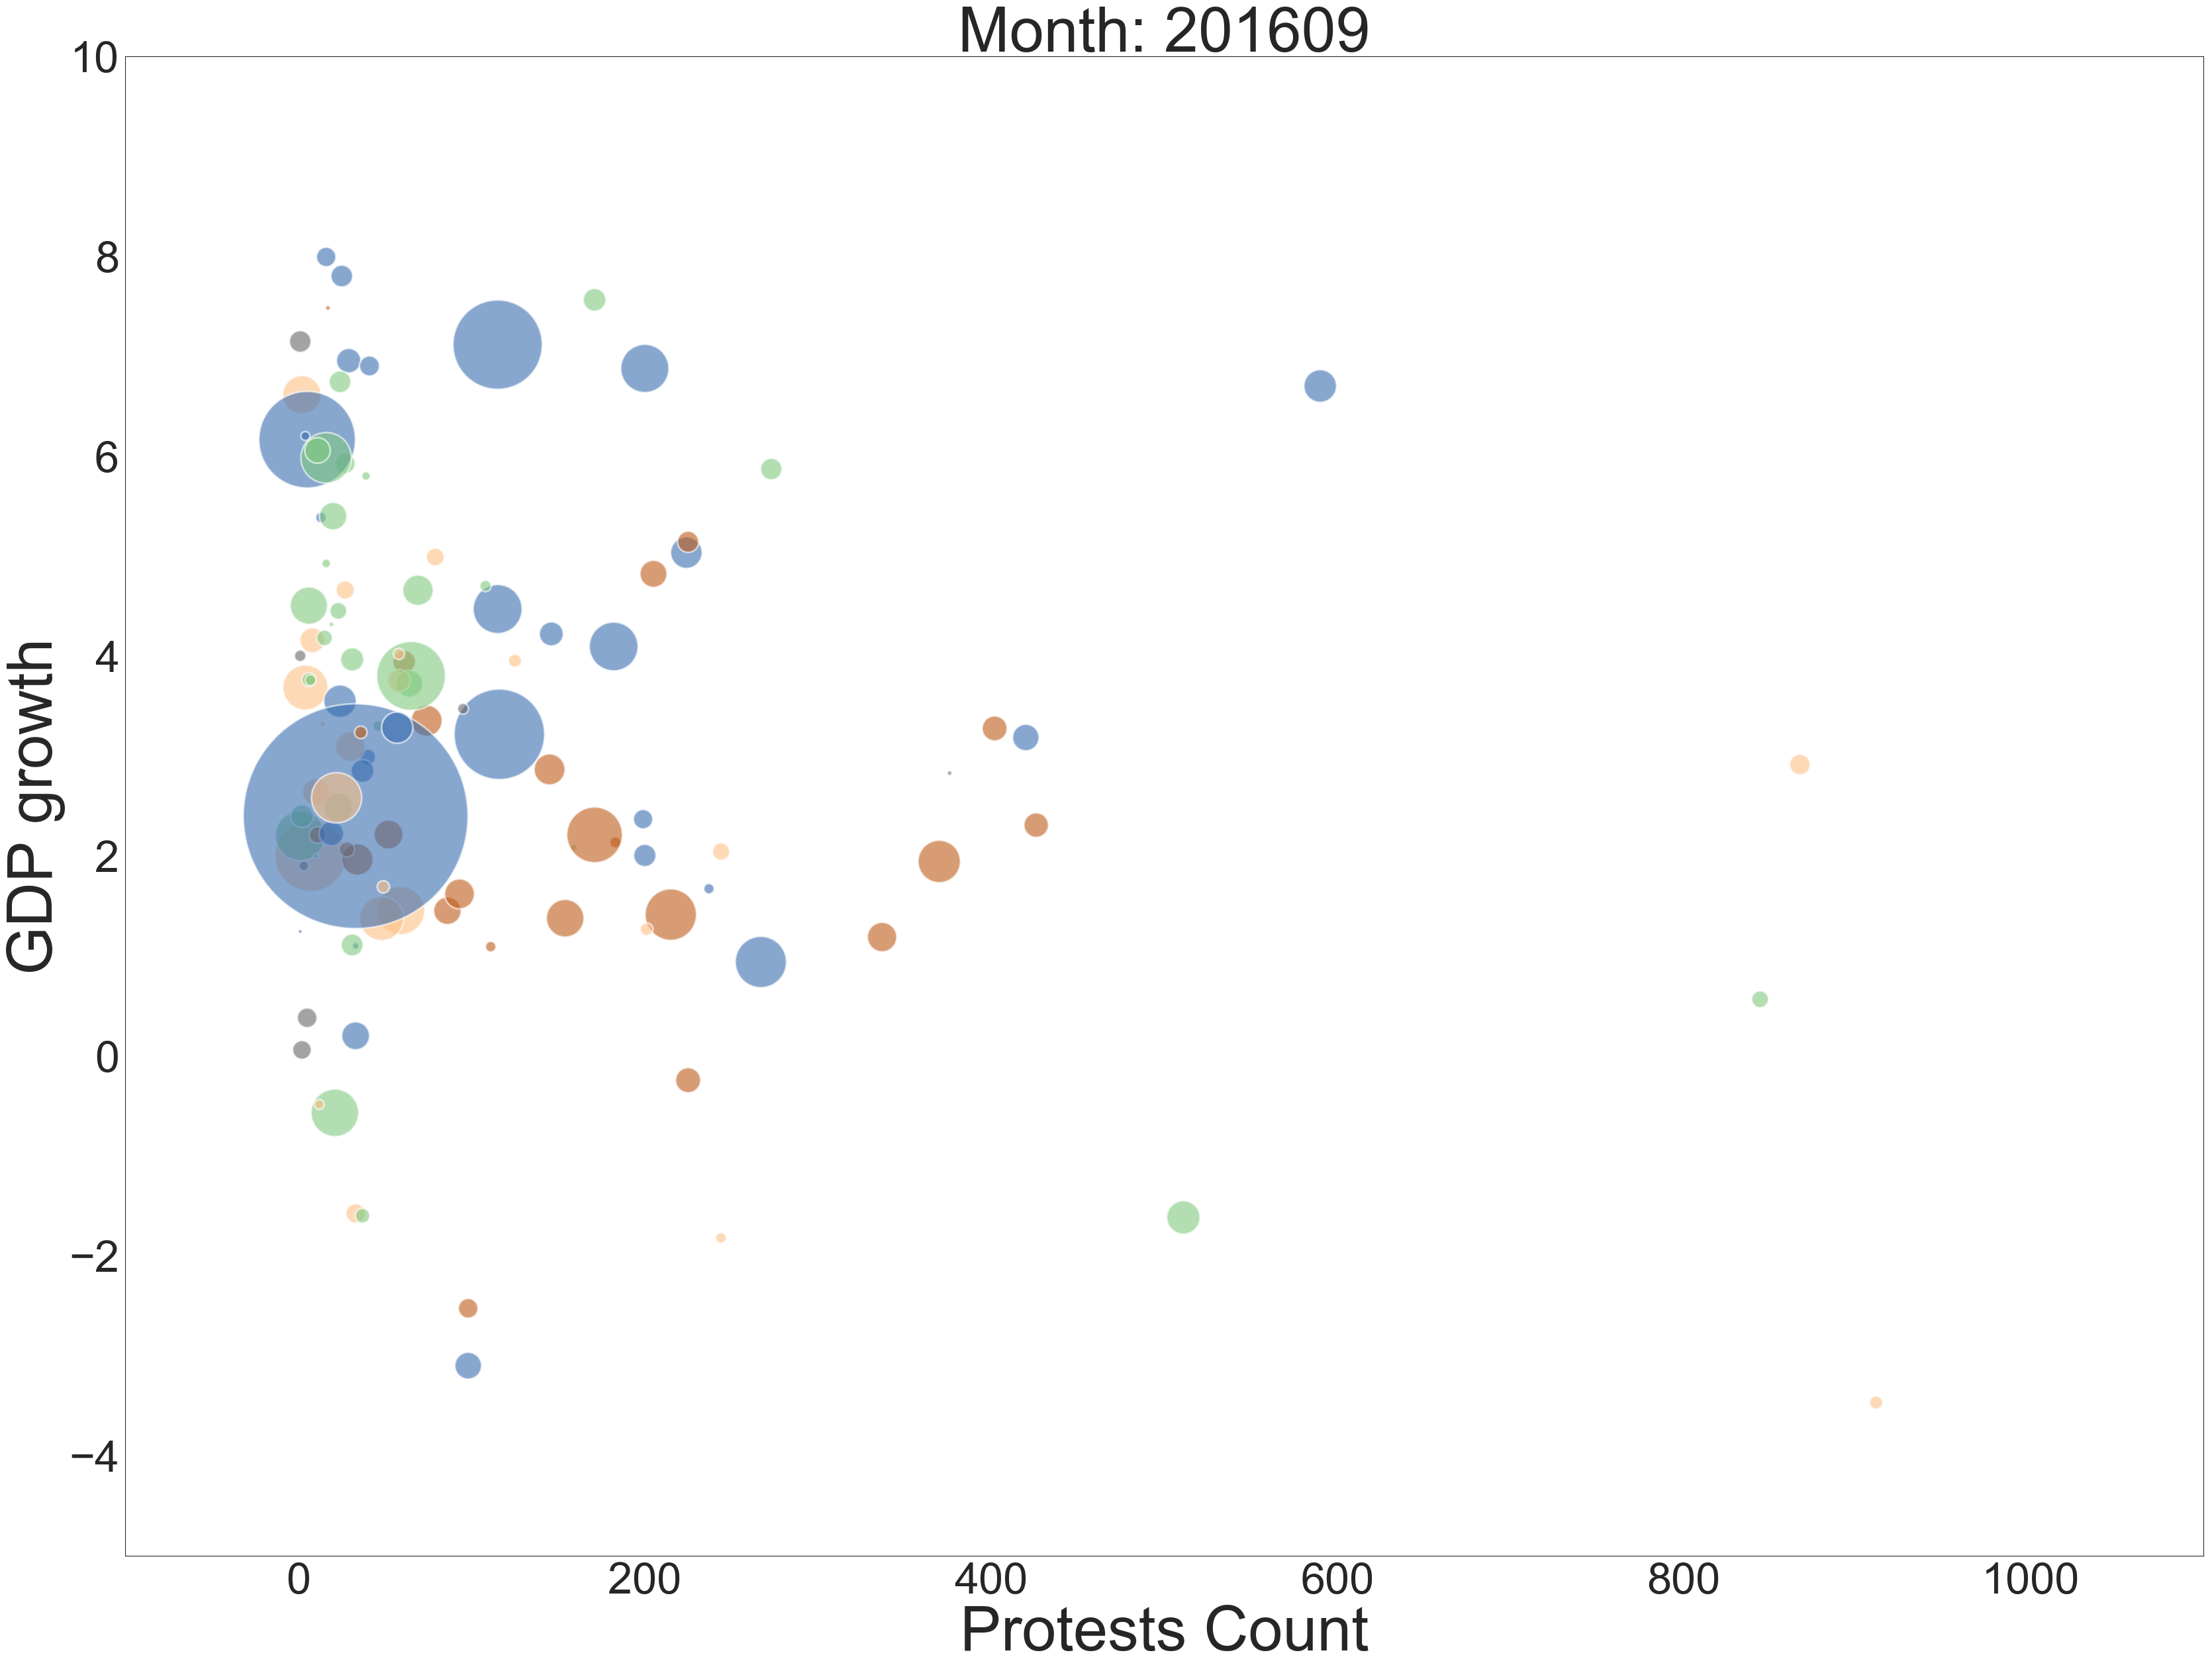

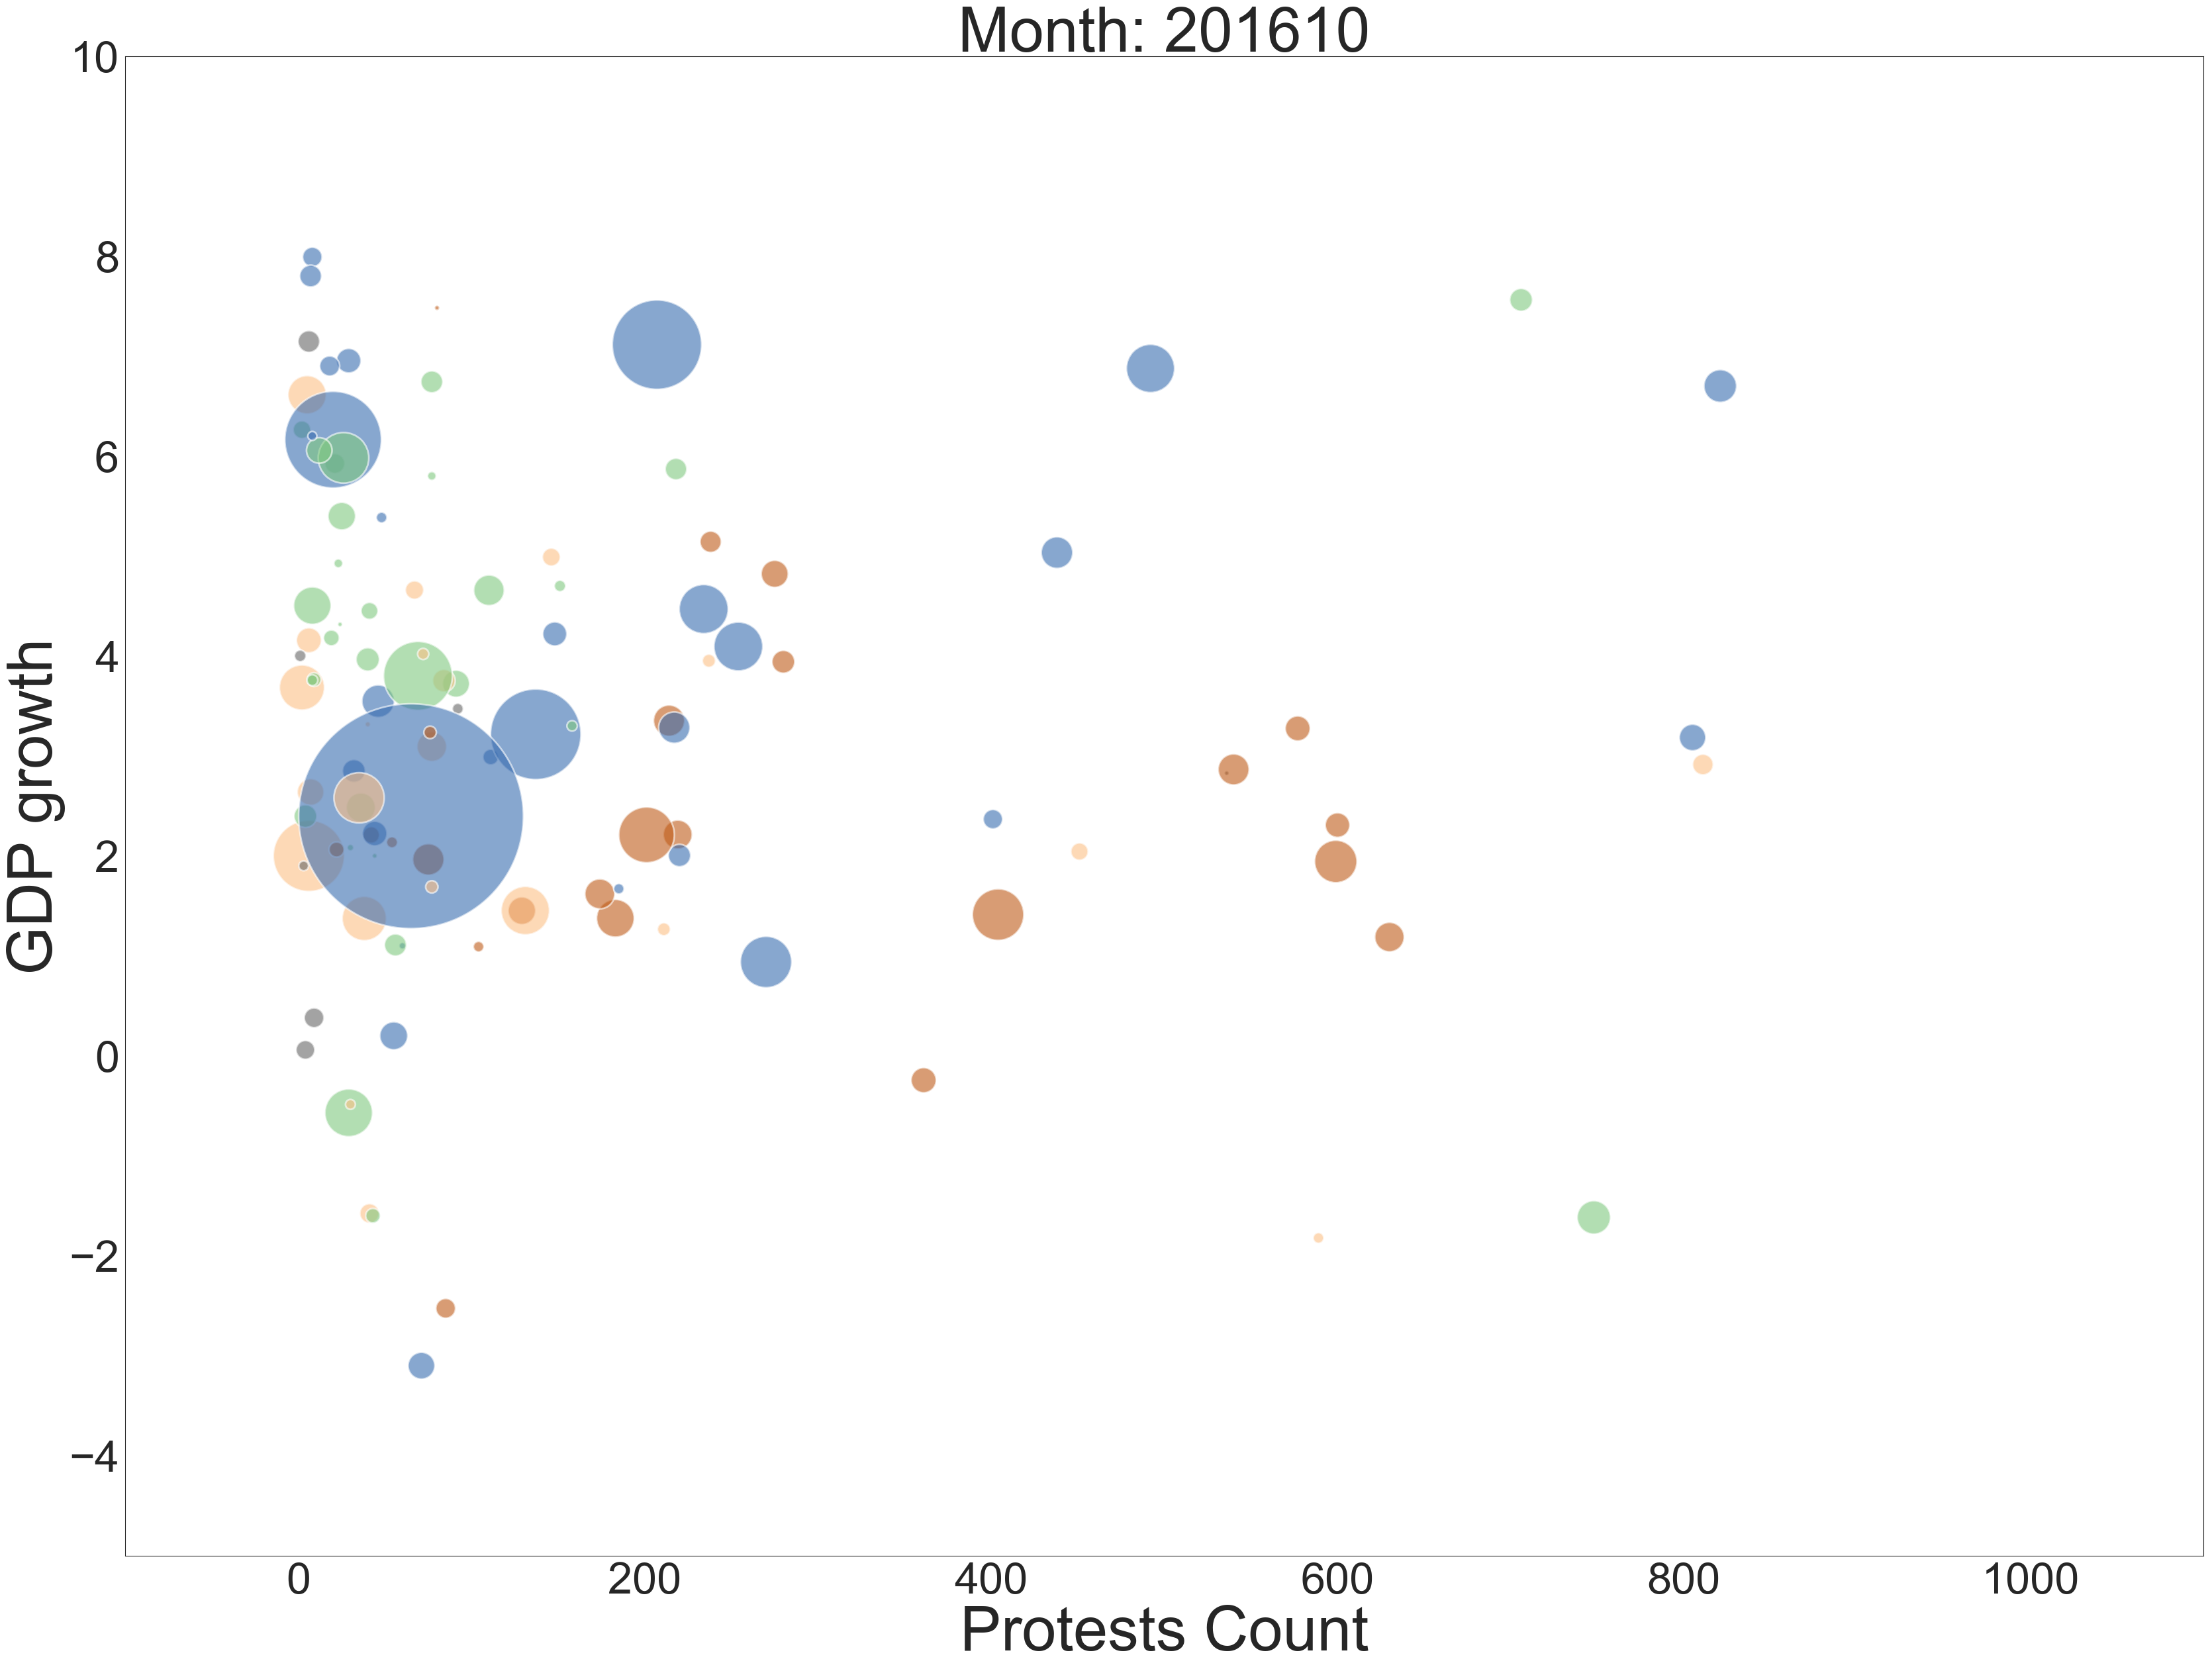

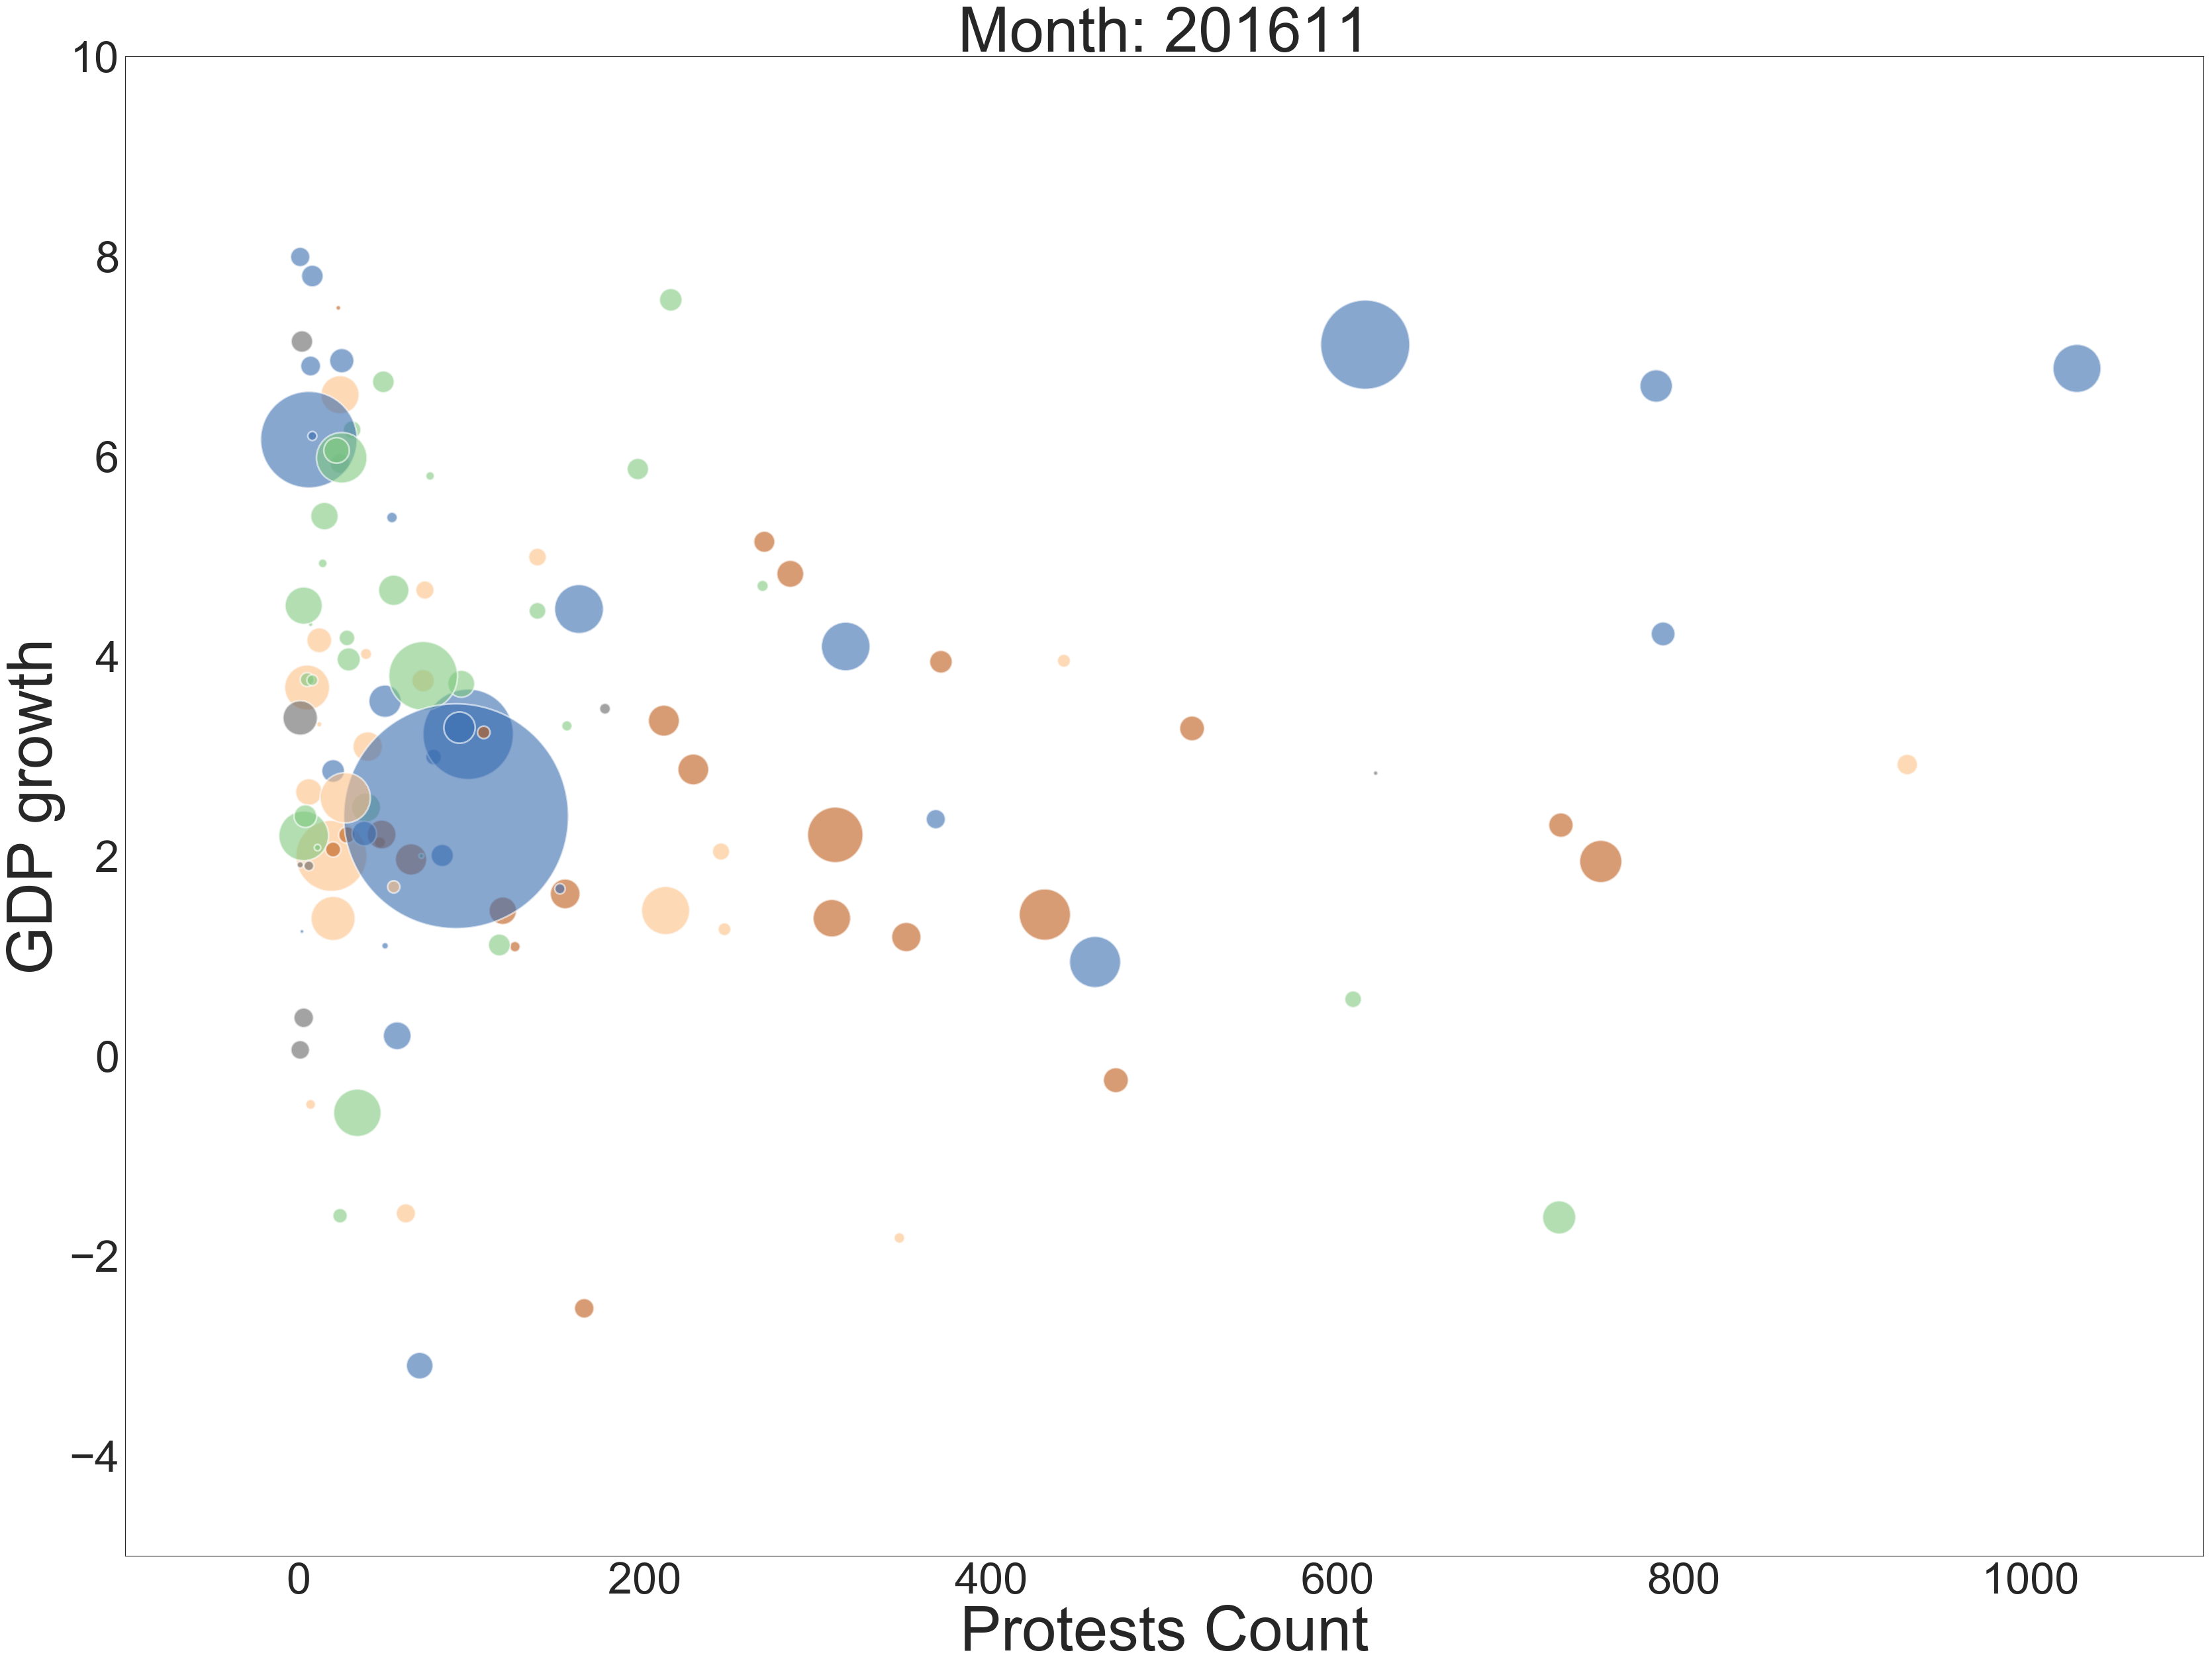

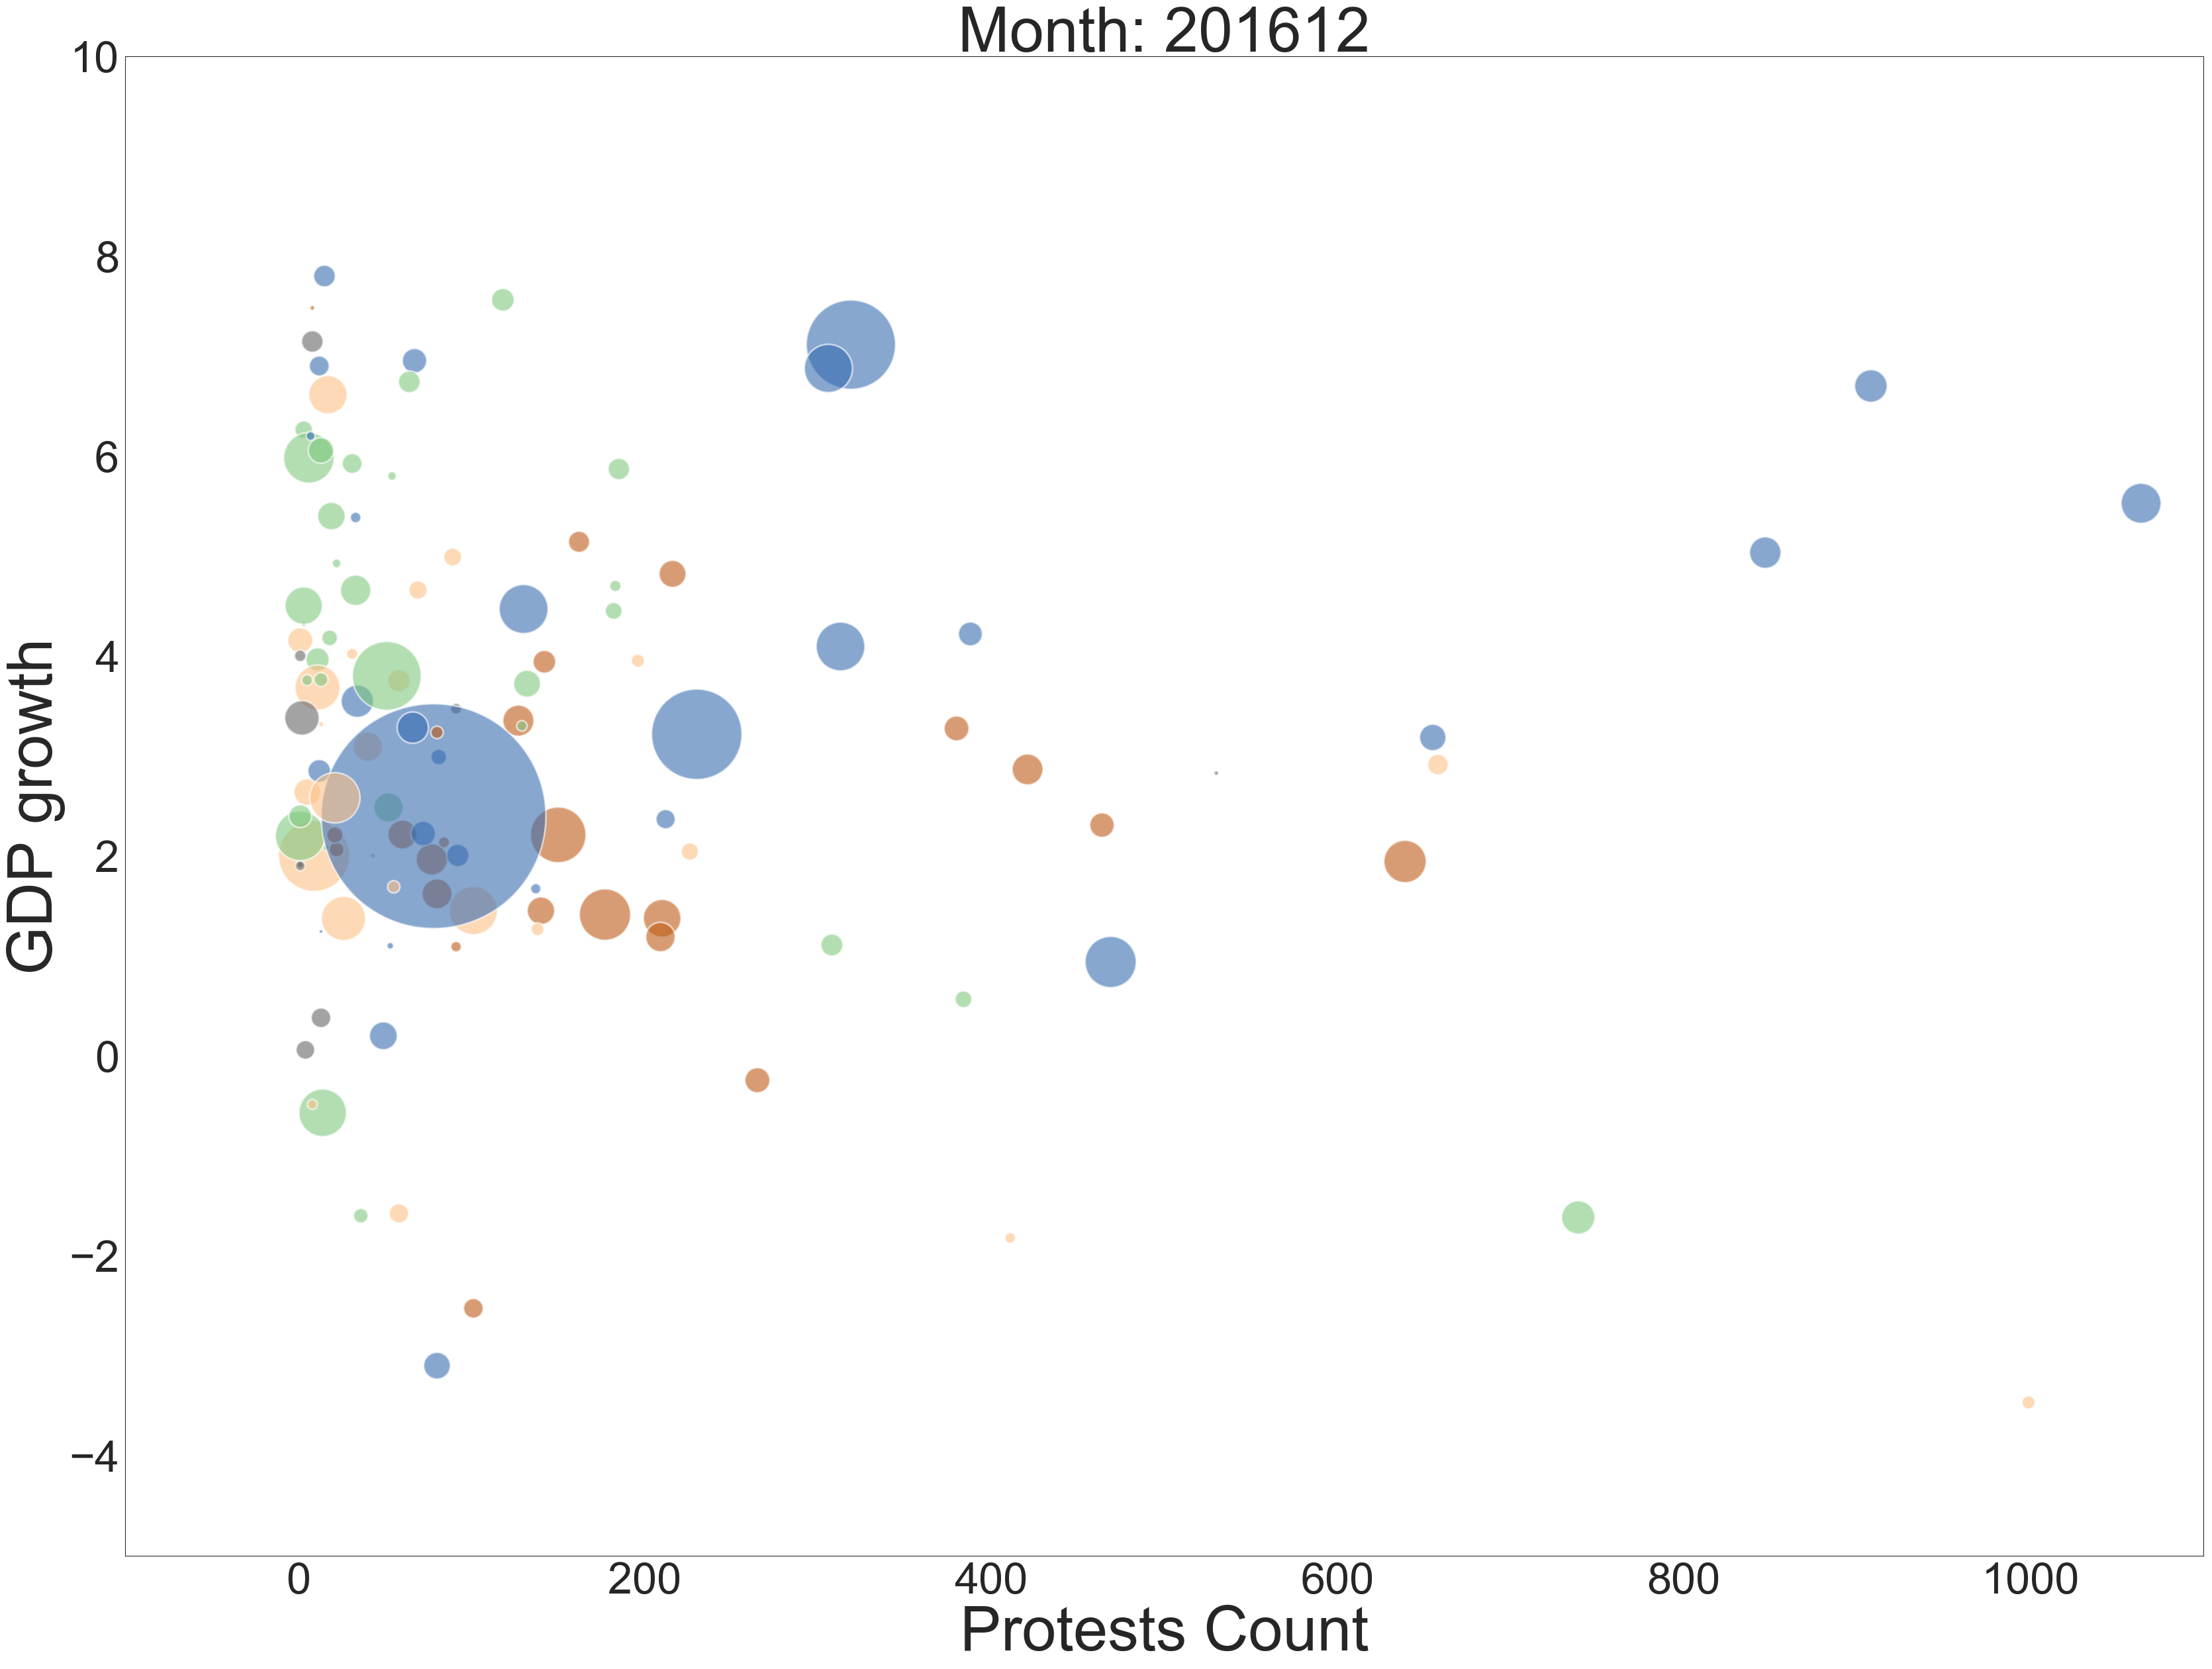

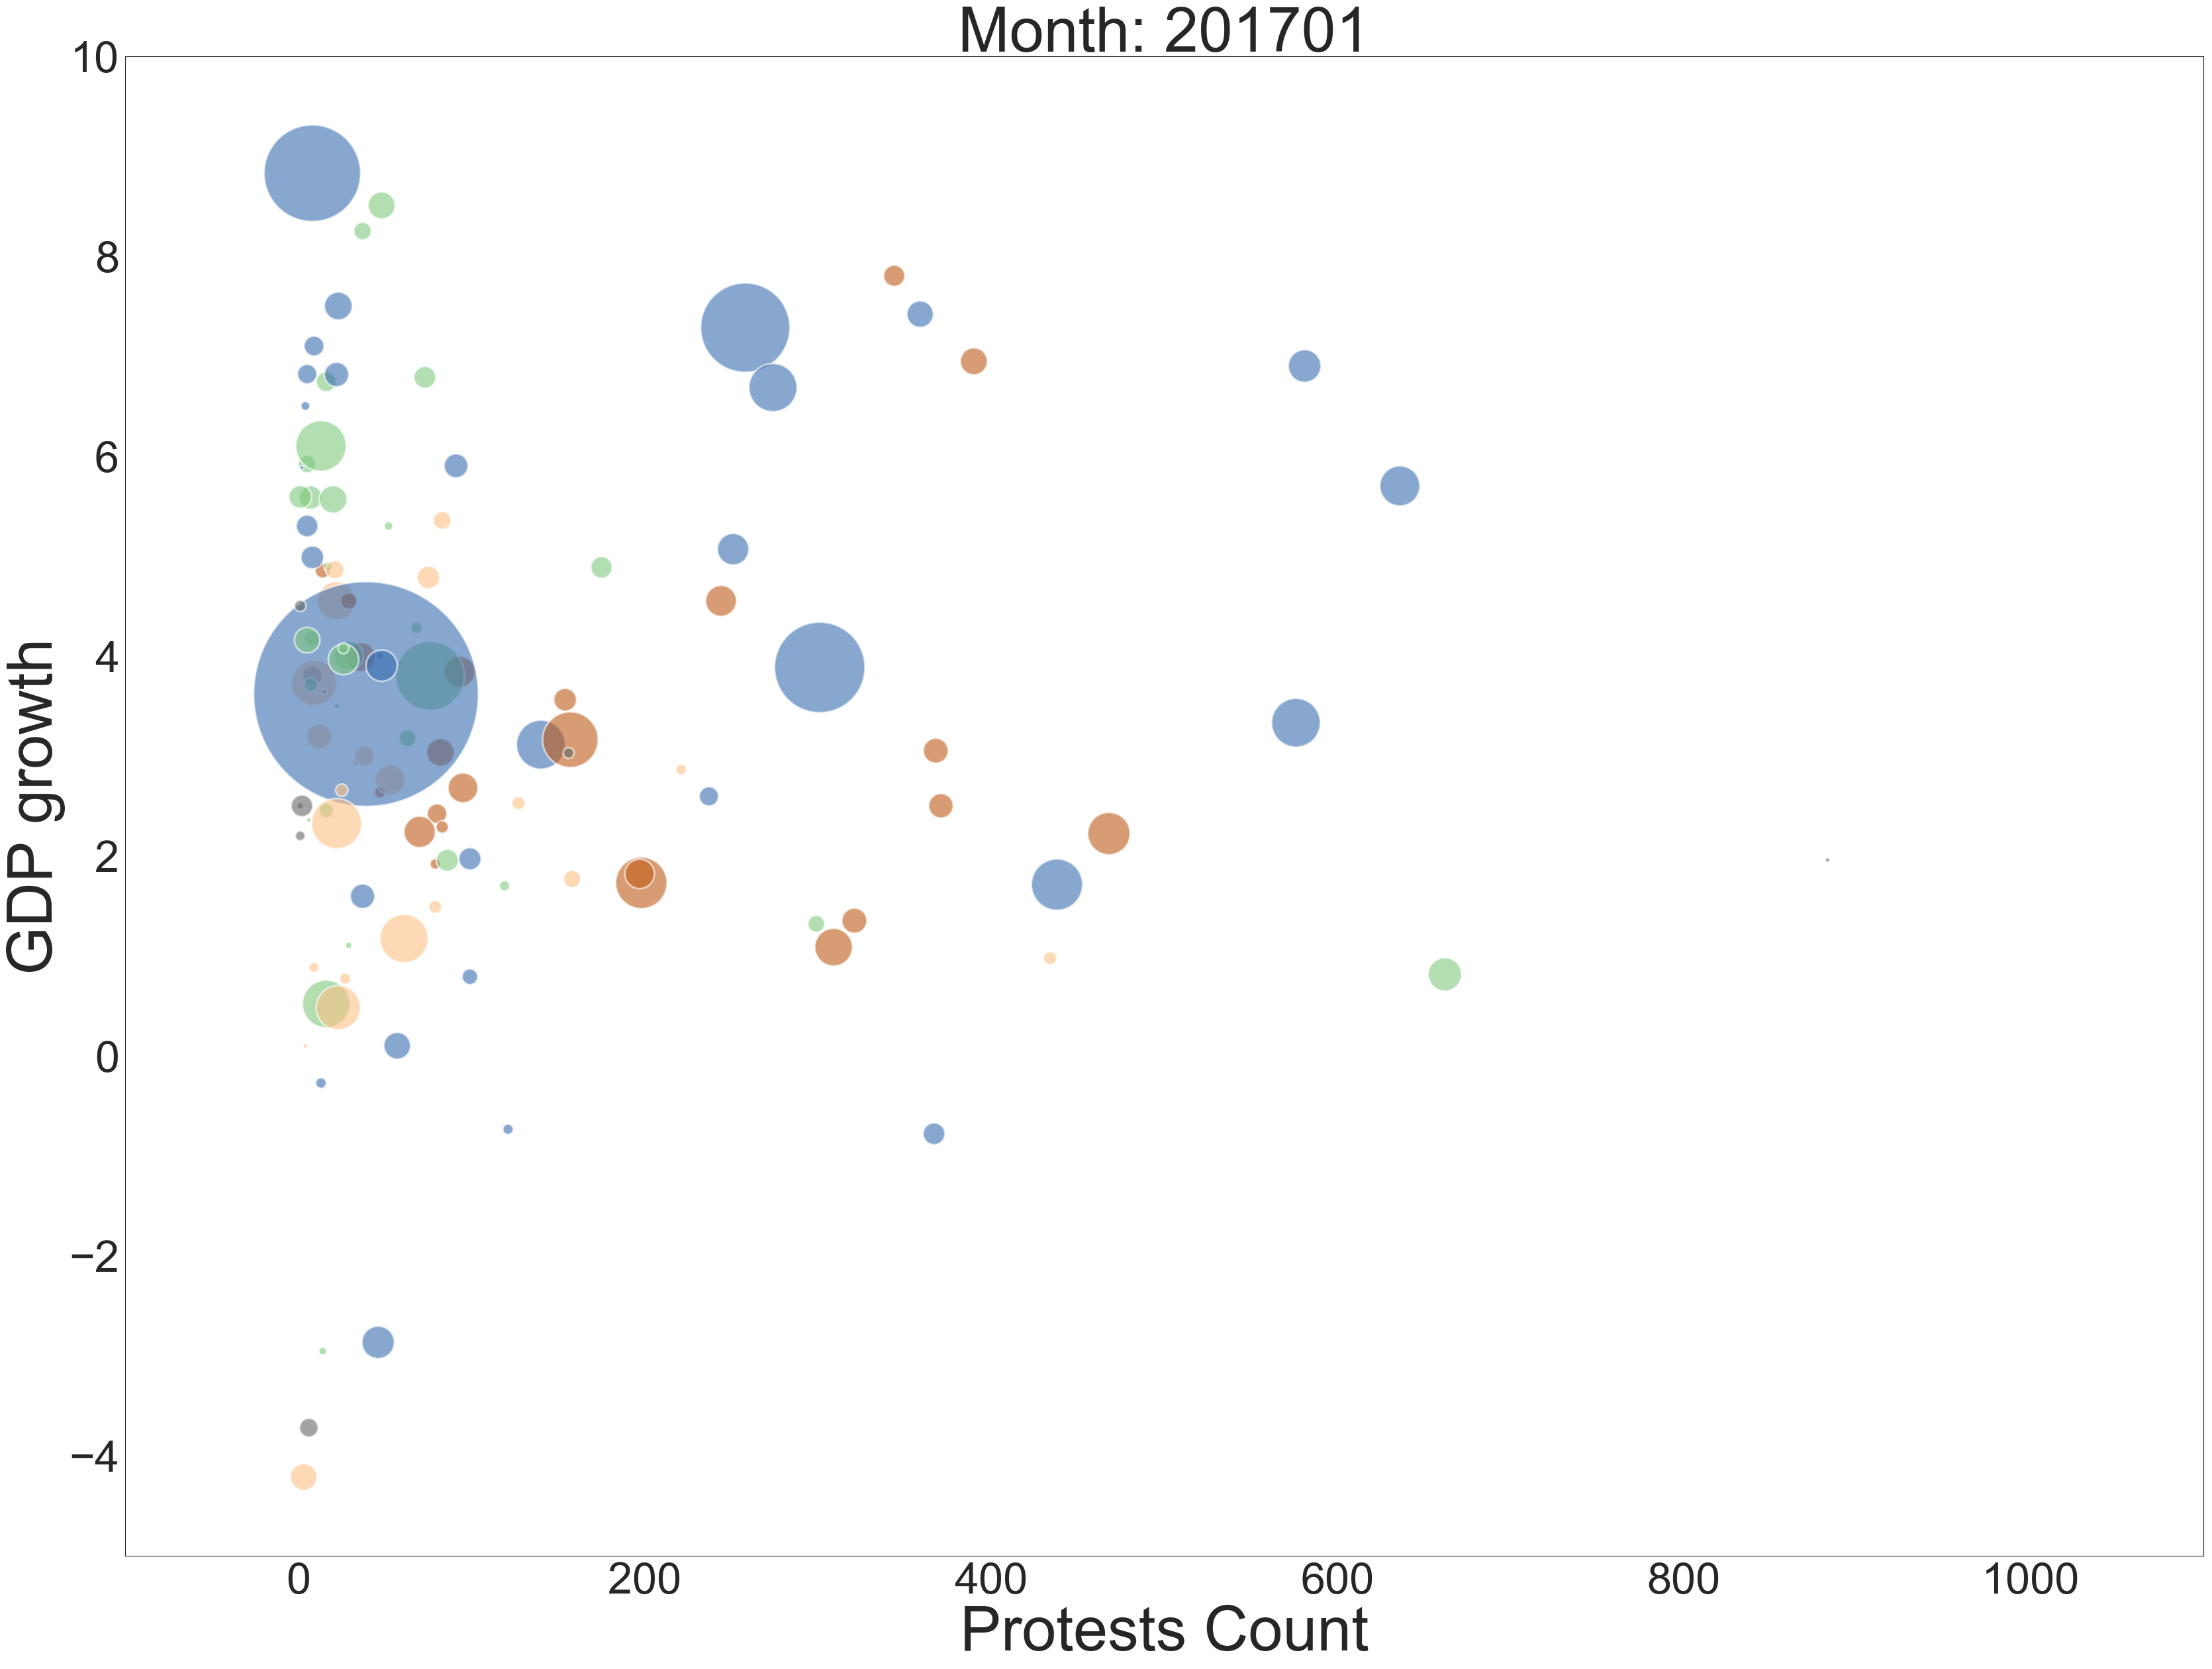

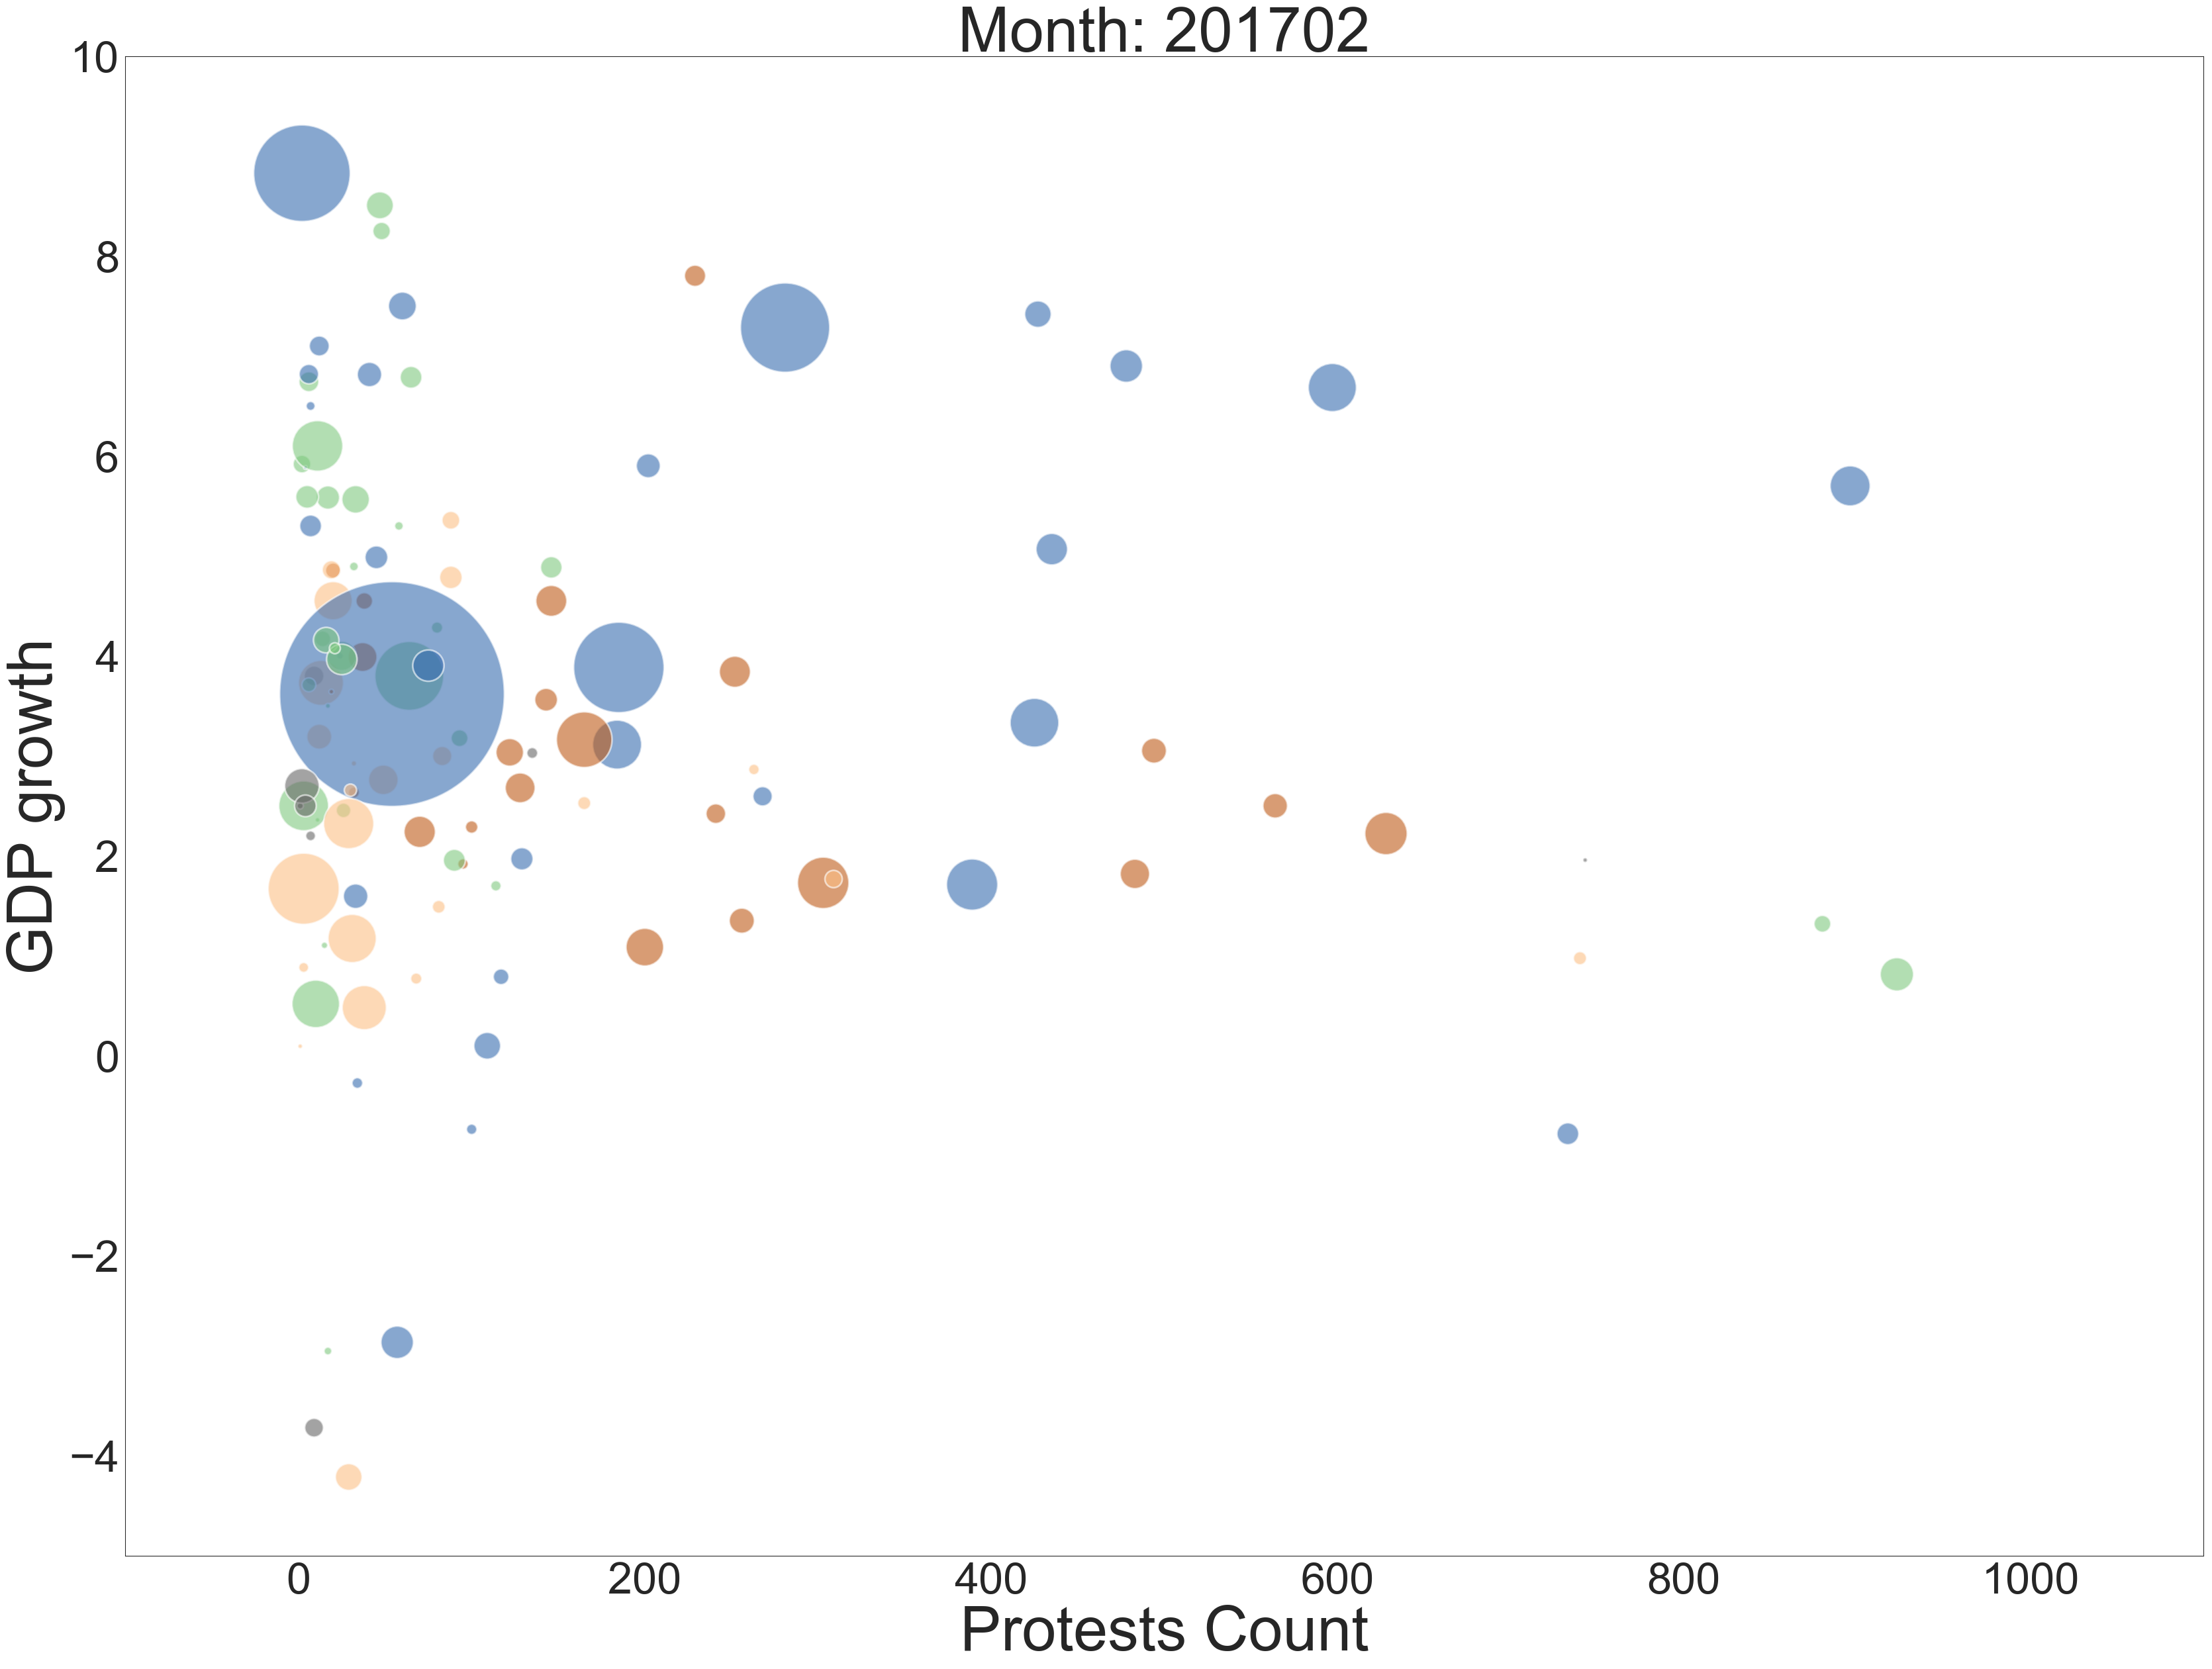

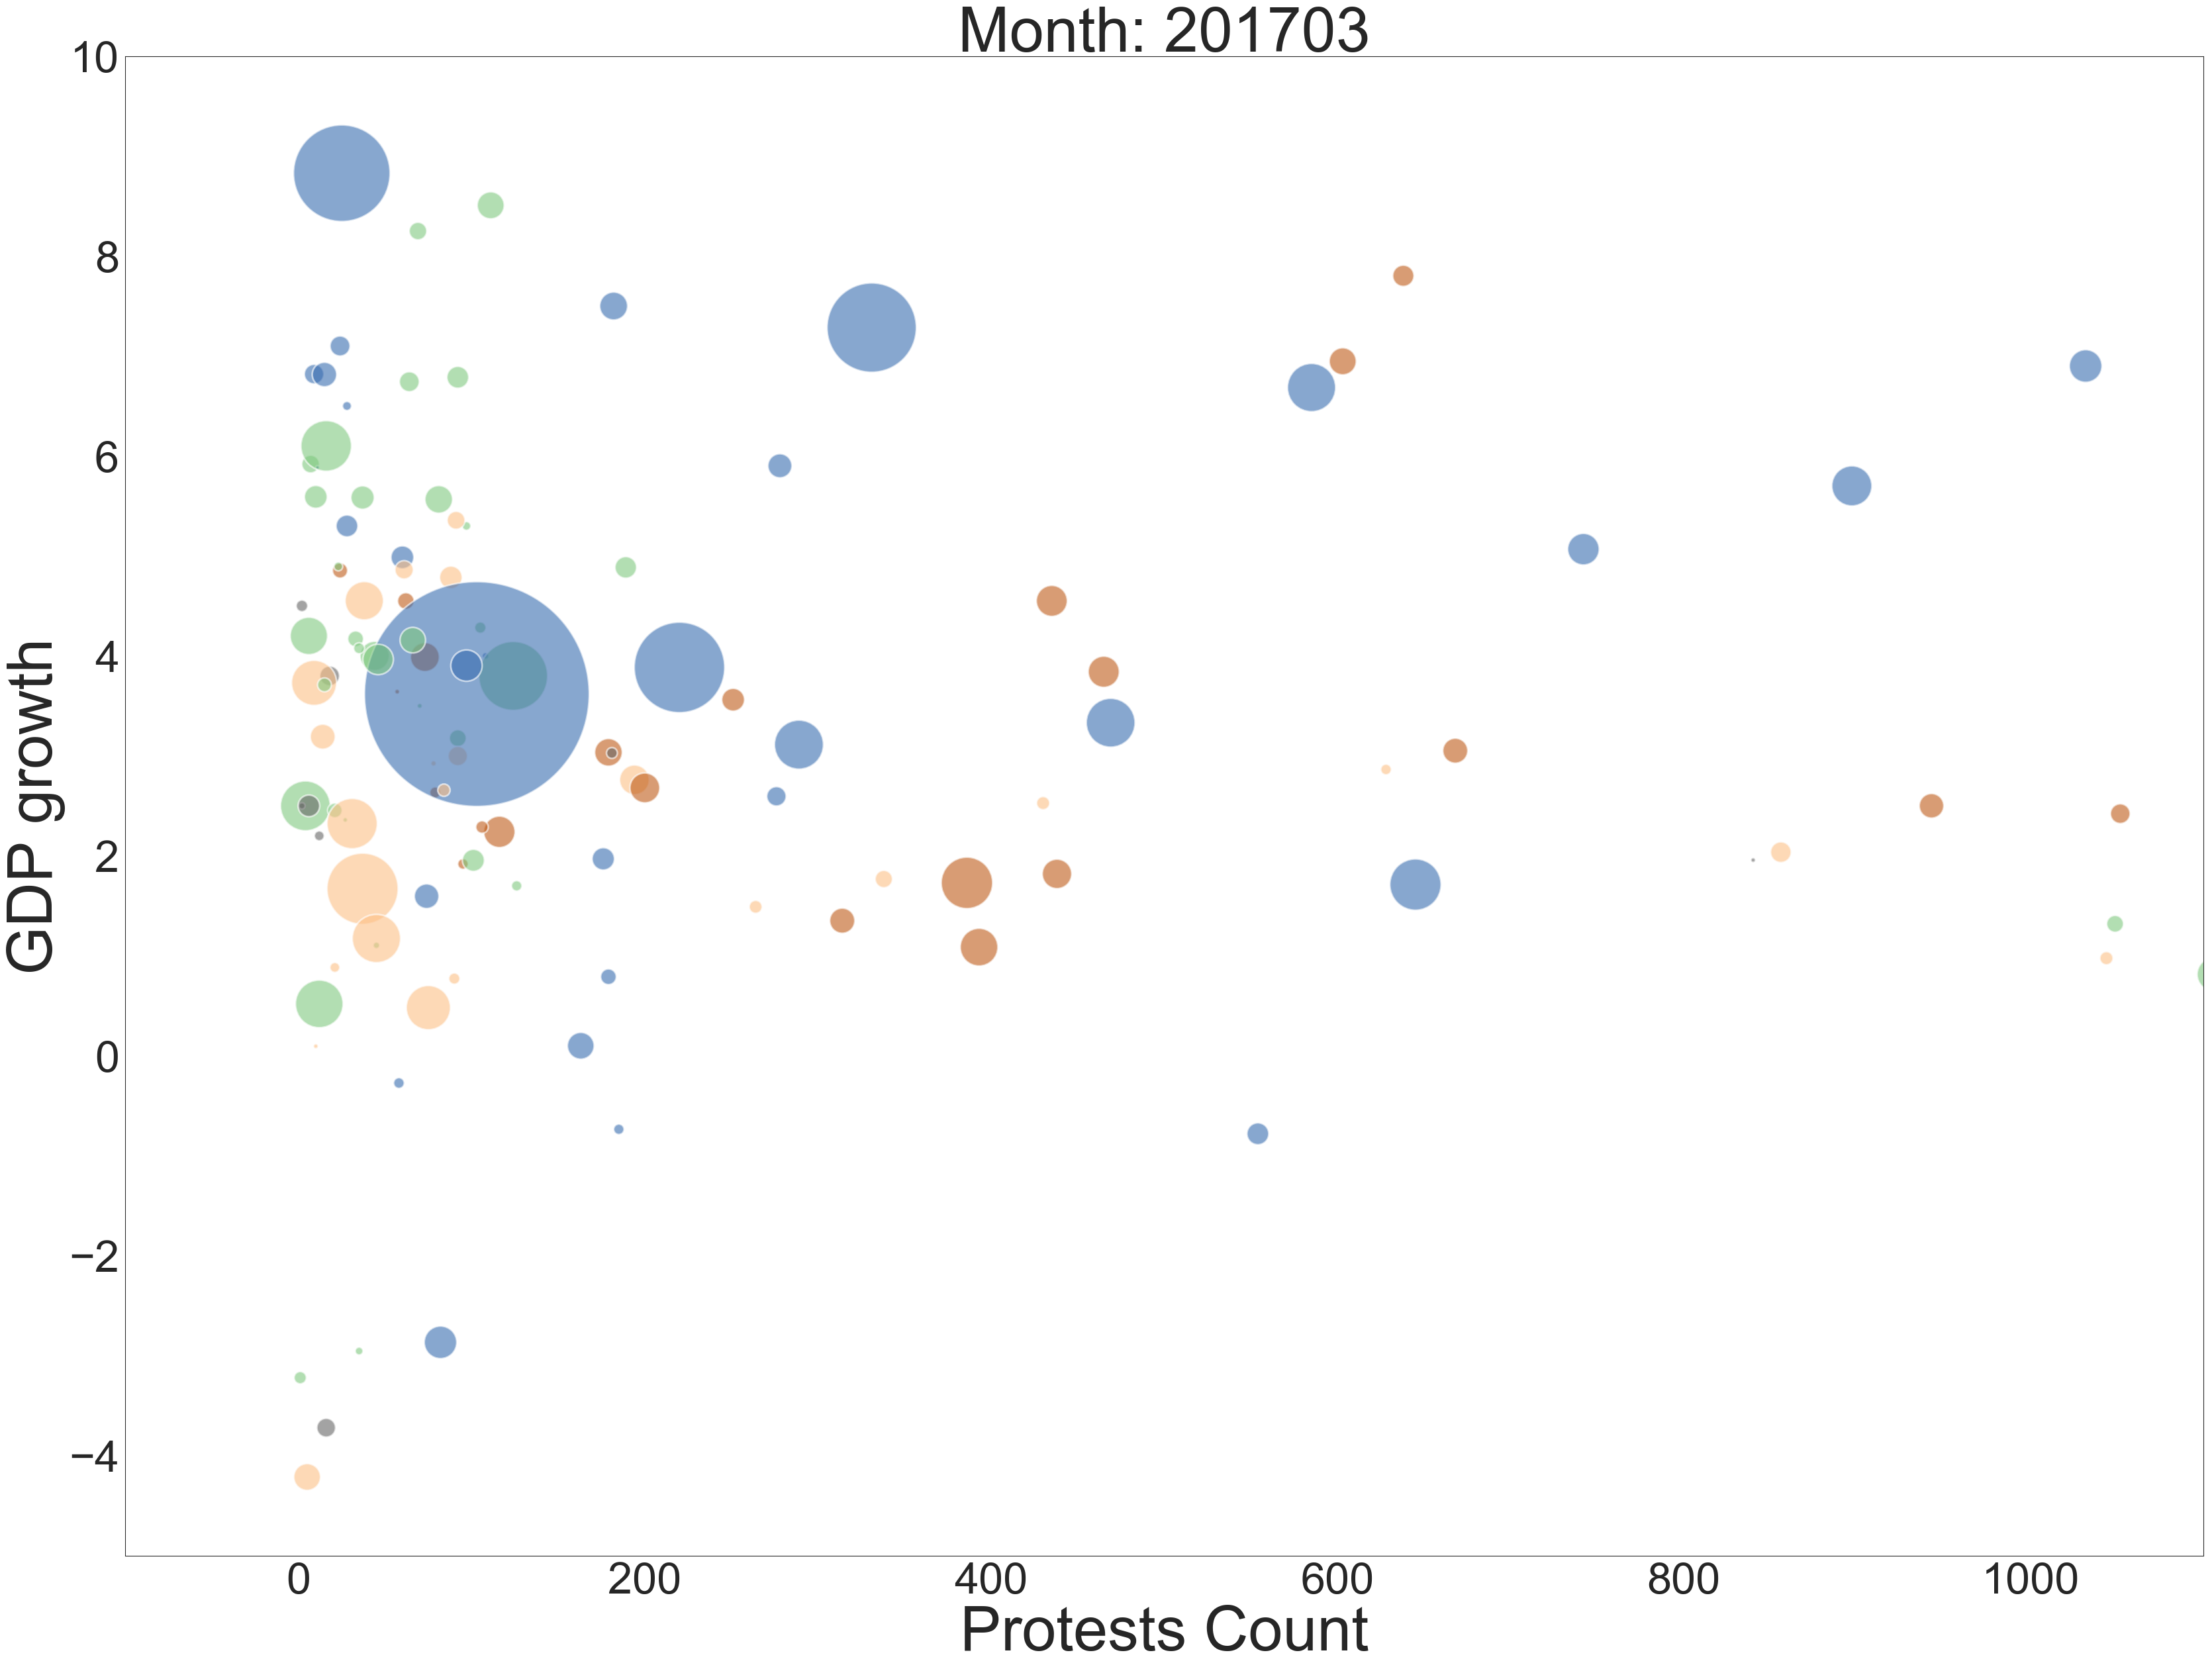

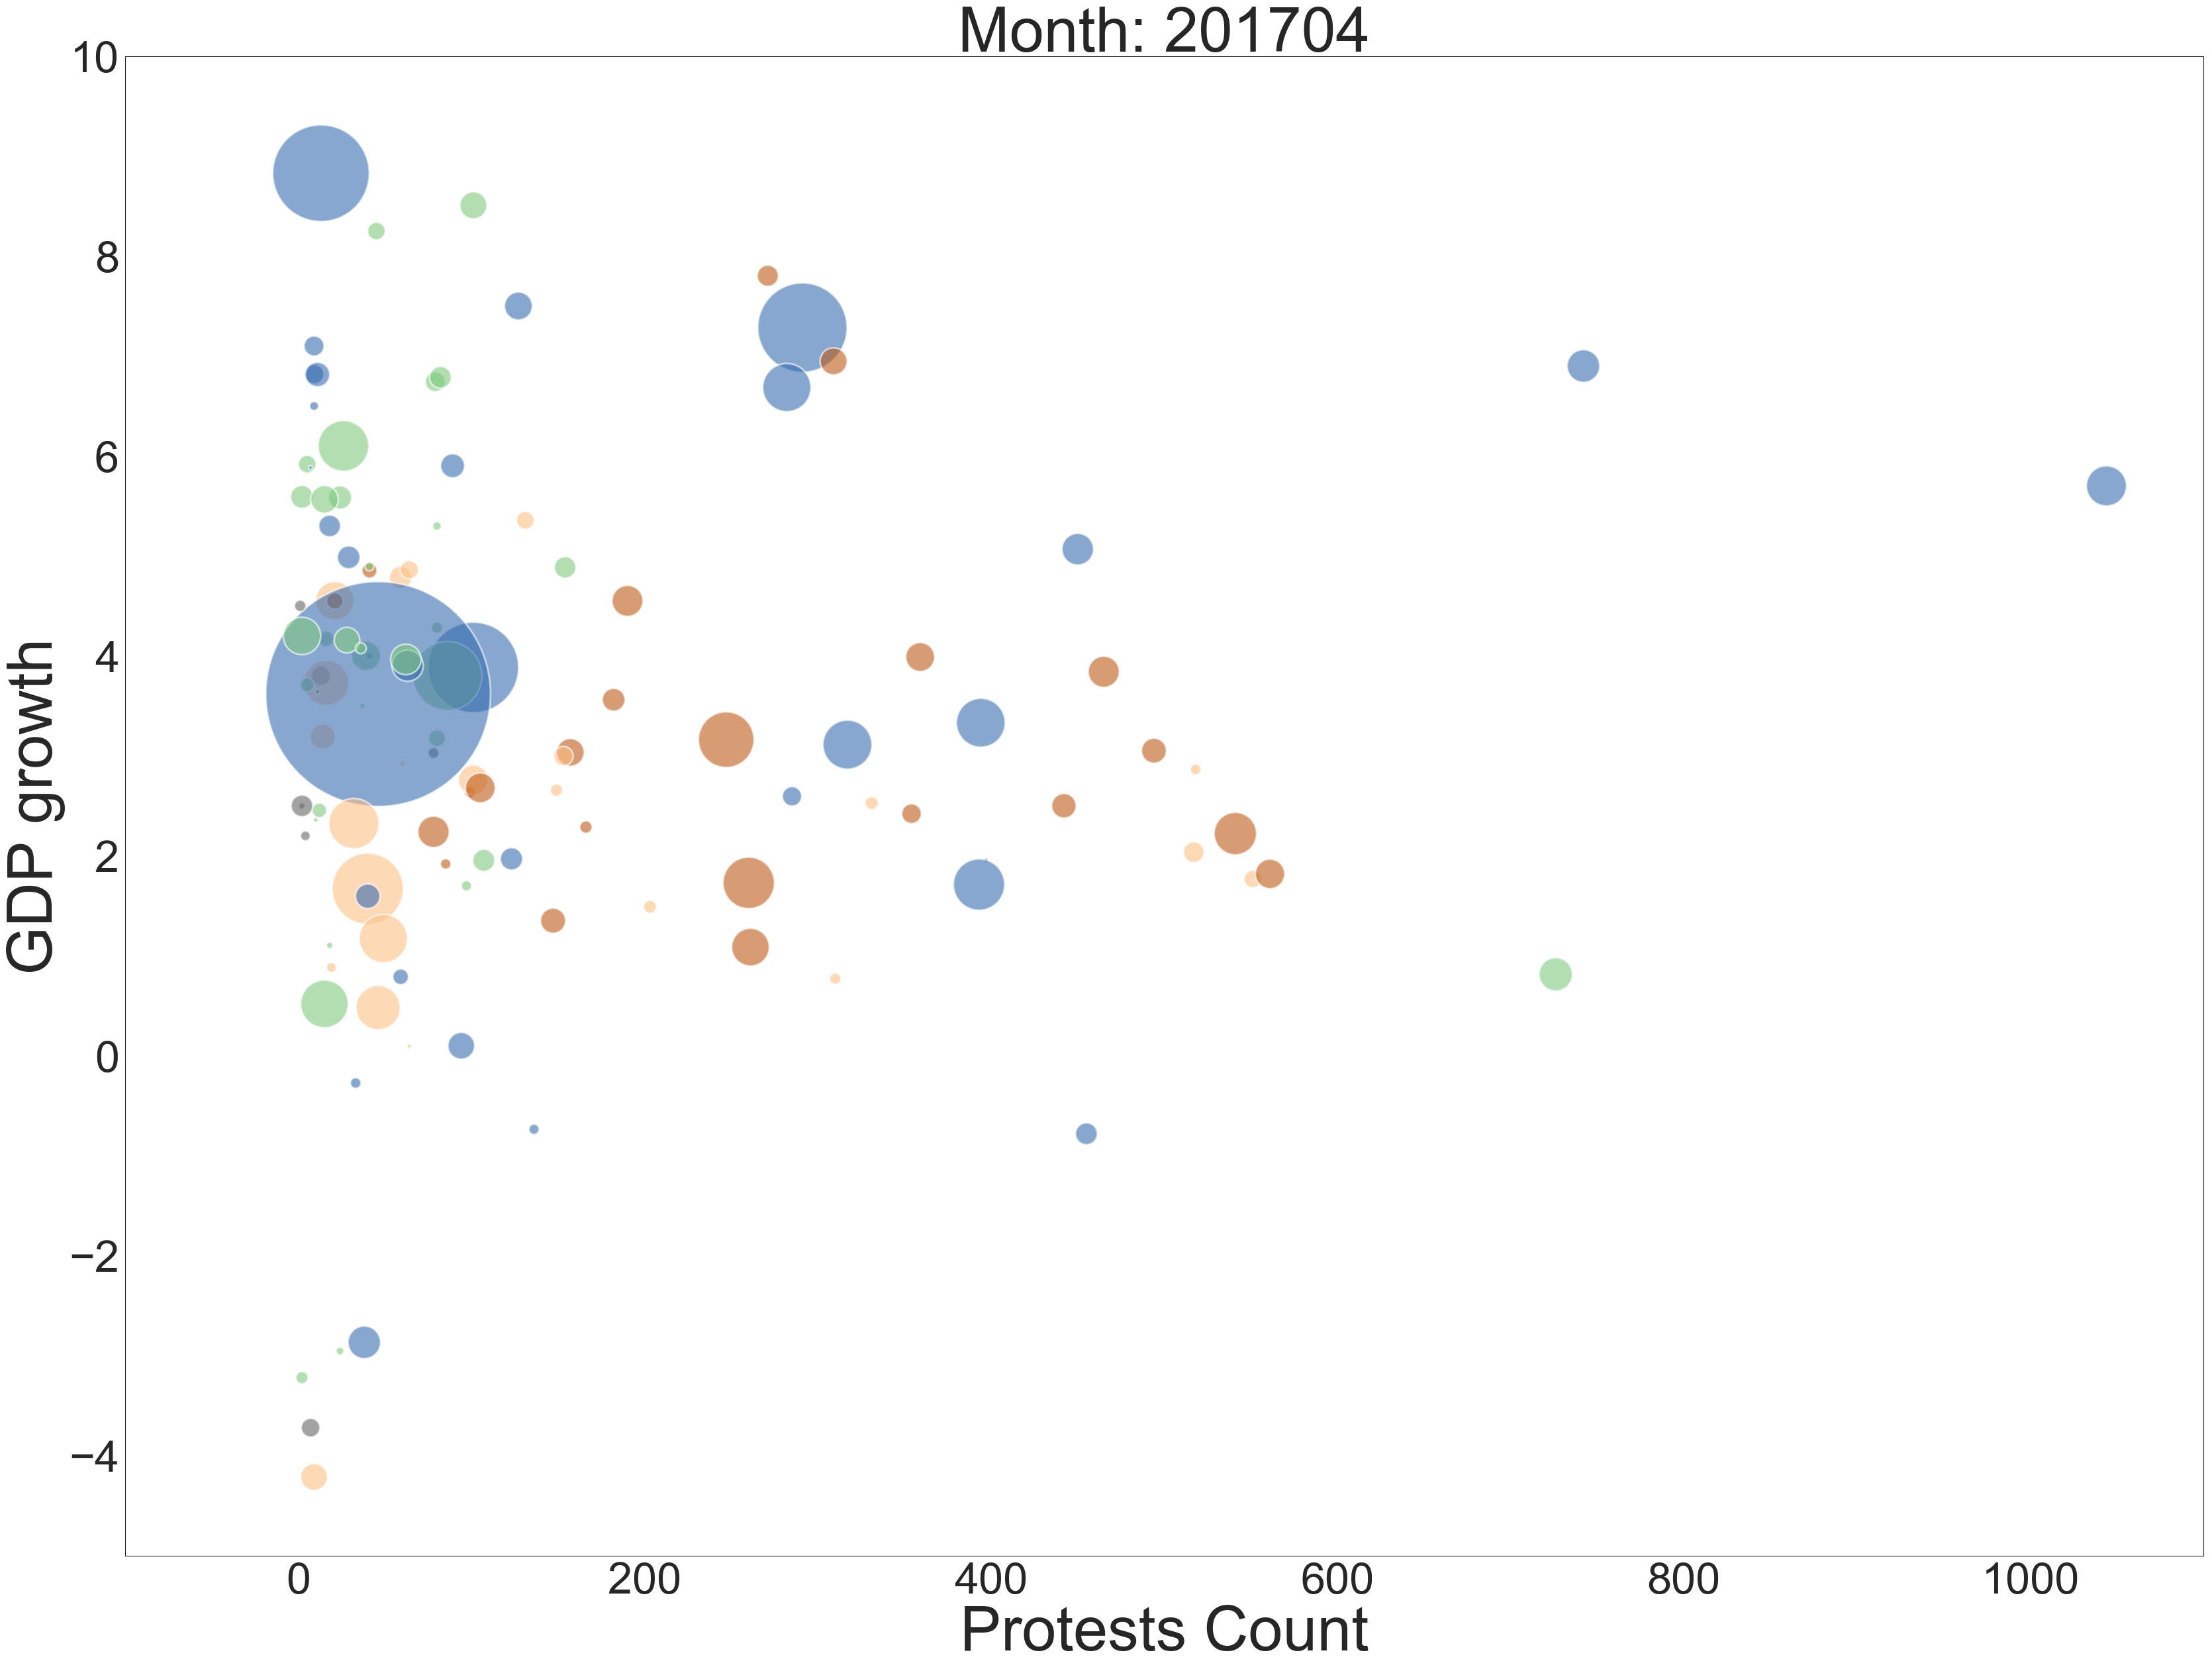

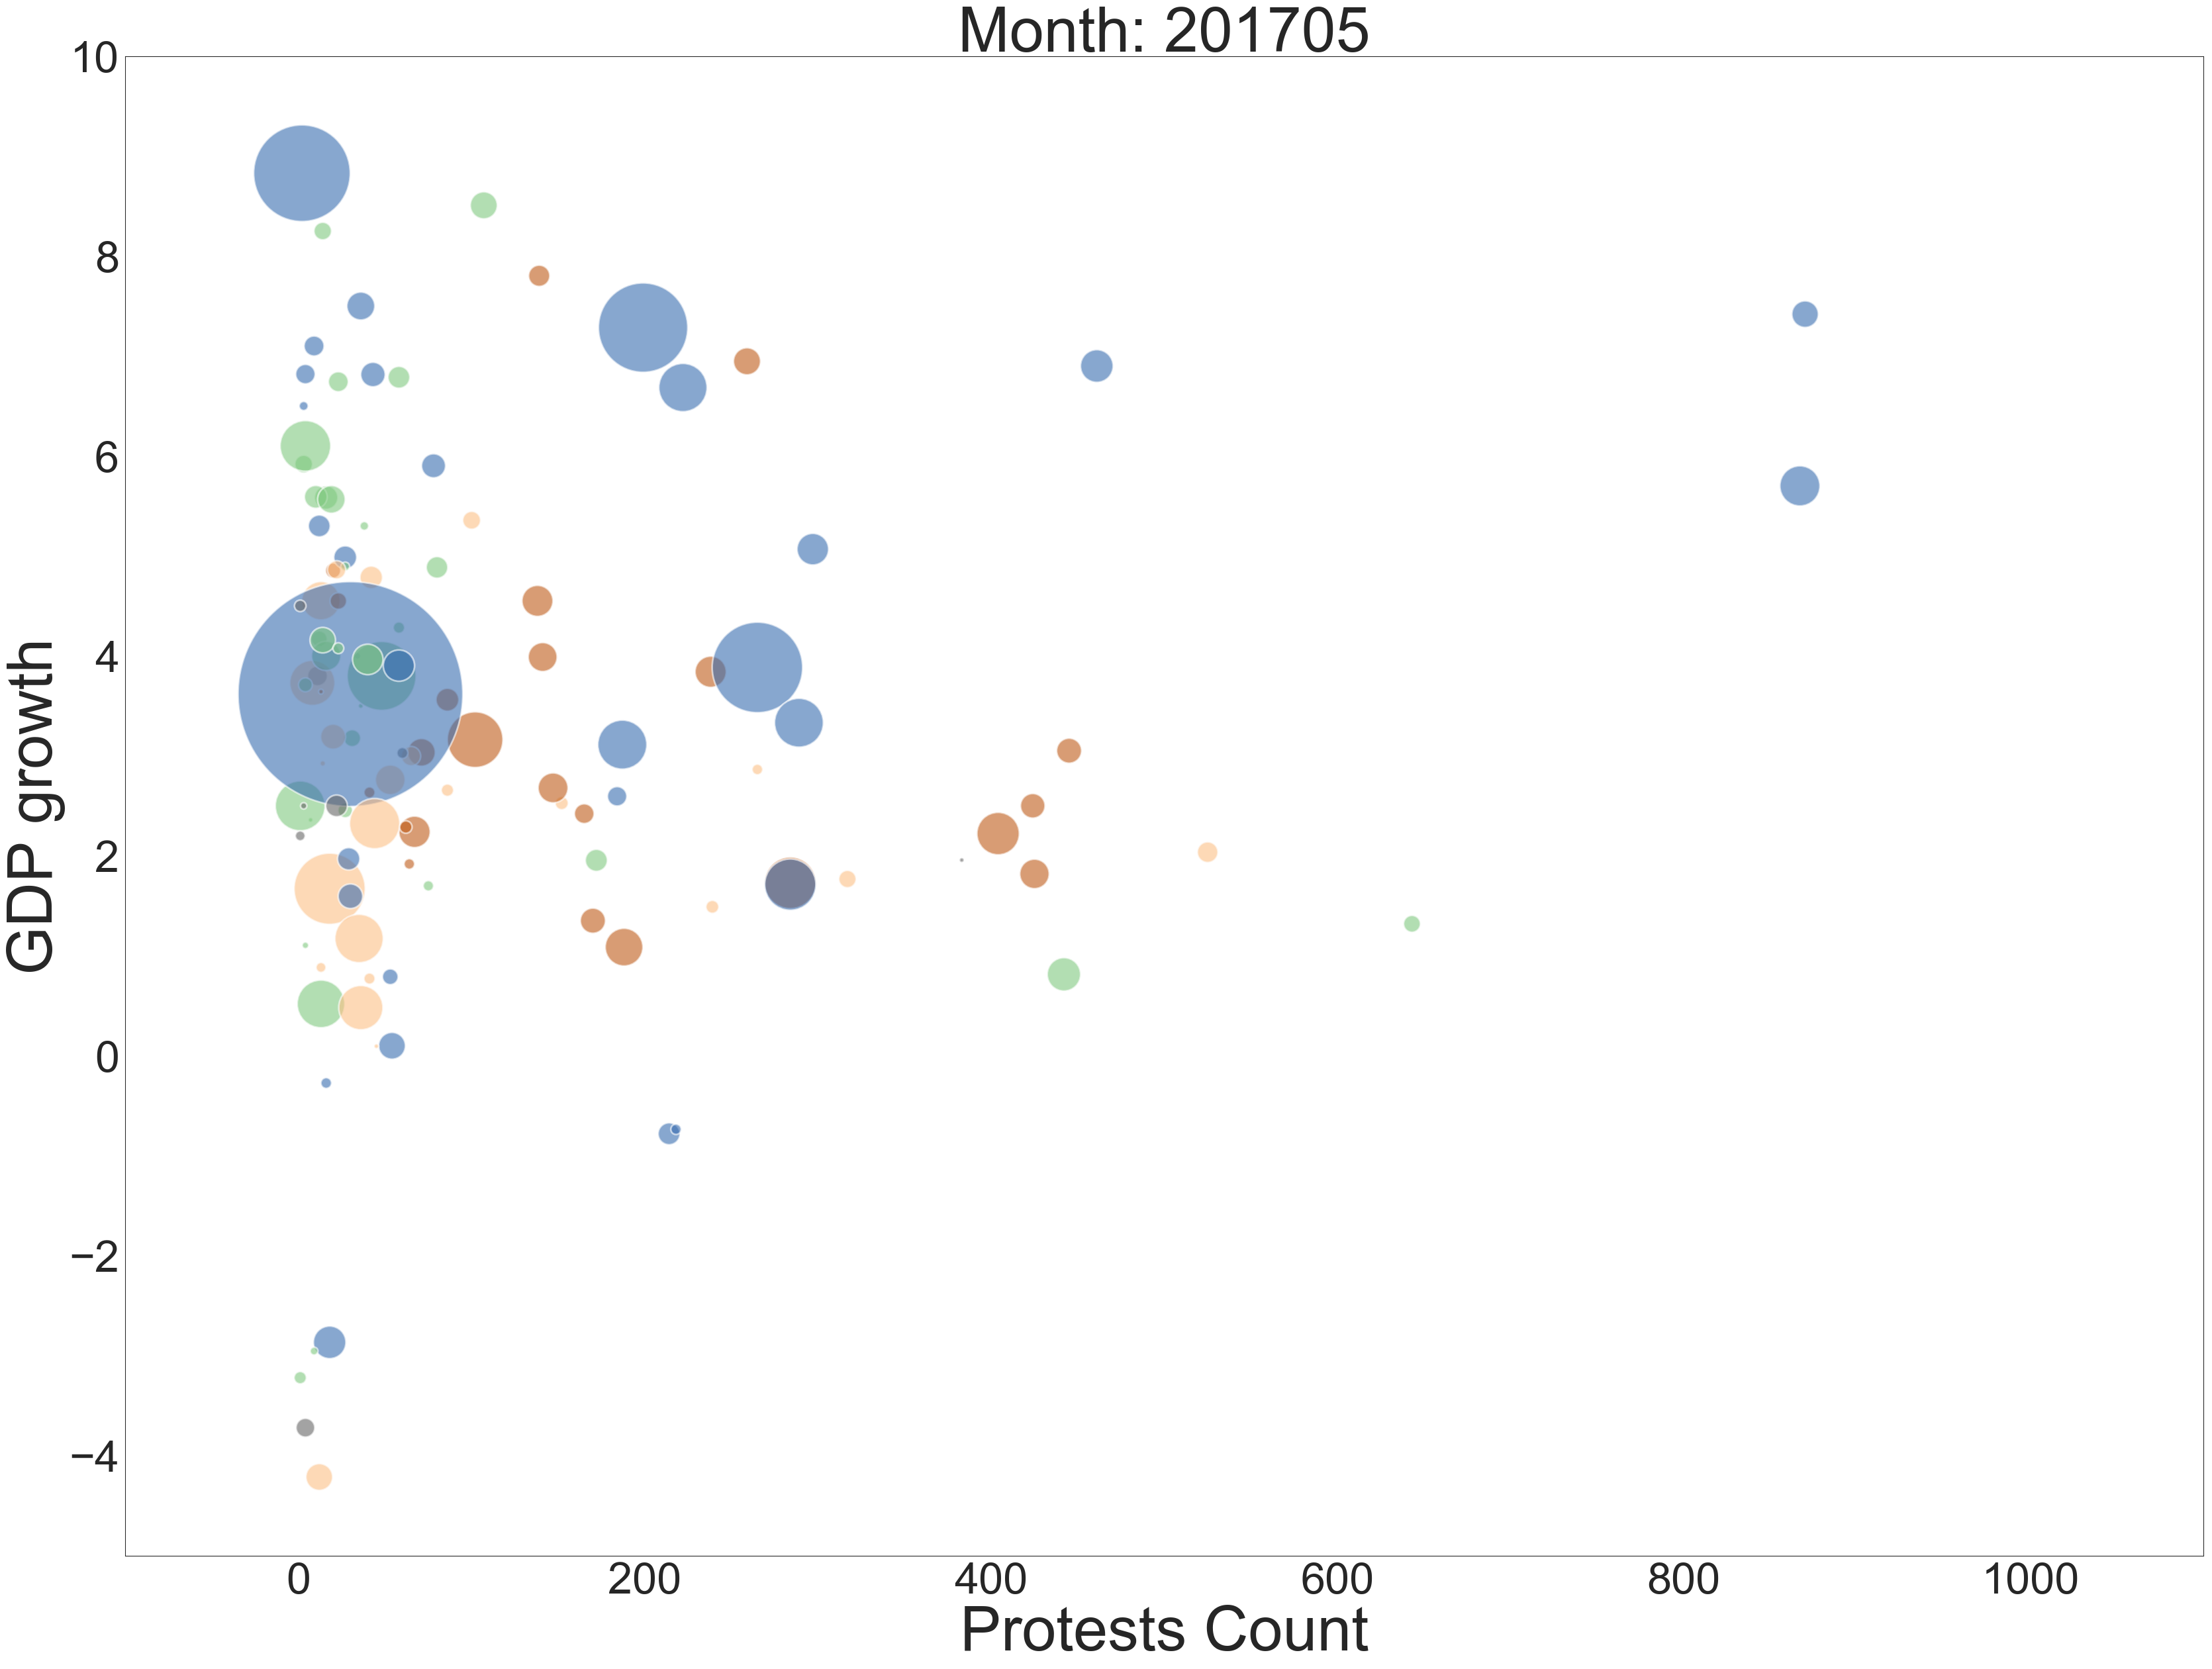

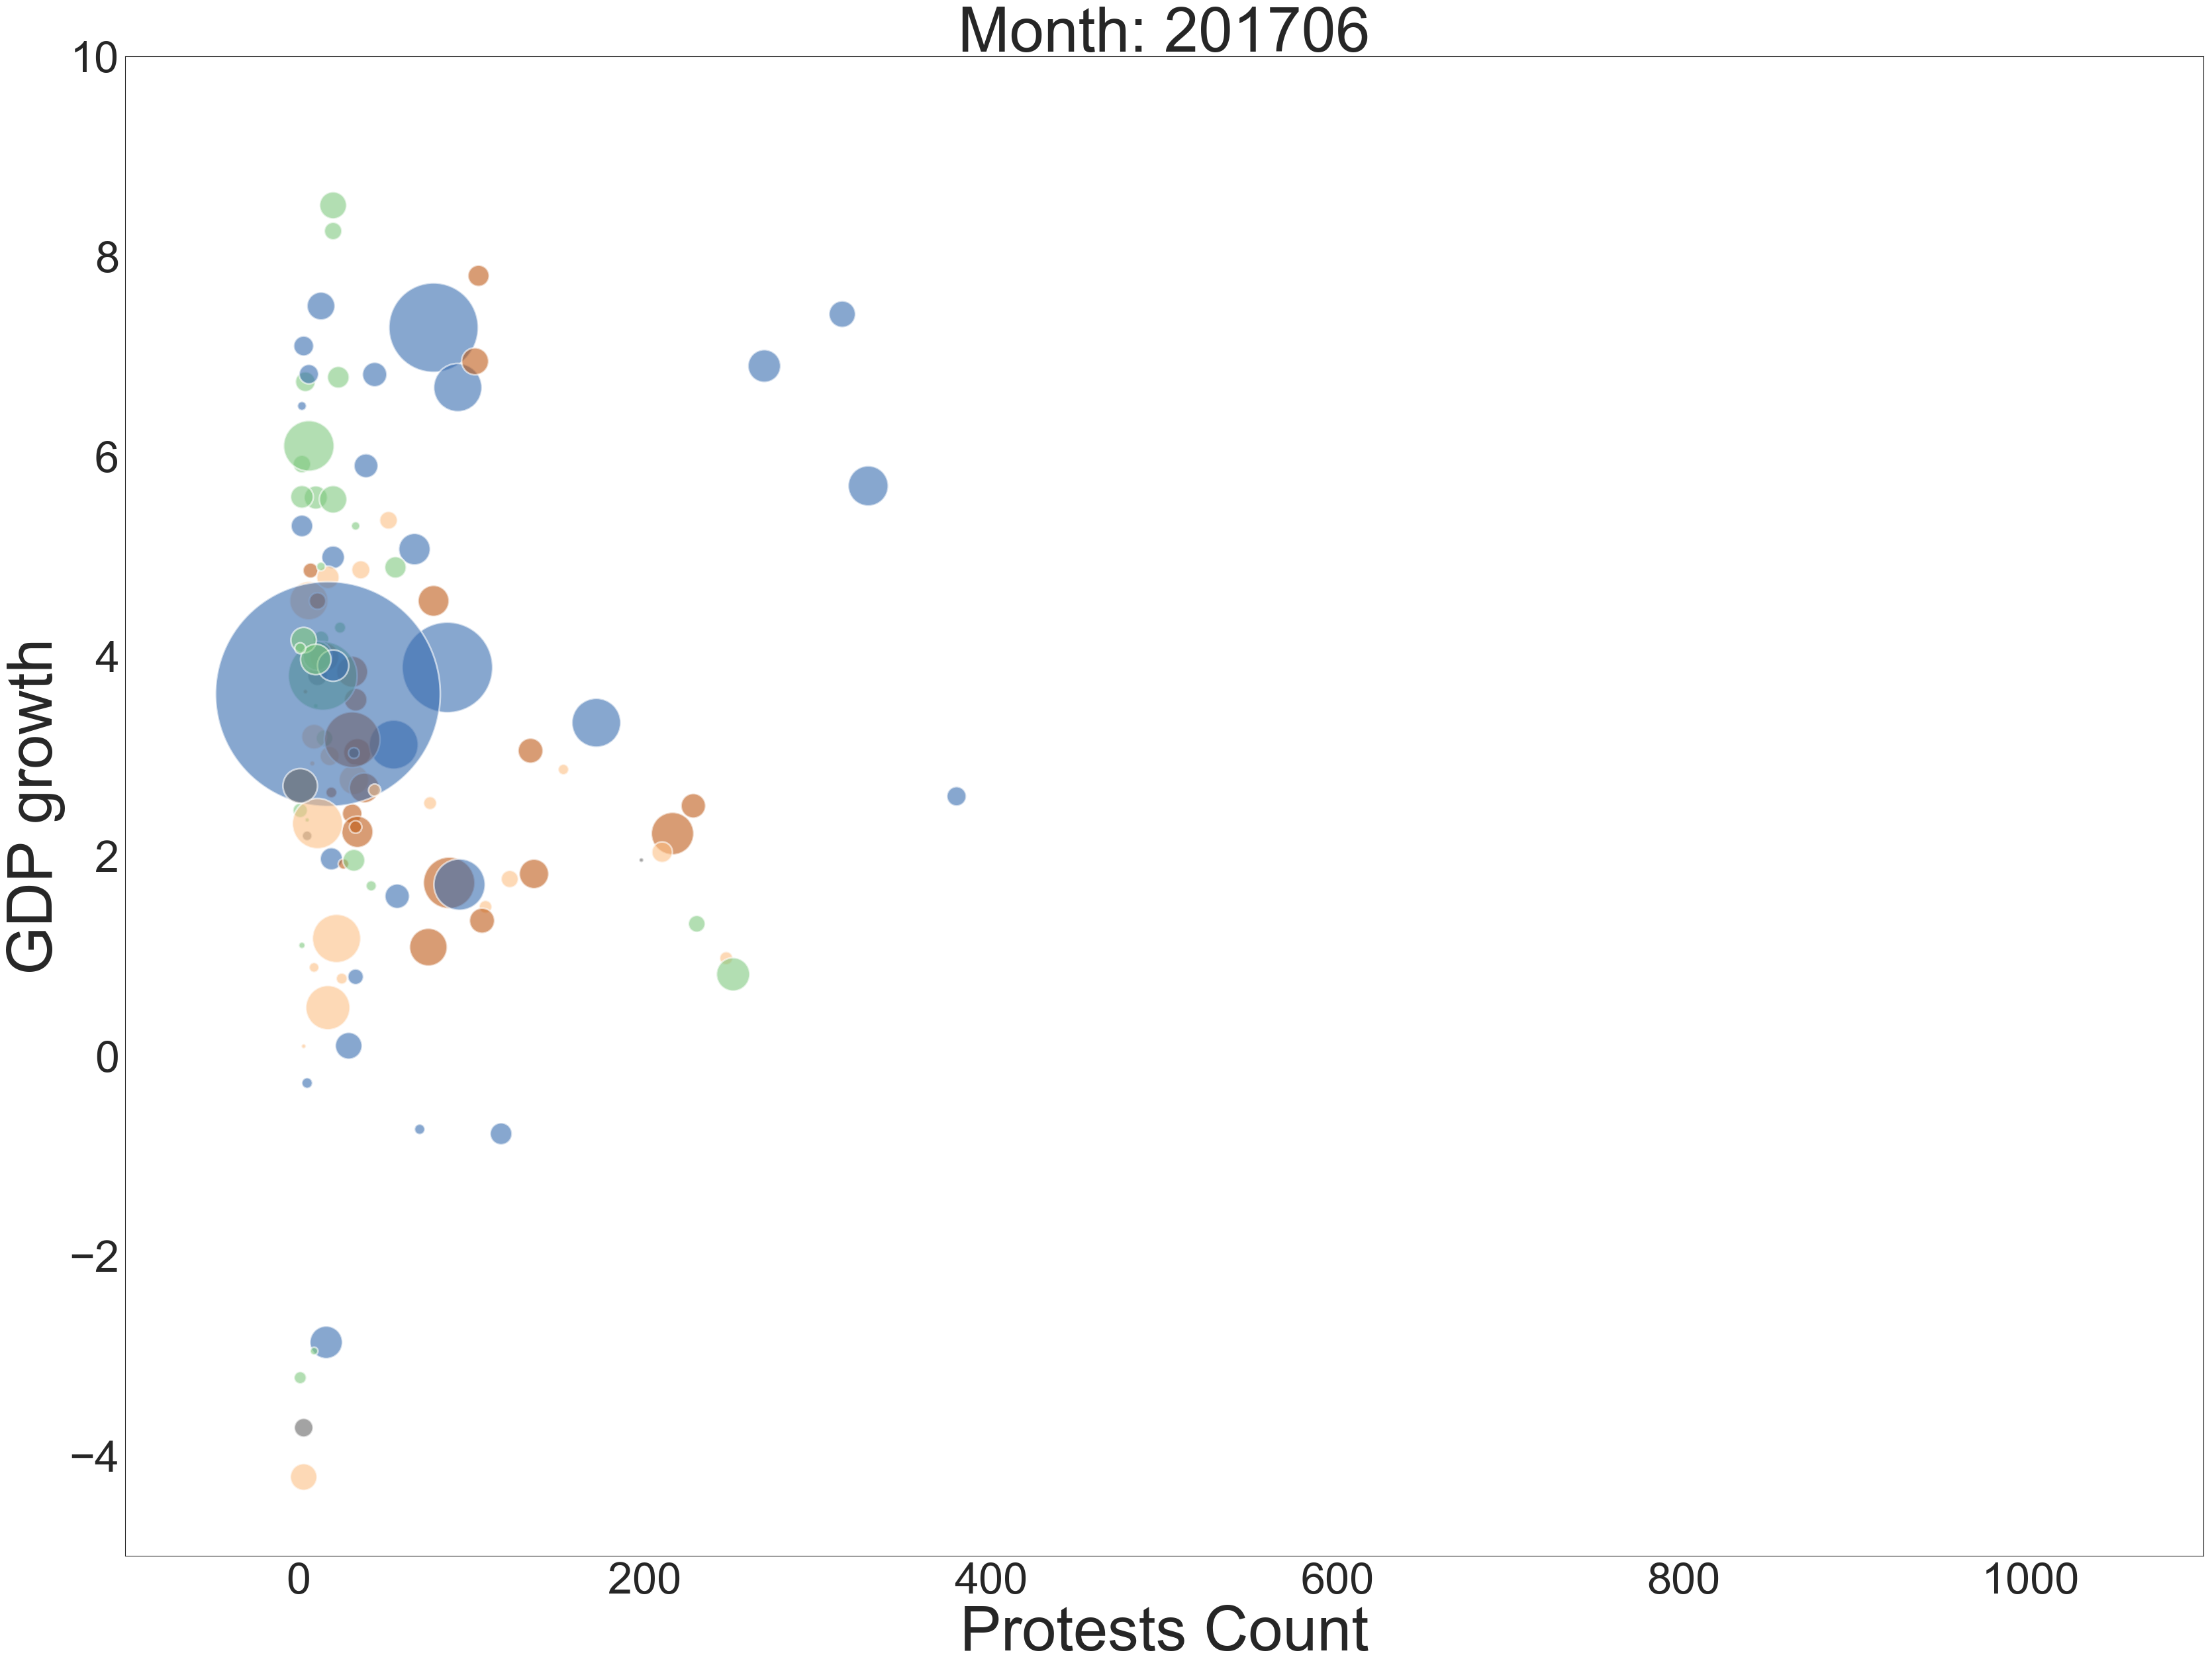

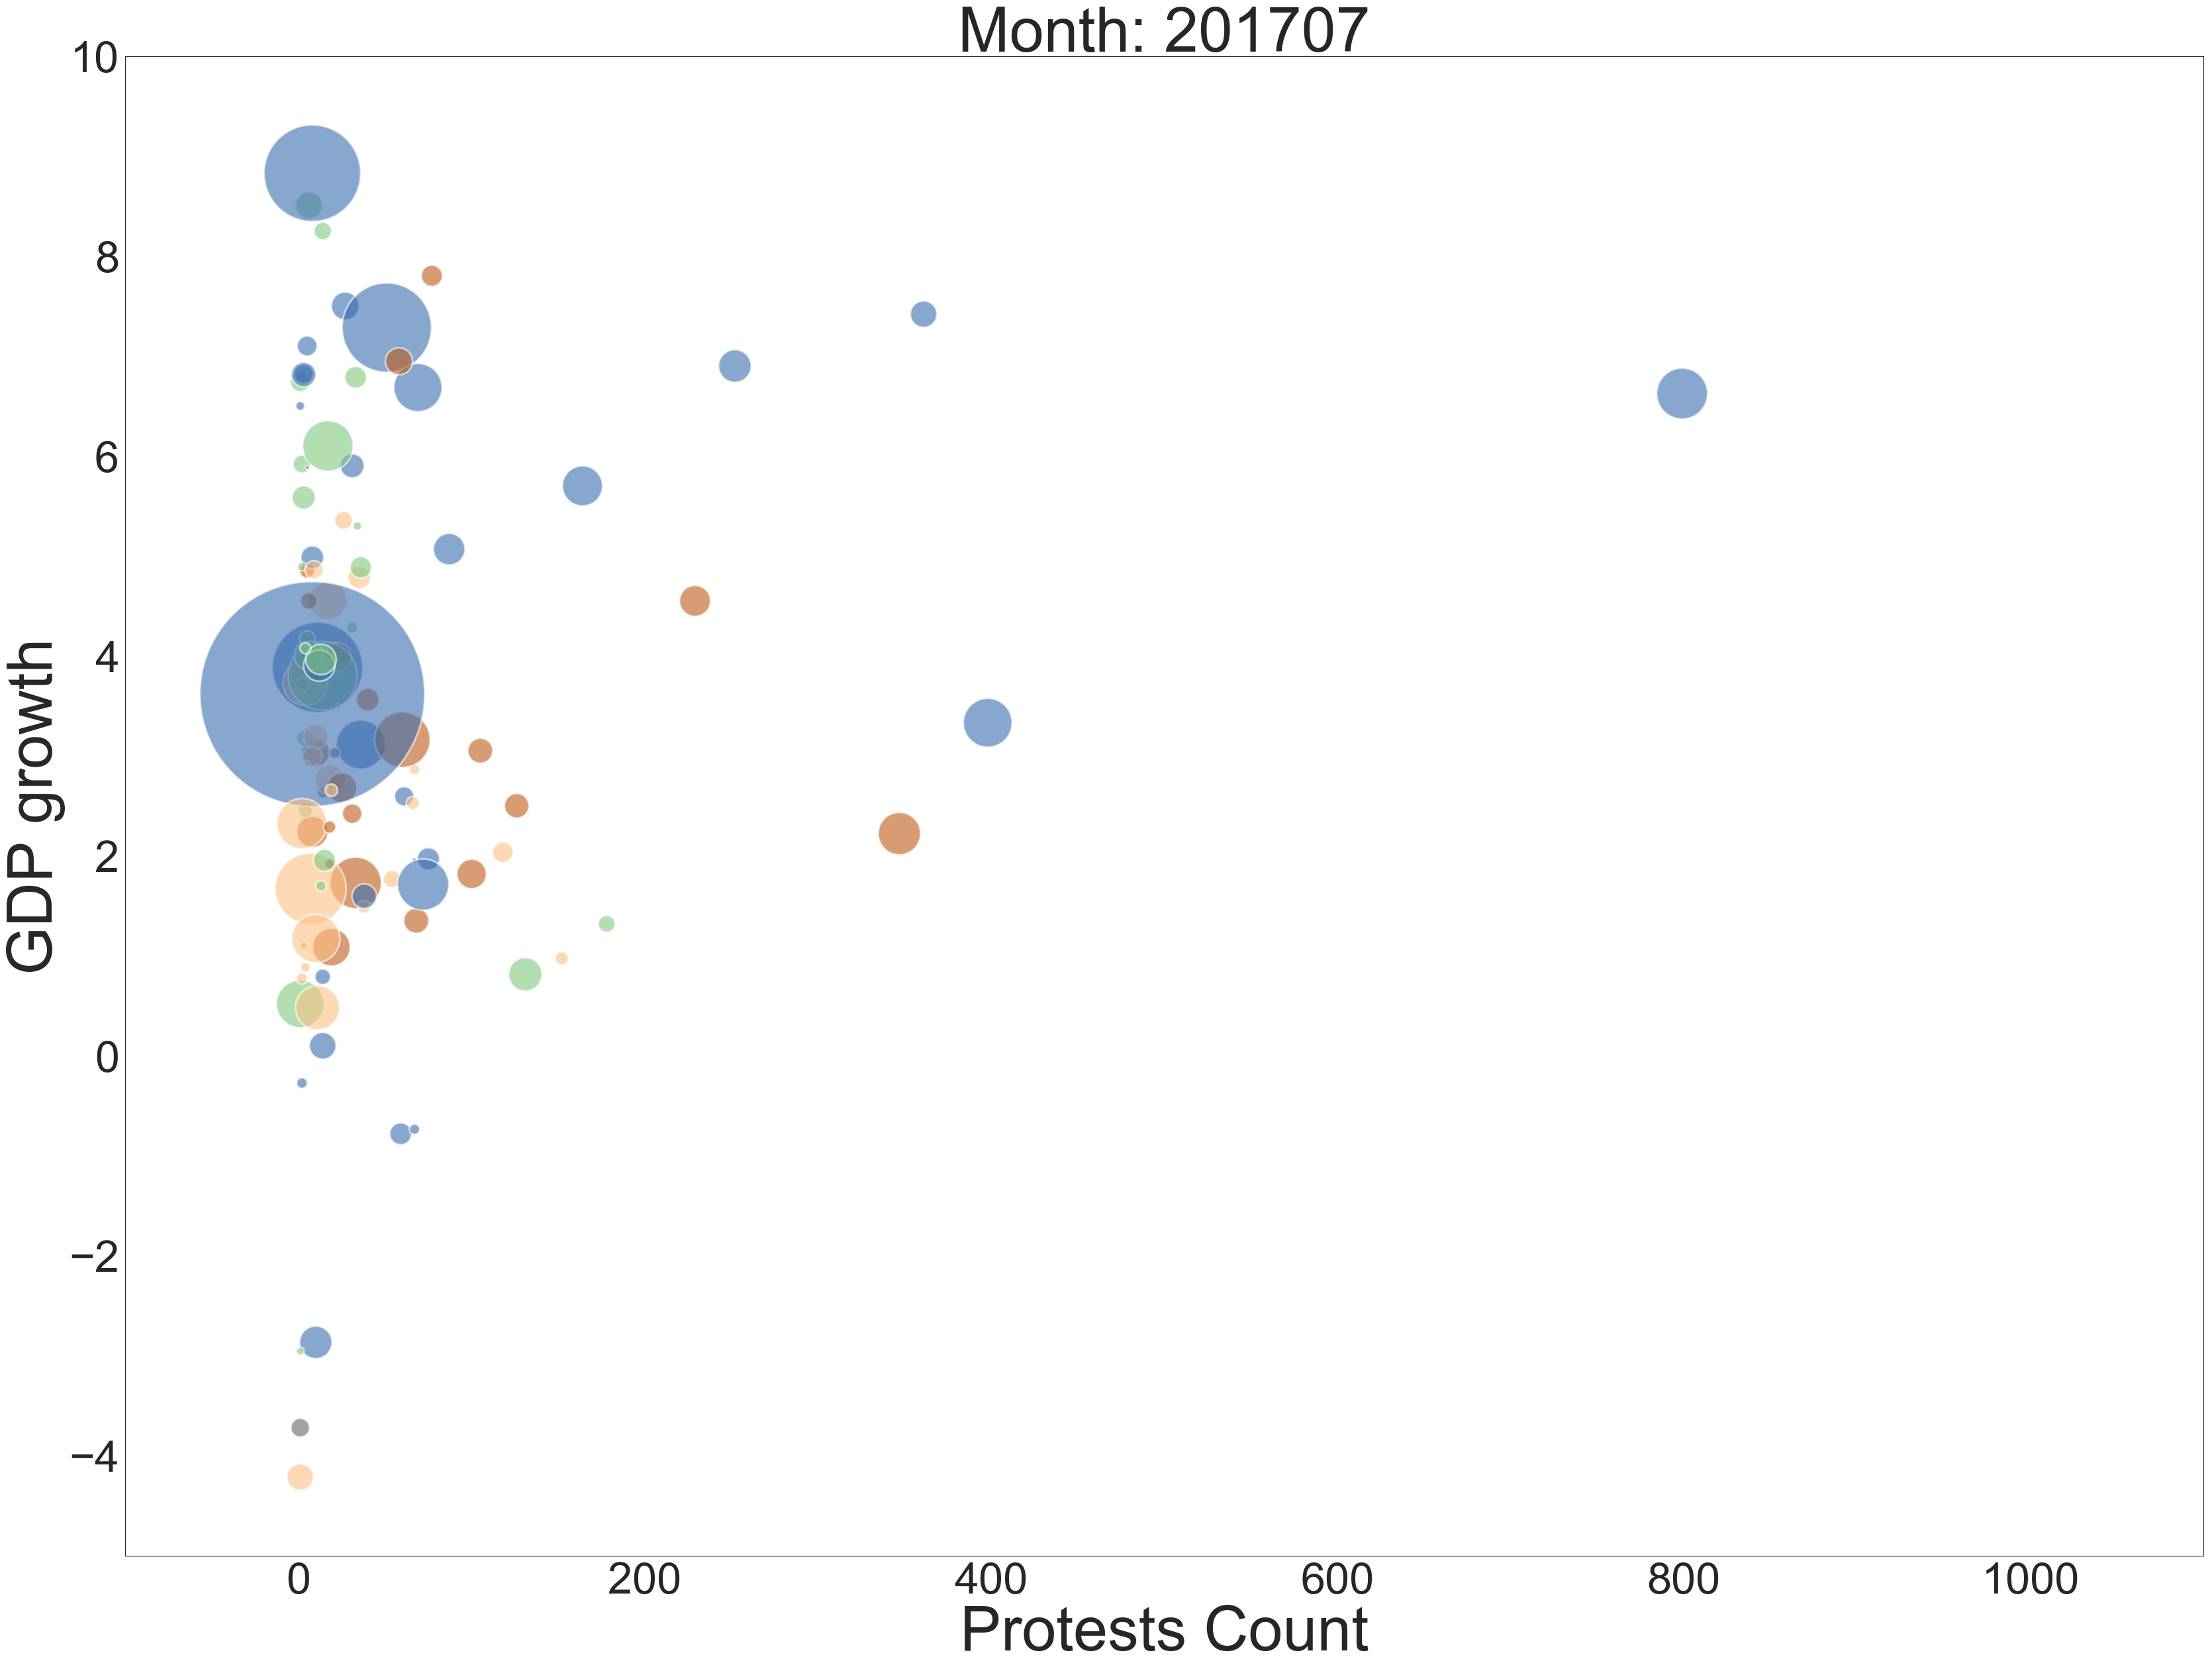

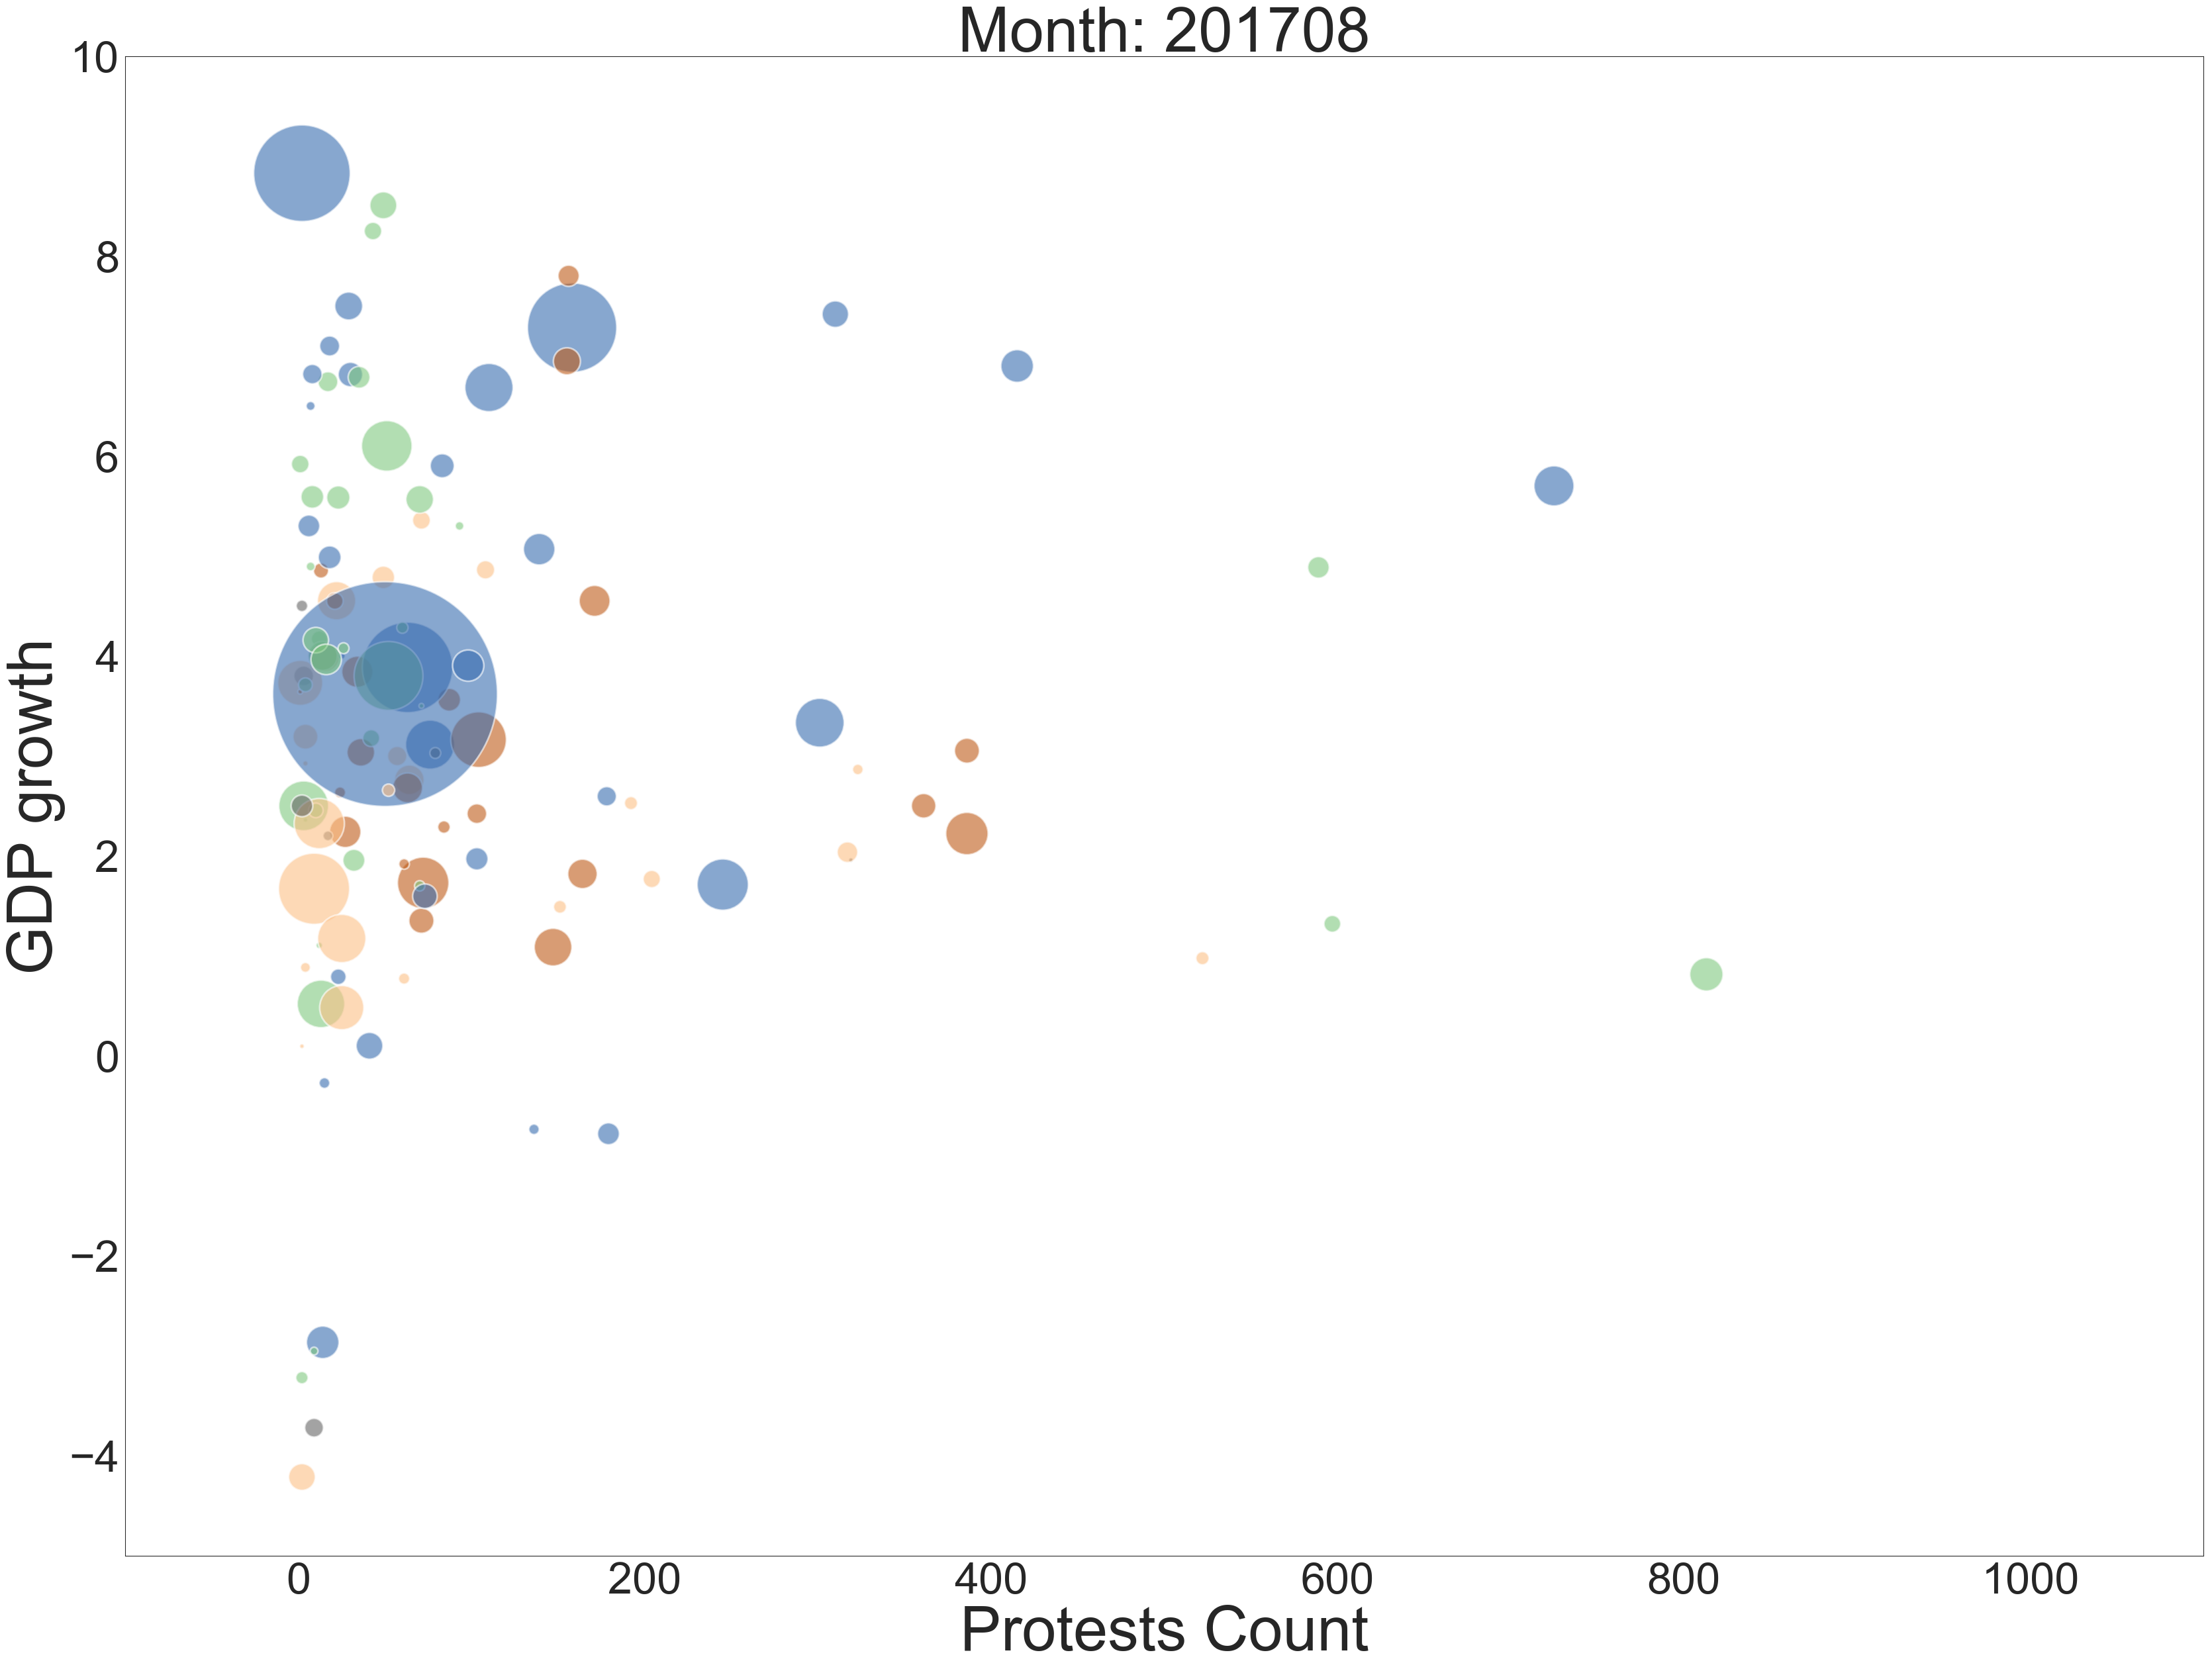

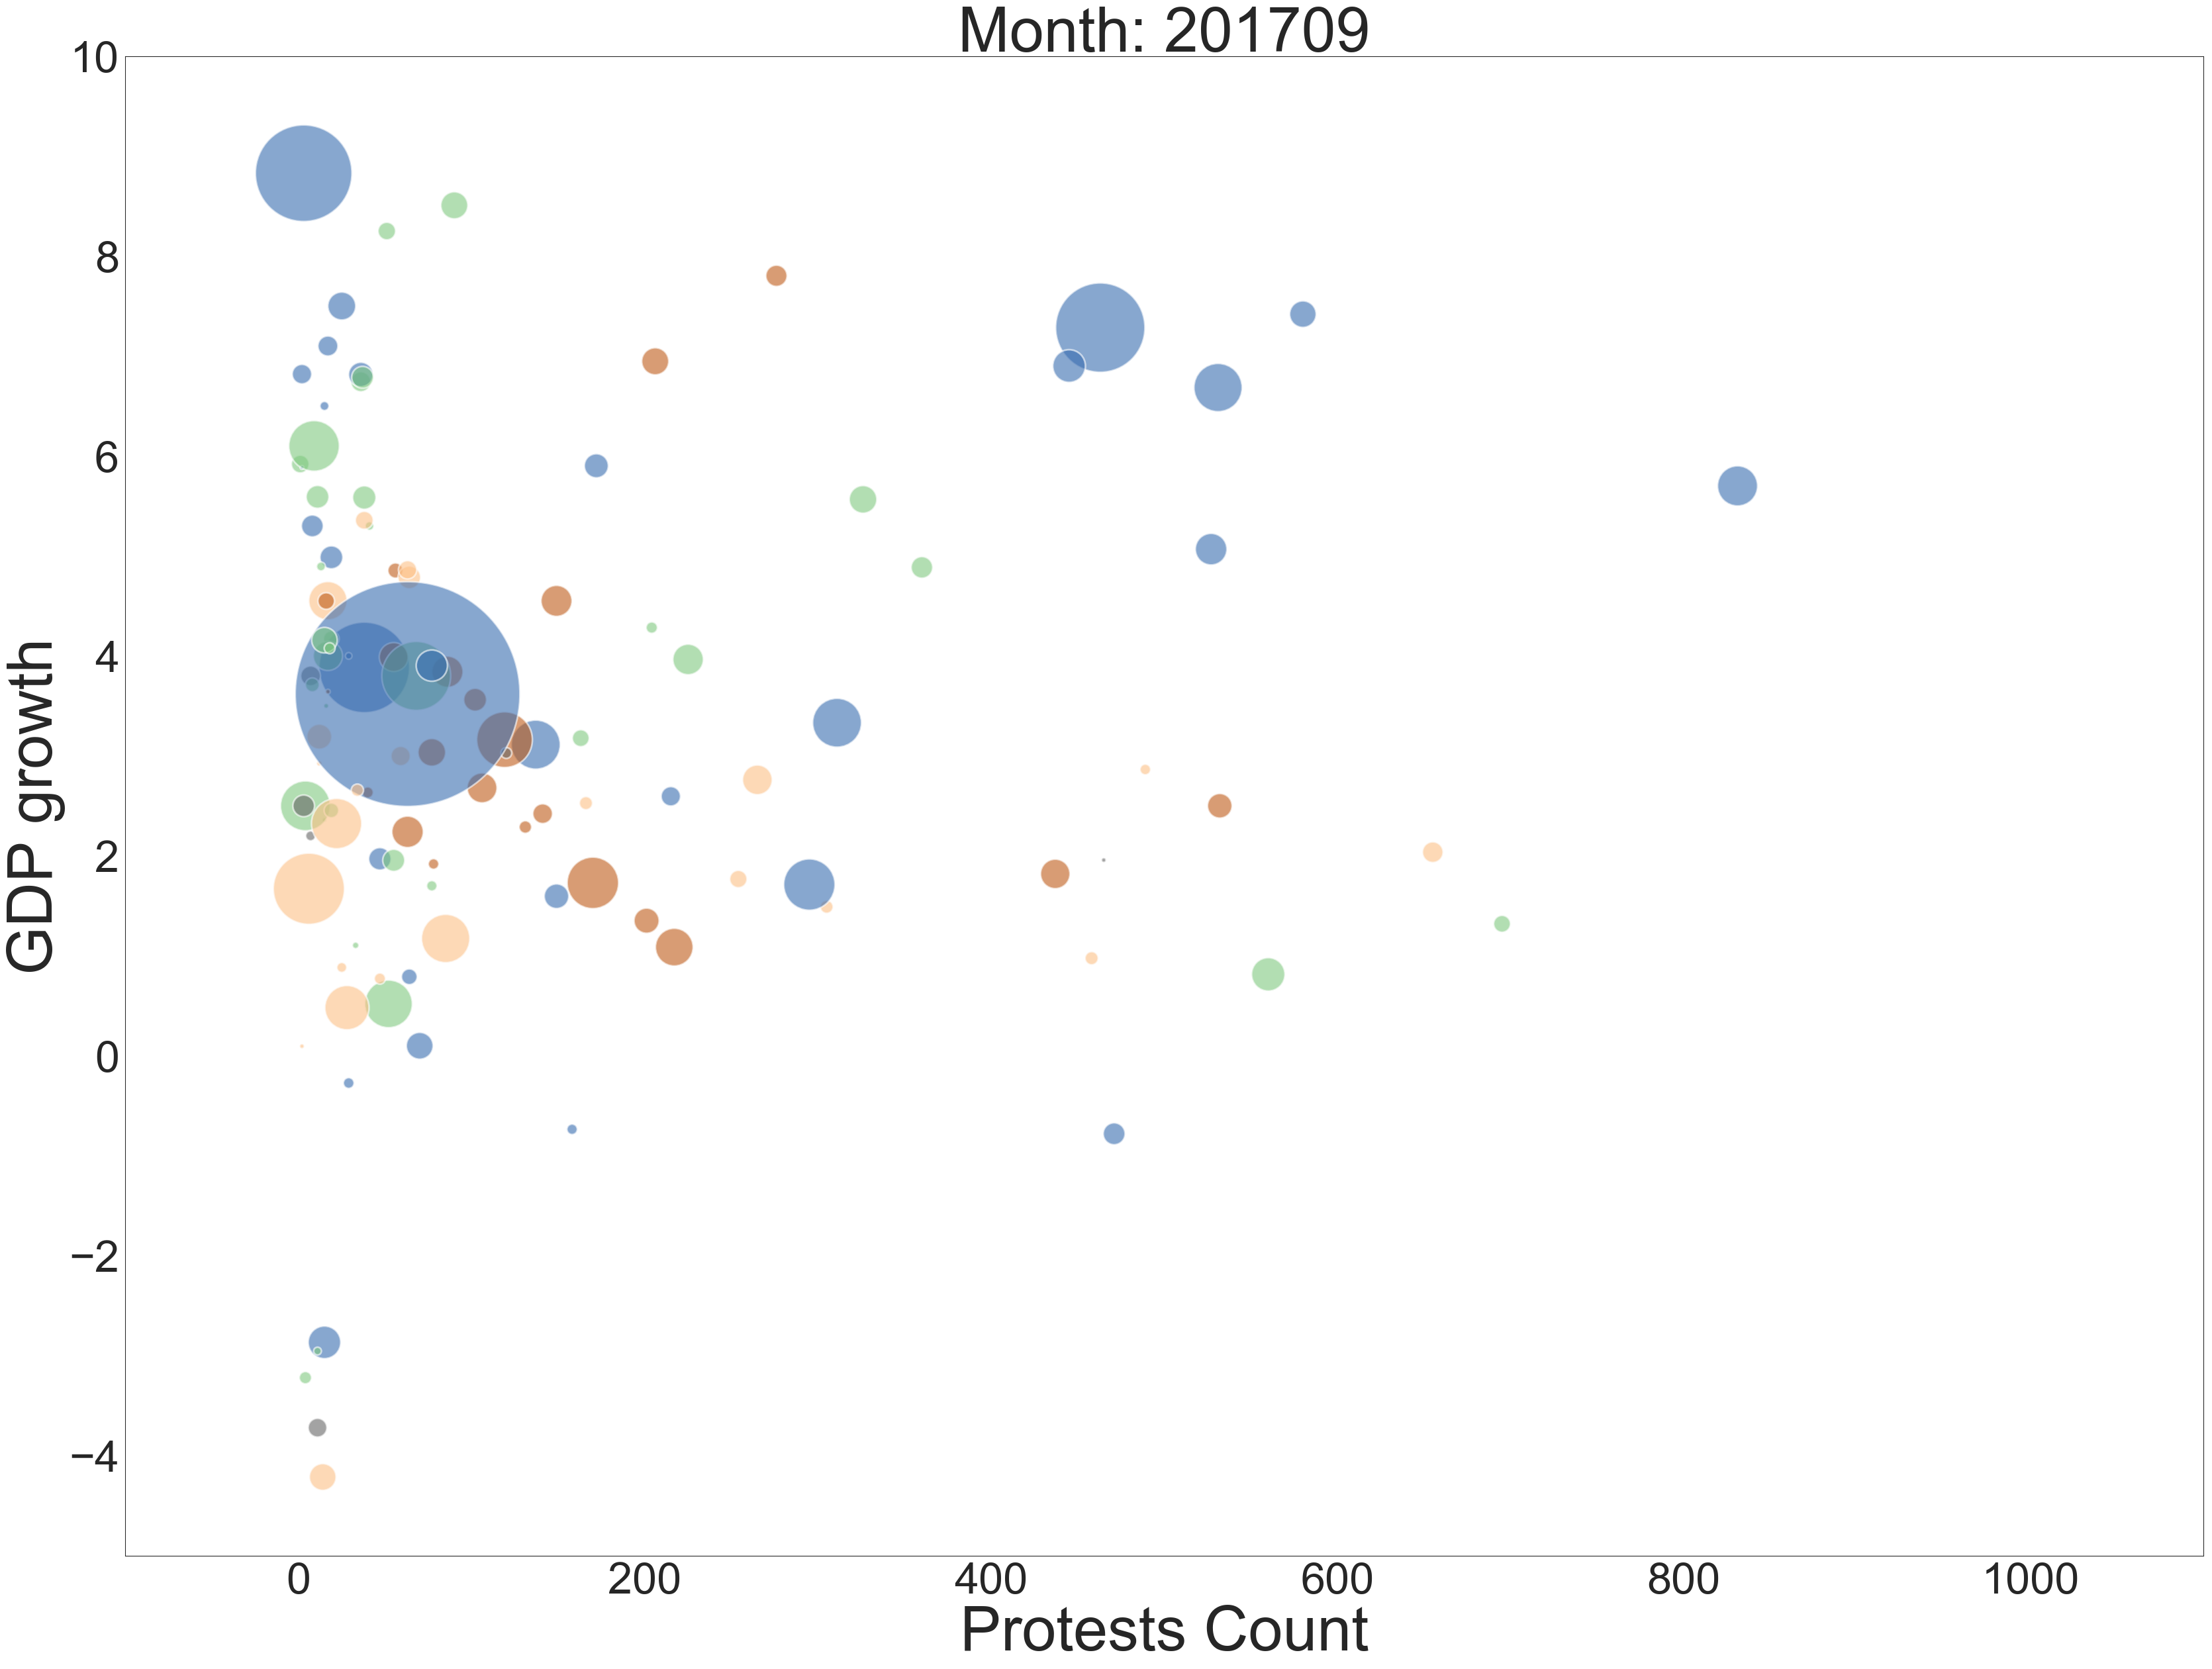

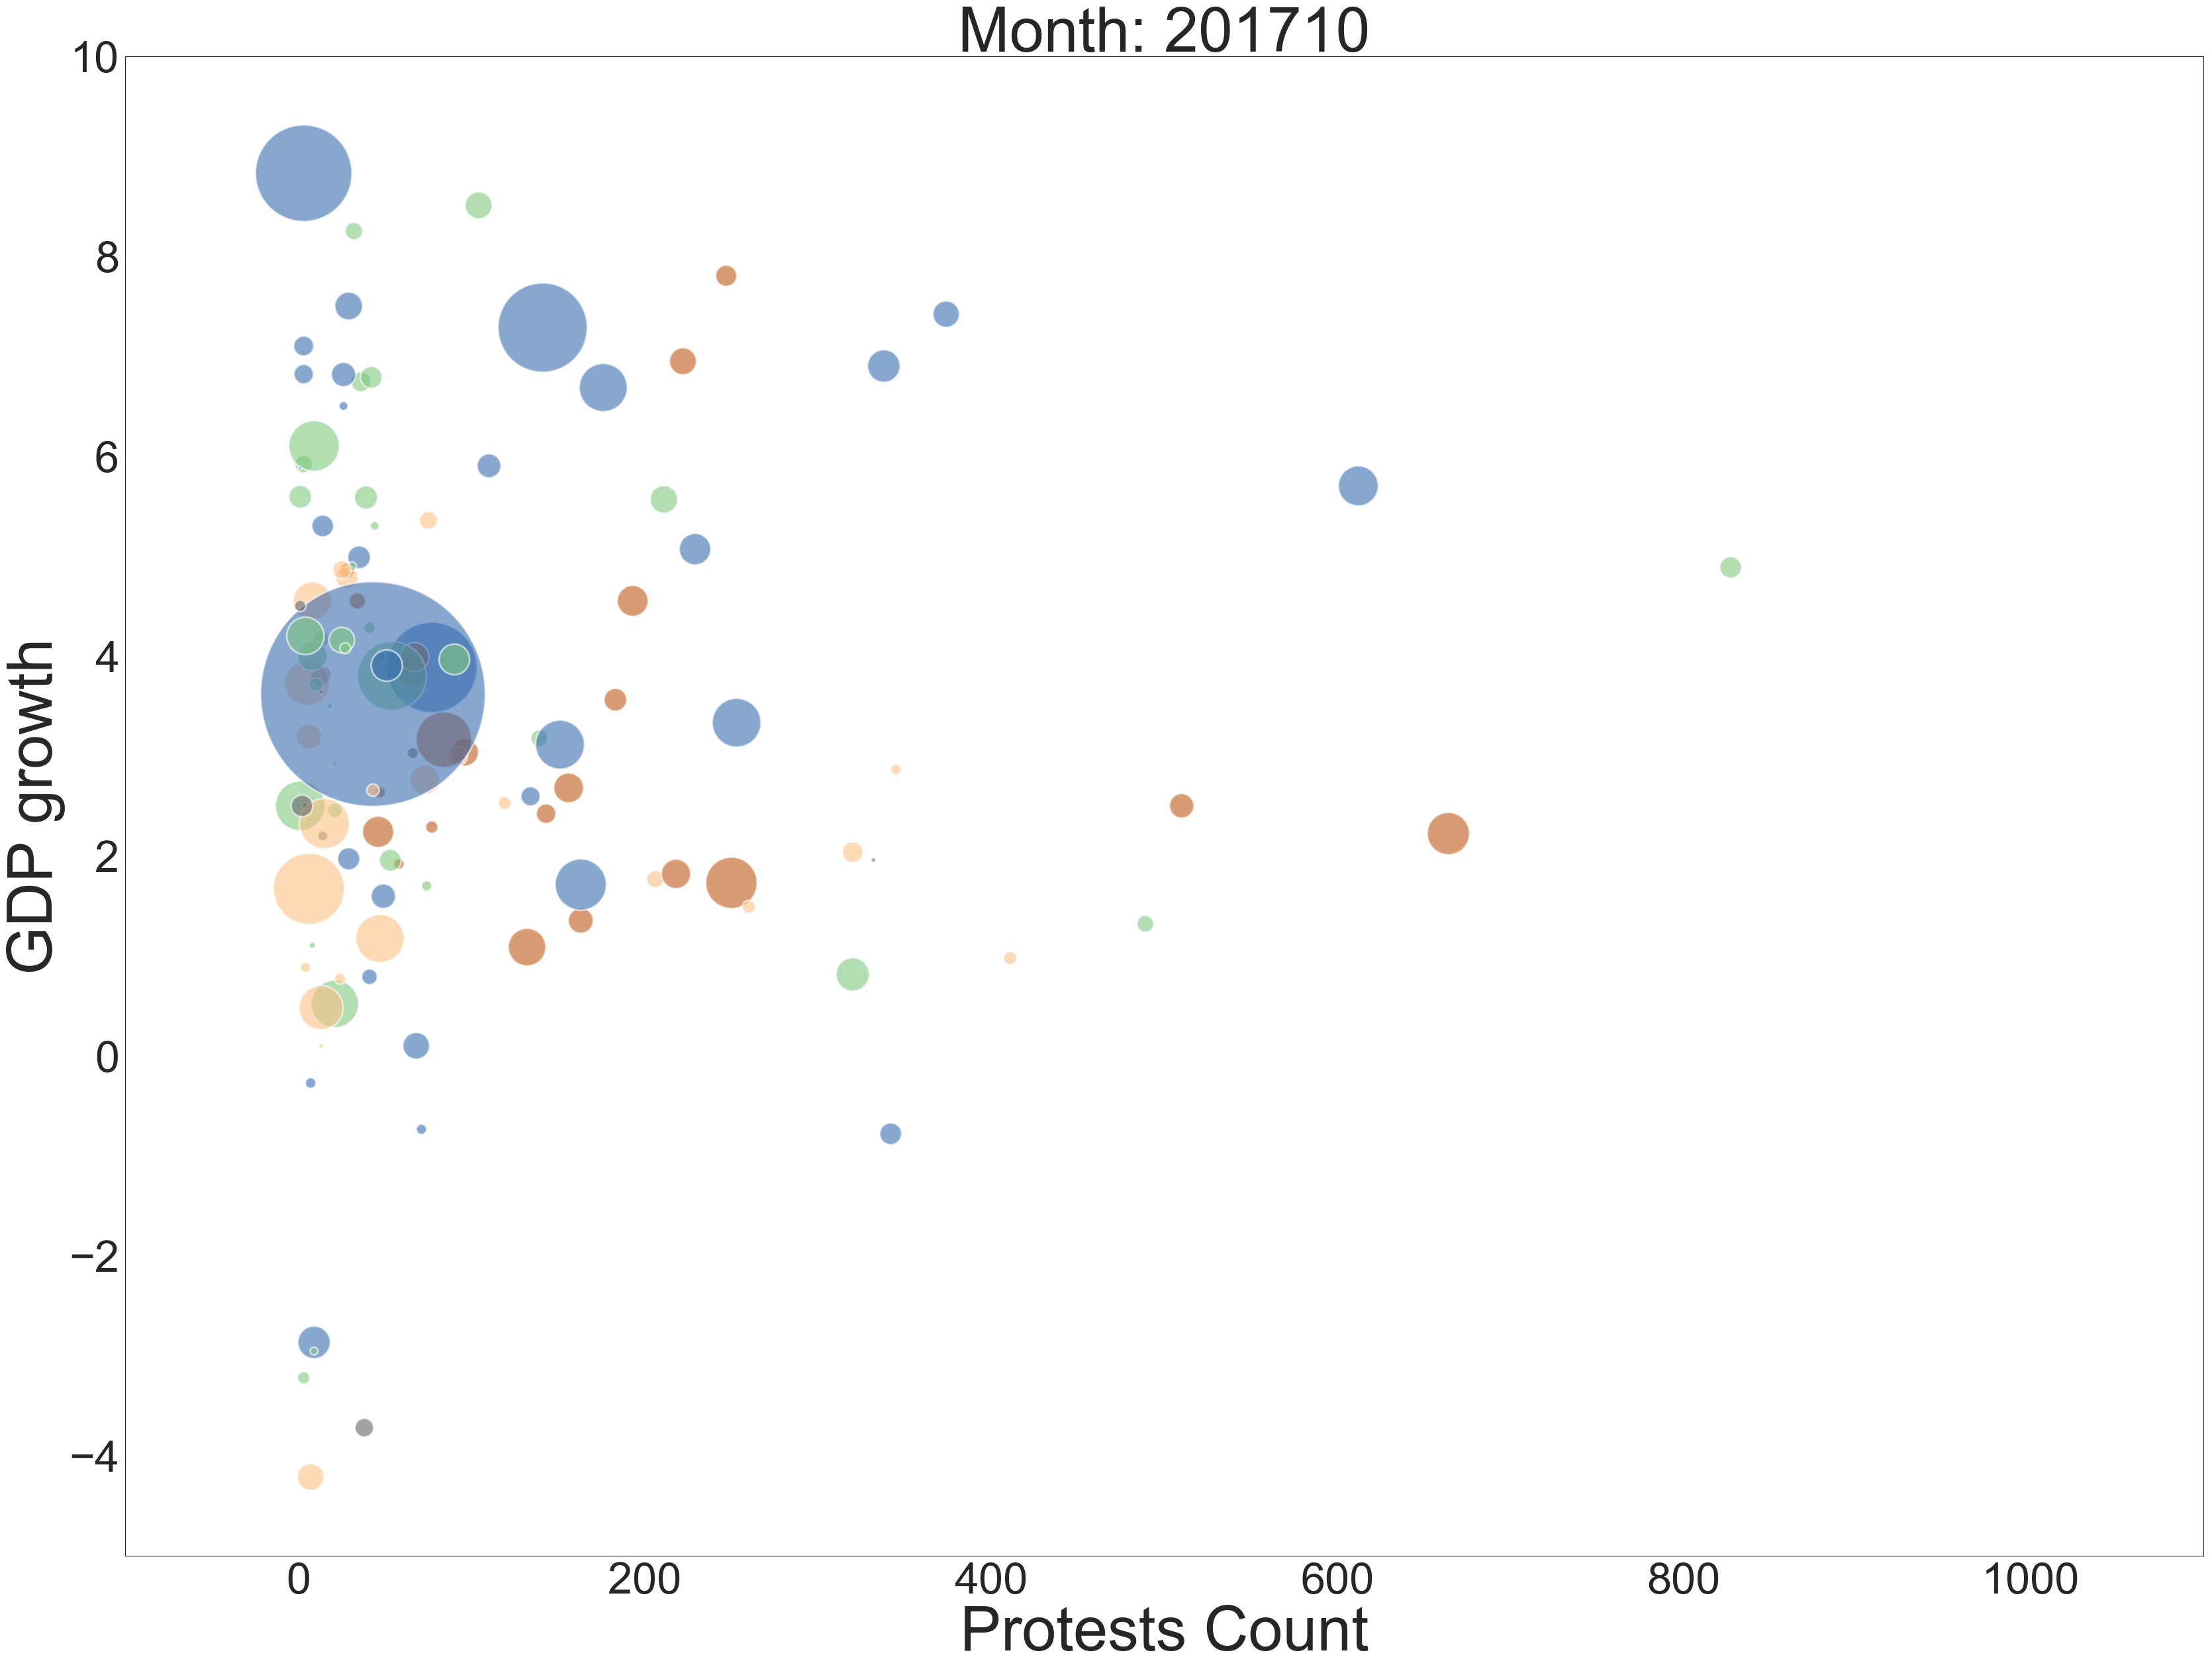

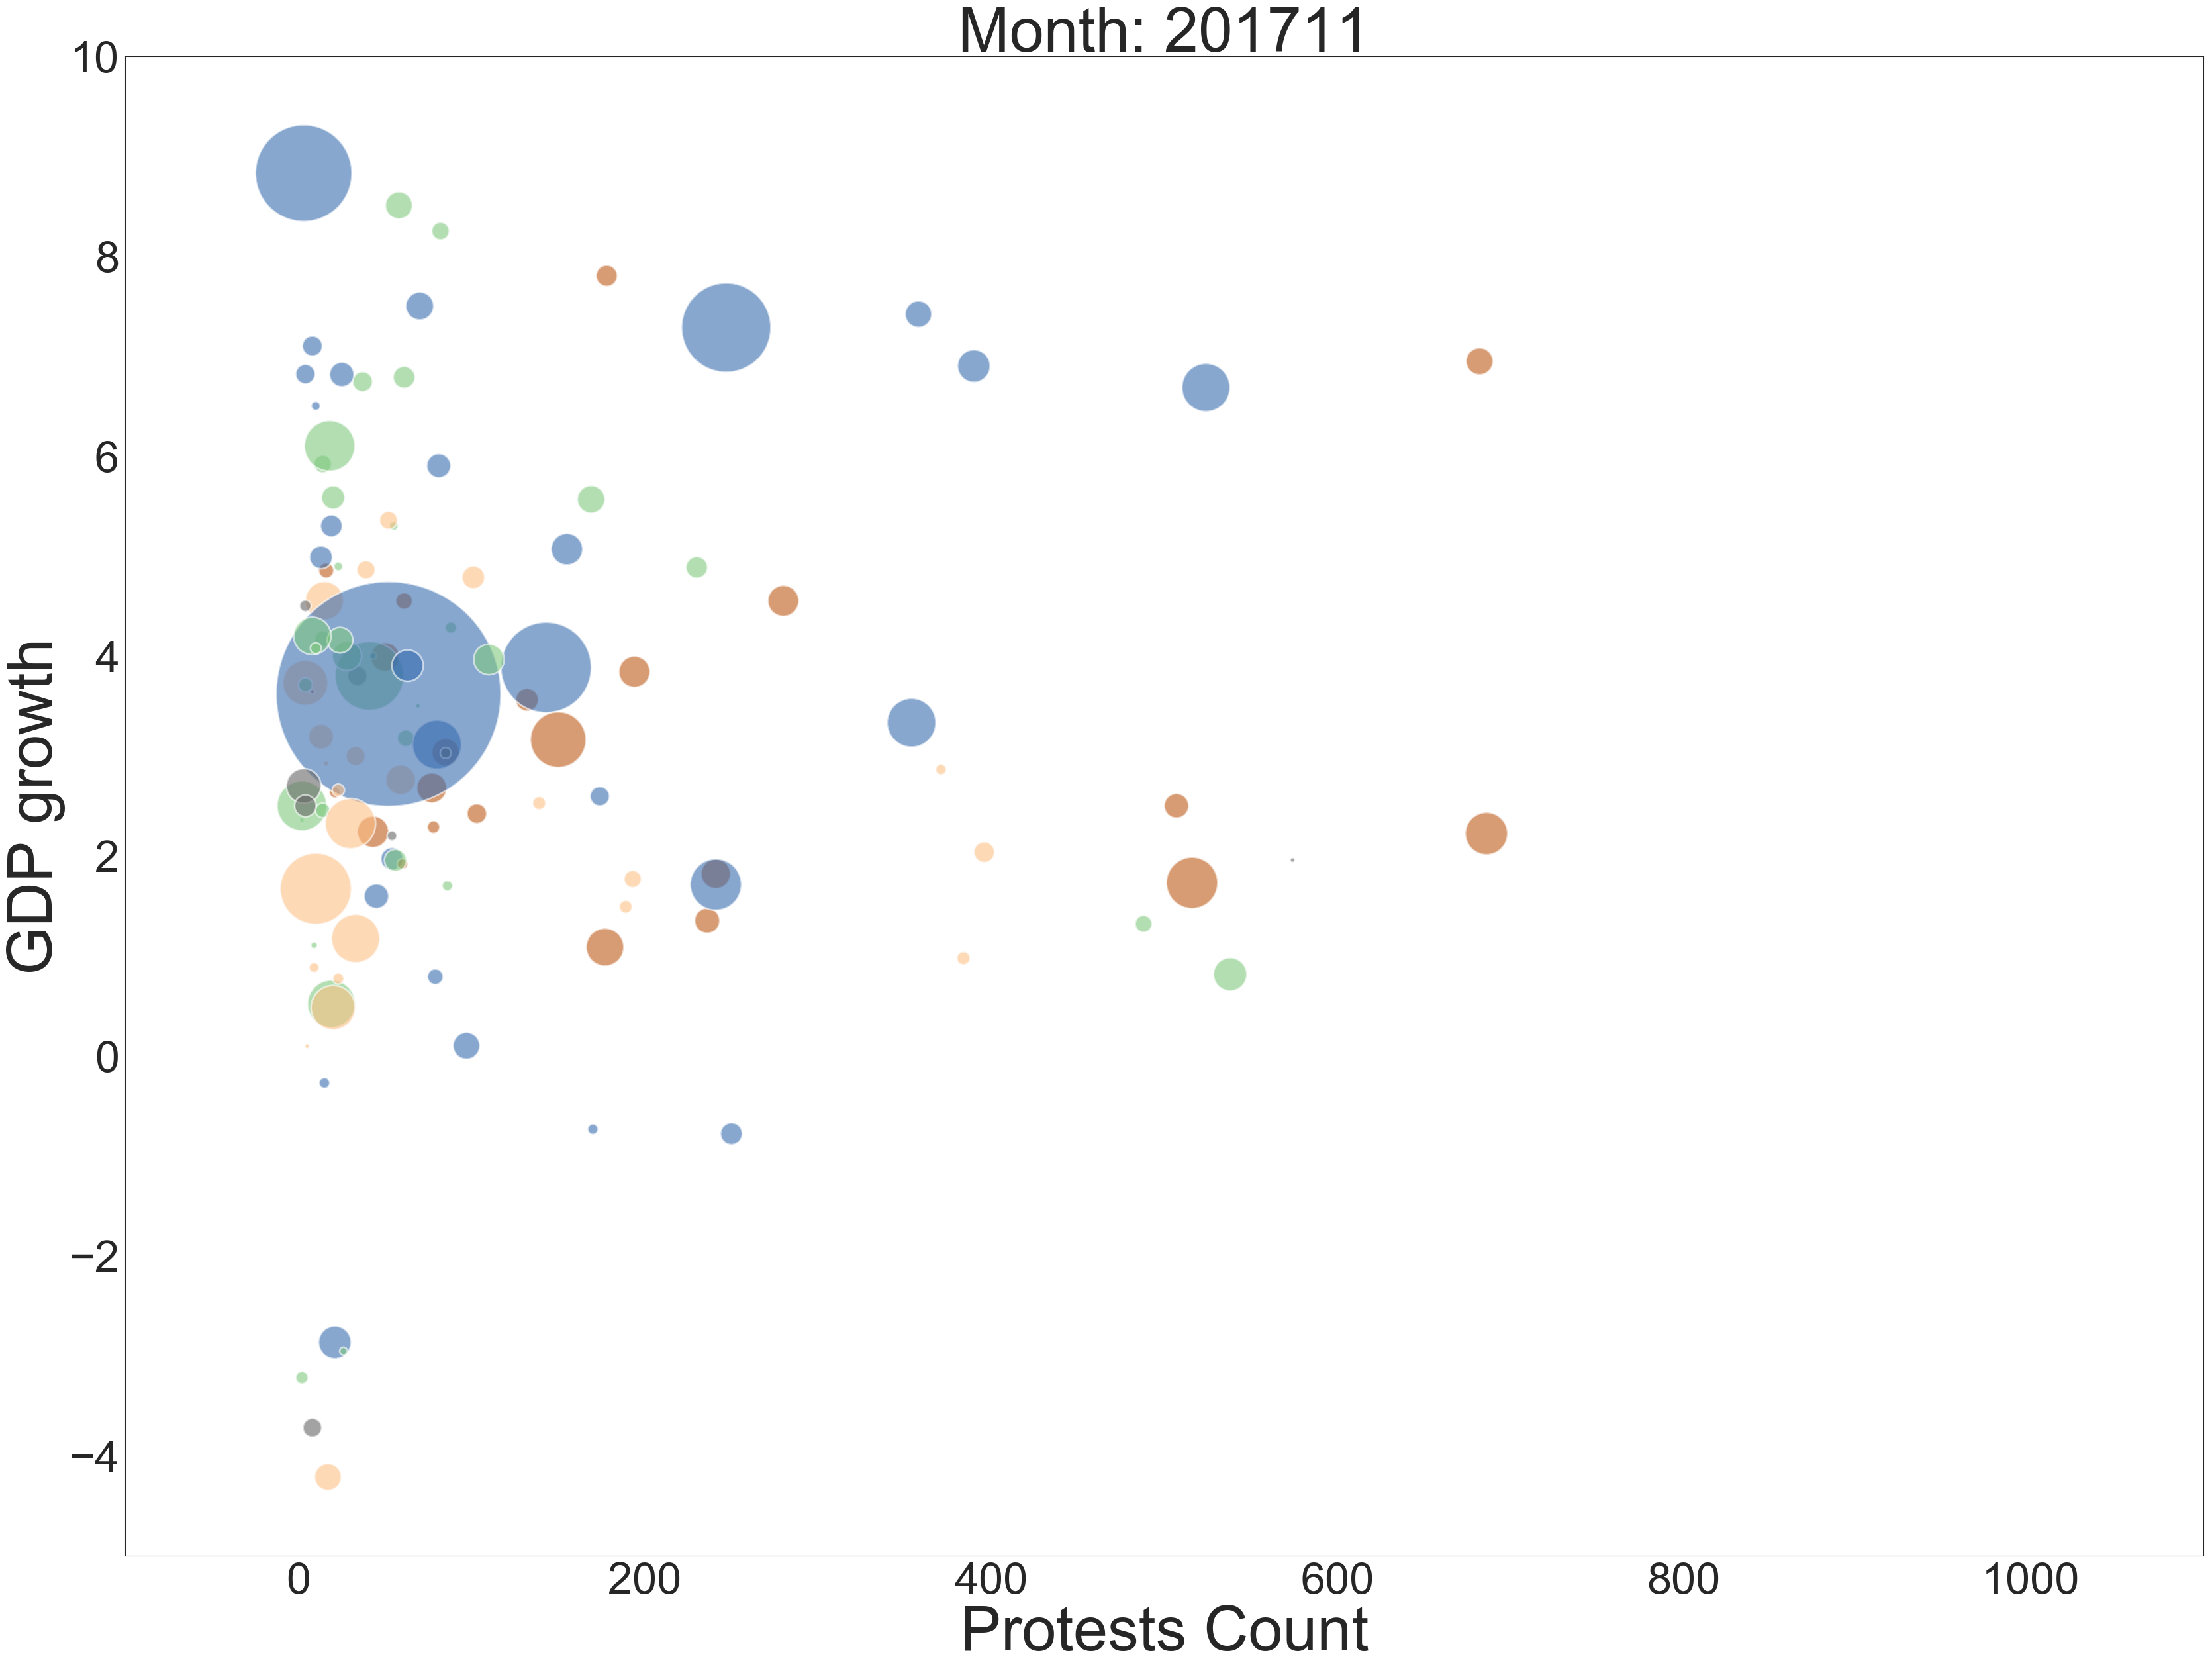

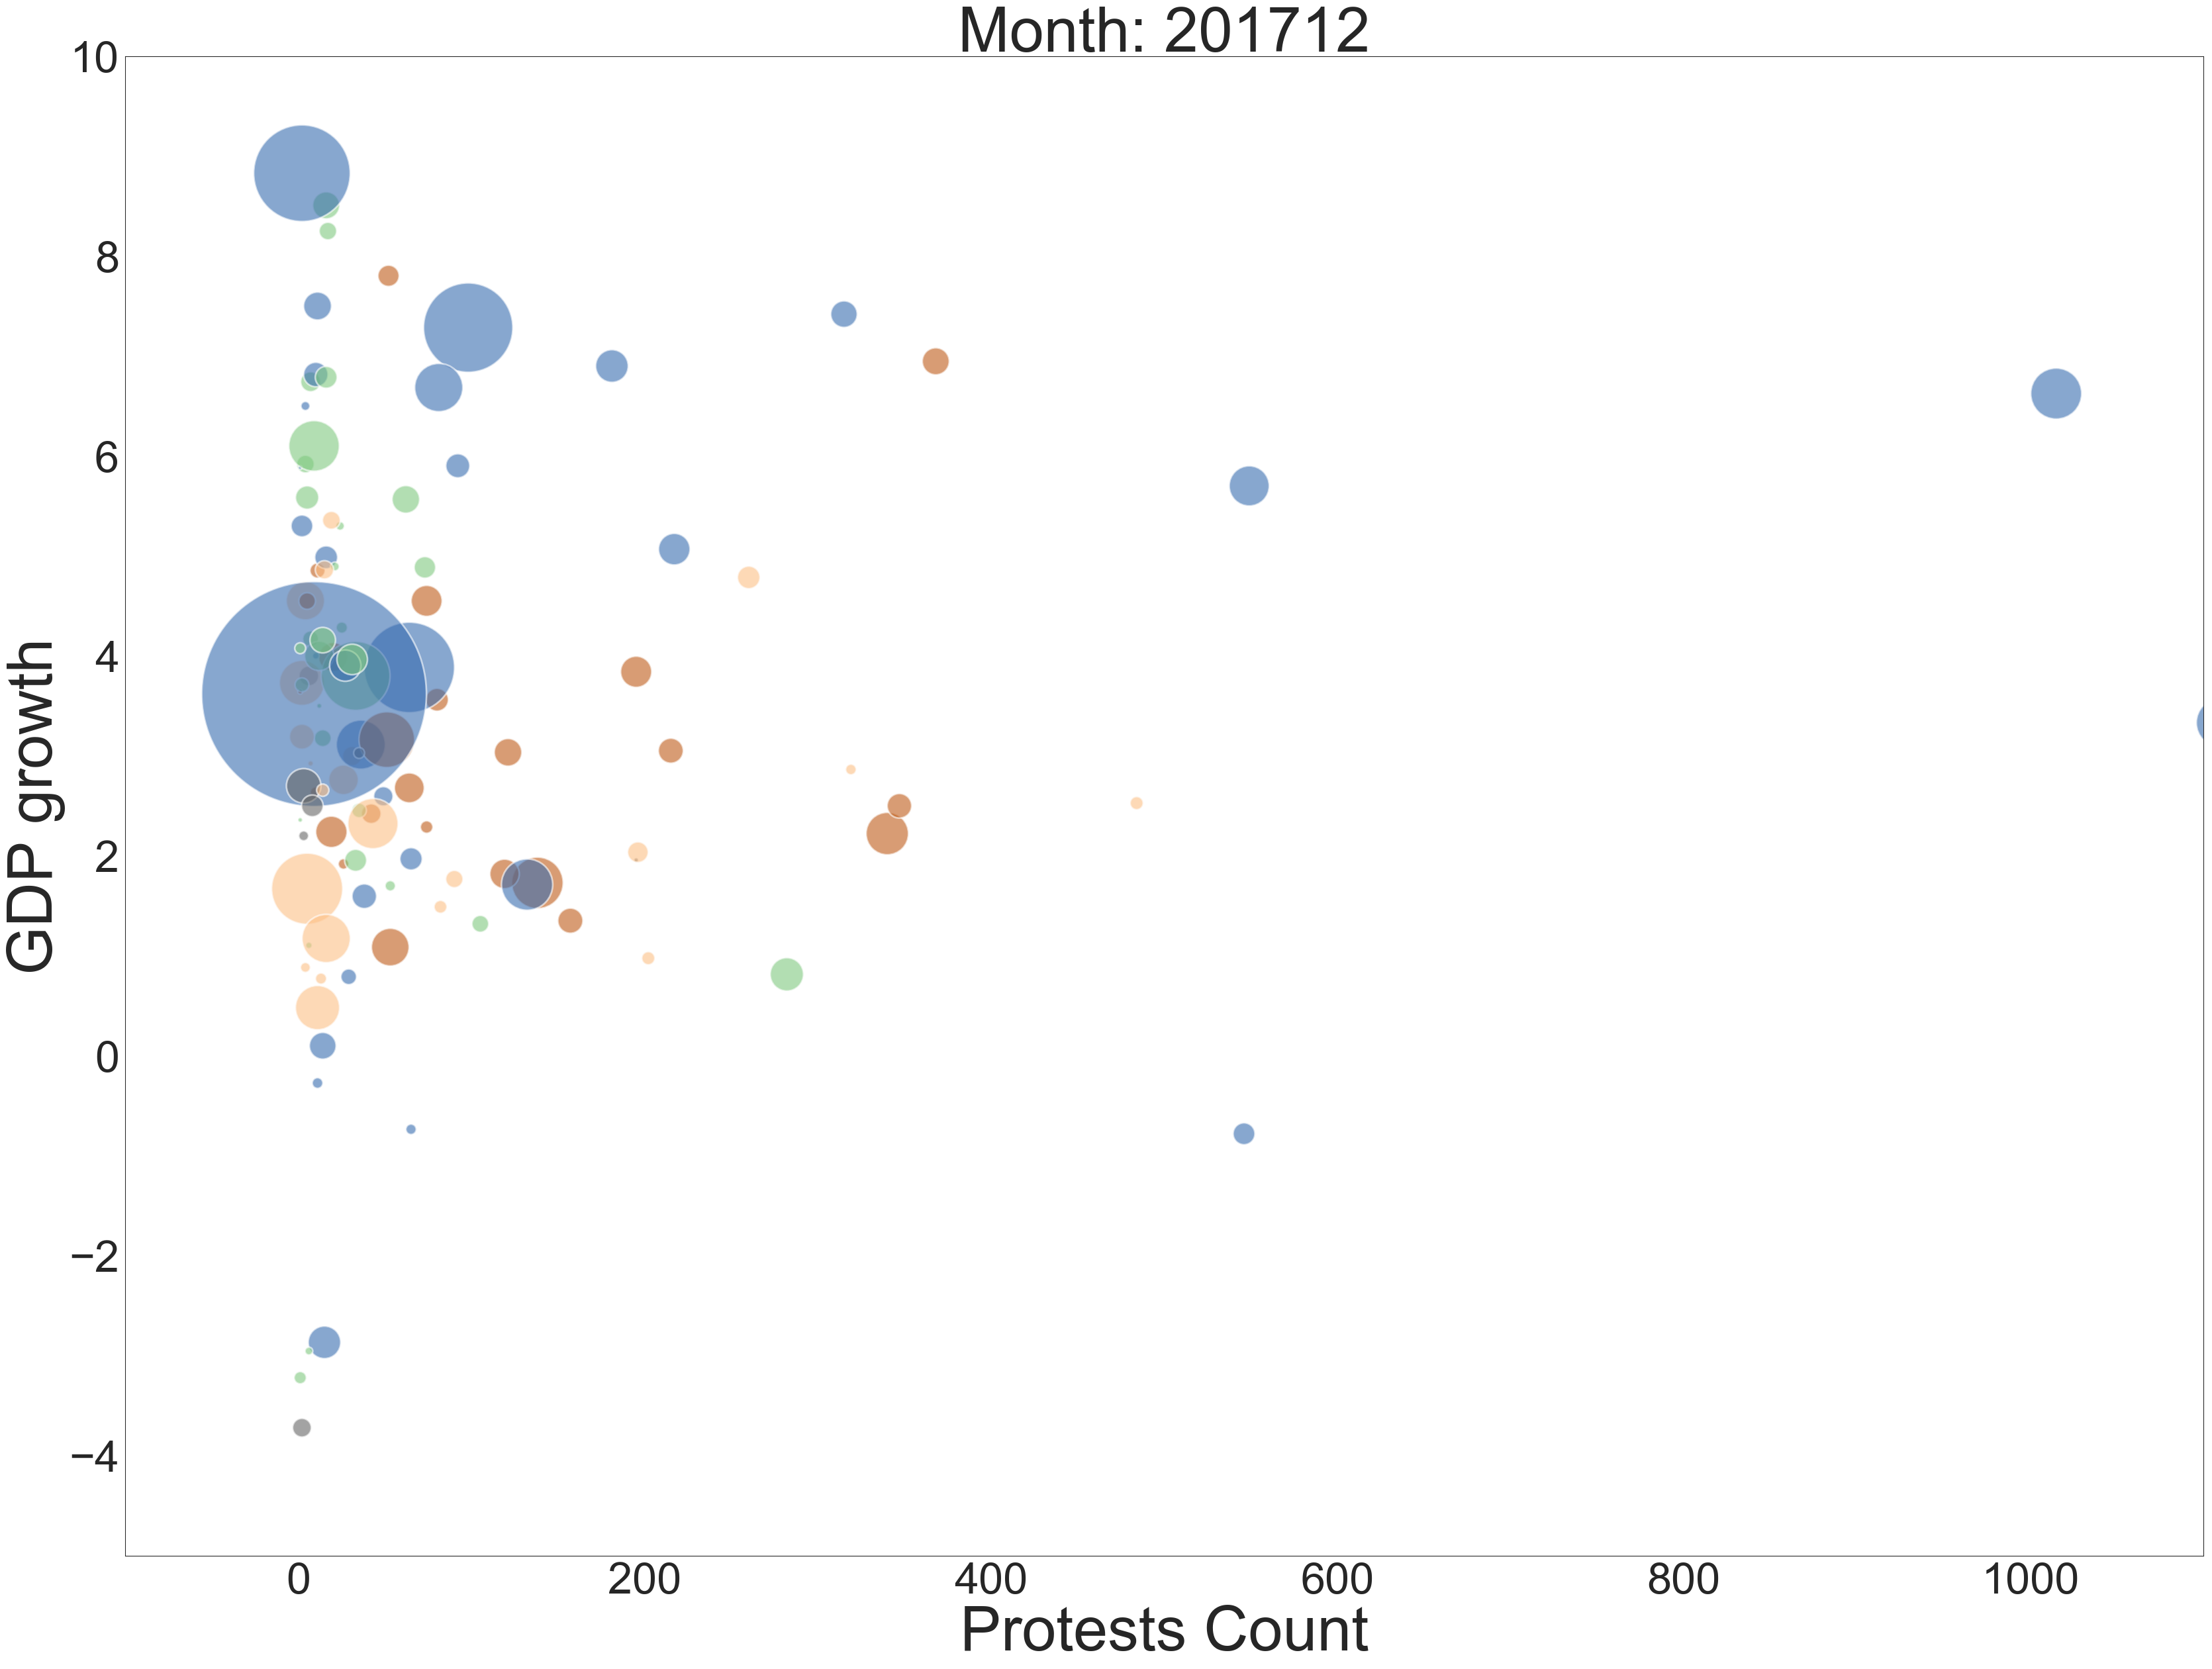

In [ ]:
displaying_visu_countries_stat(new_data, GDP_GROWTH_STAT_PATH)

The purpose of the visualization above is to verify is countries in the same continent are the same behavior. To achieve it, we are displaying a bubble for each country, its size depends of the population's density and the color depends of the continent. Then, we are displaying the GDP growth in function of the number of protests.

We made our analysis on our blog: https://ada-project.school.blog/

We wanted to see our stats in an appropriate format. With a dataframe, it's hard to visualize any correlation, we choose something more visual: 

In [ ]:
chart_data = get_df_for_countries_stats_visu(countries_all_stats, keep_US = True);
my_dpi=96
plt.figure(figsize=(7000/my_dpi, 7000/my_dpi), dpi=my_dpi)
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(chart_data.index))

for row in range(0, len(chart_data.index)):
    make_spider(chart_data, row=row, title=chart_data['Region'][row], color=my_palette(row))
filename='countries_stats_visu.png'
plt.savefig(STATS_REGION_PATH + filename, dpi=96)

Unfortunately, we got the same issue we got for the folium map about protest distribution. There are too many protests in the US to see anything in the other regions. We thus needed to visualize with an without the US to see it influence on the visualization:

In [ ]:
chart_data = get_df_for_countries_stats_visu(countries_all_stats, keep_US = False);
my_dpi=96
plt.figure(figsize=(7000/my_dpi, 7000/my_dpi), dpi=my_dpi)
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(chart_data.index))

for row in range(0, len(chart_data.index)):
    make_spider(chart_data, row=row, title=chart_data['Region'][row], color=my_palette(row))
filename='countries_stats_visu_without_US.png'
plt.savefig(STATS_REGION_PATH + filename, dpi=96)

In the dataframe above, we can access many statistics on each country such as density population, GDP (Gross Domestic Product), birthrate, deathrate, infant mortality, etc. Thanks to all this available data, we can perform a linear regression to get an idea of the impact of each variable on the number of protests (stored in the dataframe too):

## Linear Regression analysis

In [ ]:
#Using linear regression to find impact of each variable on the protests count
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 'Infant mortality (per 1000 births)',
                'GDP ($ per capita)', 'Deathrate', 'Phones (per 1000)', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)', 'Arable (%)', 'Crops (%)']
X = countries_all_stats[feature_cols]
y = countries_all_stats['protests count']
linRg = LinearRegression()  # create the model
linRg.fit(X, y)  # train it
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(linRg.coef_[f], feature_cols[f]))
print(linRg.intercept_)

## Comment:
The variable were not normalized the coefficient doesn't represent the importance of each feature. For example the percentage can obviously vary from 0 to 100 when the population varies from 20 thousand to 1.3 billion.

So we next check if these coefficents are statistically significant. To do so we will look at the P value for each variable. We use the standard threshold of 0.05, below this threshold the Null hypothesis is rejected.

In [ ]:
regression(countries_all_stats, feature_cols, 'protests count')

## Comments

Three variables have a P-value smaller than 0.05. The Area, the percentage of Arable land and the number of phones per 1000 people. 

However, we should be careful when analysing those results. Correlation doesn't mean causality. 

We could argue that as only the number of protests is recorded not their importance. The size of the country could have a role, in a small country the people will gather in only a few cities, when in a large country people will do smaller but more numerous protest spread across the country. 

The number of phones could also play a role as it it made small protests more visible.

However, it is difficult to see how the percentage of arable land plays a role.

Finally, we have shown above that the USA is a clear outlier. Thus the regression can simply show that the number of protests is related to have similar statistic as the USA.

## Add variables
### (HDI: Human Development Index)

In [ ]:

HDI_2017 = HDI[['Country', '2017']]
HDI_2017.columns = ['Country Name', 'HDI']
#clean it 
HDI_2017['Country Name'] = HDI_2017['Country Name'].apply(lambda x: x.strip())
countries_all_stats2 = pd.merge(countries_all_stats, HDI_2017, on='Country Name', how = 'inner')

### Check the new regression

In [ ]:
#Using linear regression to find impact of each variable on the protests count
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 'Infant mortality (per 1000 births)',
                'GDP ($ per capita)', 'Deathrate', 'Phones (per 1000)', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)', 'Arable (%)', 'Crops (%)', 'HDI']

regression(countries_all_stats2, feature_cols, 'protests count')

## comment:
The HDI doesn't seem to matter for the number of protests in a country, at least we cannot reject the null hypothesis that says it has no influence.

# A list of internal milestones until the presentation.

<u>**28/11/2018:**</u> Do the same analysis for different kind of protests such as the violent ones.
<br><br>
<u>**29/11/2018:**</u> deadline for finding new statistics on the countries (already more than 10 but it could be interesting to find other variables to evaluate.
<br><br>
<u>**31/11/2018:**</u> doing the analysis on each country but depending on the year. Finding a way to visualize the evolution of the protests numbers year per year
<br><br>
<u>**02/12/2018:**</u> finding impact of each variables on the protests number on each country based on the year As we have the number of protests per year and statistics on each country per year, we should be able to see the influence of each variable. For instance, is a country increase a lot his GDP ($ per capita) and not the other variables, and the number of protests decrease we could assume that they are related, etc (that's just a simple example).
<br><br>
<u>**05/12/2018:**</u> we though about implementing a dynamic world map that show the protests days by days in a quick way (to help you understanding what we mean, here an example of the result we would like: https://www.globalforestwatch.org/map
<br><br>
<u>**08/12/2018:**</u> we got almost all the results we wanted, we wrote good comments and explanations. The documentation is well done. We choose the way to present our work: a 4-page PDF document or a data story in a platform like a blog post.
<br><br>
<u>**14/12/2018:**</u> We got all the result we wanted. Our visualizations are good. The report or the data story through a platform is done.
<br><br>
<u>**15/12/2018:**</u> Last verifications for the deadline of the Dec. 16, 2018.
<br><br>
<u>**21/12/2018:**</u> Design of the poster, the presentation is ready
<br><br>**Presentation J-2:** Printing the poster.


## Is there any correlation between number of protests and an event ?
#### We choosed to work on the US Presidential Election of 2016.

In [ ]:
country_wanted = "United States"

In [ ]:
country_location = pd.read_csv(DATA_PATH + 'country_lat_long.csv')
for cln in country_location:
    country_location[cln] = country_location[cln].astype(str)
country_location['LatLong'] = '['+country_location['Latitude']+','+country_location['Longitude']+']'

In [ ]:
s = pd.Series(country_location['Country Name'])
if country_wanted in s.unique():
    latlong = country_location[country_location['Country Name'].str.contains(country_wanted)]['LatLong']
    latlong = latlong.iloc[0]
else: 
    print("Country wanted doesn't exist")
date_start = 20161108
date_end = 20161111
protests_wanted = filtering_df_date_country(protests_df_location,date_start = 20161108,date_end = 20161111, country = country_wanted)

In [ ]:
protests_wanted=protests_wanted.sort_values('SQLDATE')
protests_wanted['count'] = 0

In [ ]:
#getting a dataframe with appropriate format
protests_wanted_for_js = getting_appropriate_format_df_for_js(protests_wanted)
#getting the number of time each value was repeted 
protests_wanted_for_js = adding_count_columns(protests_wanted_for_js)
protests_wanted_for_js['count'] = protests_wanted_for_js['count'].astype(str)
protests_wanted_for_js["count"] = '[' + protests_wanted_for_js['count'] + '],'

In [ ]:
updating_js_script(protests_wanted_for_js, US_MAP_PATH, markers_number=7, markers_speed=0.1, zoom="4", LatLong=latlong)

In [ ]:
display(HTML("<h1><a href='"+US_MAP_PATH+"index.html' target='_blank'>Animated map which displays protests day by day in "+ country_wanted + " (Ctrl+Click)</a></h1>"))

By showing the frequency with color, we lost the information of the protests' kind. We thus wanted to change the way we displayed it. We choose to keep the color code for protests' kind but we change the way we are showing the frequency. We increase the circles each time a protest goes to a locate where other protests went.

Thanks to the visualization above we can confirm that all the protests are related to politics thanks to the color code. We are also able to visualize the frequency of the protests thanks to the circles' size.

We then wanted to put this visualization on the top of a map with the Clinton's electorate location. The following map would be better for this exercice:

# Visualizing the frequency of the protests around the US presidential elections

In [ ]:
date_start = 20161106
date_end = 20161115
country = 'United States'
protest_freq_US_elections = filtering_df_date_country(protests_df_location,date_start = 20161106, date_end = 20161115, country = 'United States')
protest_freq_US_elections = adding_count_of_repeated_values(protest_freq_US_elections)

In [ ]:
protest_freq_US_elections = protest_freq_US_elections.sort_values(['LatLong', 'count'], ascending=[True, False])
protest_freq_US_elections = removing_duplicated_locations(protest_freq_US_elections)
print("Number of protests selected: " + str(protest_freq_US_elections['SQLDATE'].count()))

In [ ]:
#if we get too many rows, changing n to the number of rows to delete
n = 0
protest_freq_US_elections = remove_randomly(protest_freq_US_elections,n)

In [ ]:
# Make an empty map
US_elections_2016 = folium.Map(location=[38.889931,-95.009003], tiles="OpenStreetMap", zoom_start=4)
legend_html = '  ' + str(country) + ', from: ' + str(date_start)[0:4] + '/' + str(date_start)[4:6] + '/' + str(date_start)[6:8] + ' to: ' + str(date_end)[0:4] + '/' + str(date_end)[4:6] + '/' + str(date_end)[6:8]
#Adding a circle on the map for each protest, the size is the image of the frequency of the protest
for i in range(0,len(protest_freq_US_elections)):
   folium.Circle(
      location=[float(protest_freq_US_elections.iloc[i]['ActionGeo_Lat']), float(protest_freq_US_elections.iloc[i]['ActionGeo_Long'])],
      popup=protest_freq_US_elections.iloc[i]['ActionGeo_FullName'],
      radius=int(protest_freq_US_elections.iloc[i]['count']*800),
      color='yellow',
      fill=True,
      fill_color='yellow',
      fill_opacity=0.1
   ).add_to(US_elections_2016)

US_elections_2016.get_root().html.add_child(folium.Element(legend_html))

US_elections_2016.save(FOLIUM_MAPS_PATH + 'US_elections_2016.html')
display(HTML("<h1><a href='"+FOLIUM_MAPS_PATH+"US_elections_2016.html' target='_blank'>Protests' intensity for US elections in 2016 (Ctrl+Click)</a></h1>"))

US_elections_2016

We then put the map above on the top of the US' electorate, Trump in red, Clinton in bleu:

In [ ]:
display(Image(US_MAP_FREQ_PATH + 'static_map.png', width=500, unconfined=True))

We can see that, effectively, the protests' location correspond to the Cliton's electorate area!

We went deeper in our analysis on our blog: https://ada-project.school.blog/

### Does all the protest have the same impact ?

In [ ]:
average = protests_df.groupby('Country Code').mean()
average = average.reset_index()
max_nb_protests = average['NumMentions'].values.max()
min_nb_protests = average['NumMentions'].values.min()
colormap = linear.YlGn_09.scale(min_nb_protests, max_nb_protests)
colormap.caption = 'Mean Number of mentions since 2005'
location=[46.9,8.25]
x = 'Country Code'
y = 'NumMentions'

results_map_NumMentions = folium_map(average, x, y, location, countries_topodata, colormap, zoom=2)

results_map_NumMentions.save(FOLIUM_MAPS_PATH + 'results_map_NumMentions.html')
display(HTML("<h1><a href='"+FOLIUM_MAPS_PATH+"results_map_NumMentions.html' target='_blank'>Map which displays the number of mentions (Ctrl+Click)</a></h1>"))
results_map_NumMentions

In [ ]:
#reset plt stetting
mpl.rcParams.update(mpl.rcParamsDefault)

We see that the south america countries have all a similar mean number of mention of each protests.

We thus decided to analyse more precisely the number of protests in function of different variables.

Analyzing the South America countries has the additional advantage of comparing countries with similar cultures and governement style. They are of course different but they are more similar than say USA and China.

In [ ]:
protest_importance_per_country_year = protests_df.groupby(['Country Code', 'Year']).agg(\
    {'ID': 'count', 'NumMentions': 'mean', 'AvgTone':'mean'})
protest_importance_per_country_year.columns=[ 'Nb protests', 'Mean Nb mention', 'Mean AvgTone']
south_america_country_code=['VEN', 'GUY', 'SUR',  'BRA', 'COL', 'ECU', 'PER', 'CHL', 'ARG', 'PRY', 'URY']
temp_data = protest_importance_per_country_year.reset_index()
SA_protests_data = temp_data[temp_data['Country Code'].isin(south_america_country_code)]
SA_protests_data.head()

In [ ]:
# add GDP growth
gdp_growth = pd.read_csv(DATA_PATH + "gdp_growth.csv", error_bad_lines=False, skiprows=4)
gdp_growth.drop(labels=[ 'Indicator Code', 'Indicator Name'], axis=1, inplace=True)
gdp_growth.head()

In [ ]:
# Put the year in column
temp =gdp_growth.pivot(index='Country Name', columns='Country Code')

temp.fillna(0, inplace=True)
temp = temp.sum(axis=0)
temp = pd.DataFrame(temp)
temp.reset_index(inplace=True)
temp.columns = ['Year', 'Country Code', 'Gdp growth']
temp.Year = temp.Year.map(float)

gdp_growth2 = temp
temp.head()

Get the data about the South American countries.

In [ ]:
countries_stats_with_code=pd.merge(countries_stats, country_codes_to_name, how='left', on='Country Name')
countries_stats_with_code=countries_stats_with_code.dropna()
SA_countries_all_stats3=pd.merge(countries_stats_with_code, SA_protests_data, how='right', on='Country Code')
SA_countries_all_stats3.set_index(['Country Code', 'Year'],inplace=True)
SA_countries_all_stats3 = pd.merge(SA_countries_all_stats3, gdp_growth2, on=['Country Code', 'Year'])
SA_countries_all_stats3.dropna(inplace=True)

In [ ]:
feature_cols = ['Gdp growth', 'Literacy (%)'
                ,'Population','Net migration'
               ,'GDP ($ per capita)',  'Phones (per 1000)' 
                , 'Area (sq. mi.)']
regression(SA_countries_all_stats3, feature_cols, 'Nb protests')

Removing the least significant dimensions until we get only significant ones
in order remove:

'Literacy (%)'

Area (sq. mi.)

GDP ($ per capita)

Phones (per 1000)

Net migration

Keep population and GDP growth

In [ ]:
regression(SA_countries_all_stats3, ['Gdp growth', 'Population'], 'Nb protests')

### protests year long

We should also realize that a significant proportion of protest is nearly impossible to predict. We might identify situations where protests have a higher risk to occur. We found that the GDP growth is clearly inversely proportional to the number of protests. However, this is a general data on the year long and we cannot capture the burst of protest.


A very speaking example of this unpredictability of a spike in number of protests is the Arab spring (sadly the data did not contain this period). This movement has taken the world by surprise and of course after hand, we can see indicators telling us that a revolution was probable, but they are no reason why it happened at that time and not six months before or after. Another example is the jellow jacket movement in France, really who could have predicted that this small tax increase would have created such a backslash. At least we know that the French government did not predict it, they wouldn't have done it otherwise. 



They are also situation where we can easily predict a large number of protests if an uncertain event occurs. A nice example is after an election. We have already talked about the election of Donal Trump, we can also look at the election of the next Brasilien president. In Italy the effect is more subtle (election in March 2018)) 



Of course, one can argue that the election of "far right" politician and large social movement are due to a weak economy. However, it is difficult to time the social movement and the outcome of an election. Why was is this reform that create such an anger in France and not the last or next one. And most people predicted that Trump was going to lose in 2016. Would they have been so many protests if Clinton had been elected, probably not.

Protests in France in 2017 and 2018

In [ ]:

#plot result
show_nb_protest_per_month(protests_df, CountryCode='FRA', year=2018)
plt.title('France 2018')
plt.show()

In [ ]:
show_nb_protest_per_month(protests_df, CountryCode='FRA', year=2017)
plt.title('France 2017')
plt.show()

We clearly see the jellow jacket movement. The number of protests in December has mor than double compared to the previous year and the month is not over.

In [ ]:
show_nb_protest_per_month(protests_df, CountryCode='USA', year=2016)
plt.title('USA 2016')
plt.show()

We see two peaks in October the election of Jair Bolsonaro and in April the confirmation by the supreme court of the imprisonment of the ex president Lula.

In [ ]:
show_nb_protest_per_month(protests_df, CountryCode='ITA', year=2018)
plt.title('Italy 2018')
plt.show()

In March the election of the euroseptic government seems to have a far lesser impact as the last two elections.